In [1]:
from keras.datasets.fashion_mnist import load_data
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
(train_X,train_y),(test_X,test_y)=load_data()

In [3]:
print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


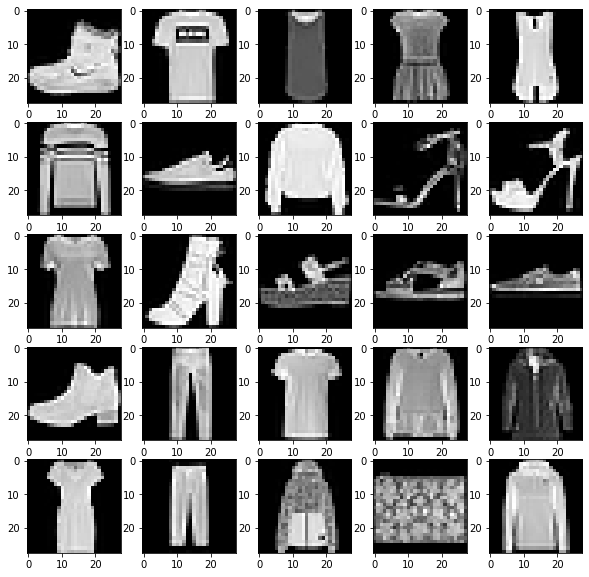

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(train_X[i],cmap='gray')

# Discirminator NN  
![conditional GAN](https://1.bp.blogspot.com/-VbN9CsqICz4/XVPH1ErlHqI/AAAAAAAAEas/kL7-iB1ExZYHB1rzgr14rj2W9WyUejFWQCLcBGAs/s640/%25E6%2593%25B7%25E5%258F%2596.PNG)  
2 conv layer + 1 full connect layer  
__Finally to 128 7*7 feature maps__  

In [5]:
def discriminator():
    c_input=tf.keras.layers.Input(shape=(1,))
    c=tf.keras.layers.Embedding(len(labels),50)(c_input) #10 class of cloth->50-dim vector
    c=tf.keras.layers.Dense(train_X.shape[1]*train_X.shape[2]*train_X.shape[3],activation='linear')(c)
    c=tf.keras.layers.Reshape((train_X.shape[1],train_X.shape[2],train_X.shape[3]))(c)
    
    x_input=tf.keras.layers.Input(shape=(train_X.shape[1],train_X.shape[2],train_X.shape[3]))
    
    m=tf.keras.layers.Concatenate()([c,x_input]) #become(28*28*2)
    m=tf.keras.layers.Conv2D(128,(3,3),strides=(2,2),padding='same')(m)
    m=tf.keras.layers.LeakyReLU(alpha=0.2)(m) #become(14*14*128)
    m=tf.keras.layers.Conv2D(128,(3,3),strides=(2,2),padding='same')(m)
    m=tf.keras.layers.LeakyReLU(alpha=0.2)(m) #become(7*7*128)
    m=tf.keras.layers.Flatten()(m)
    m=tf.keras.layers.Dropout(0.4)(m)
    m=tf.keras.layers.Dense(1,activation='sigmoid')(m)
    
    model=tf.keras.Model(inputs=[c_input,x_input],outputs=m)
    opt=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['acc'])
    return model

# Generator NN  
![conditional GAN](https://1.bp.blogspot.com/-VbN9CsqICz4/XVPH1ErlHqI/AAAAAAAAEas/kL7-iB1ExZYHB1rzgr14rj2W9WyUejFWQCLcBGAs/s640/%25E6%2593%25B7%25E5%258F%2596.PNG)  

In [6]:
def generator():
    c_input=tf.keras.Input(shape=(1,))
    c=tf.keras.layers.Embedding(len(labels),50)(c_input)
    c=tf.keras.layers.Dense(7*7,activation='linear')(c)
    c=tf.keras.layers.Reshape((7,7,1))(c)
    
    z_input=tf.keras.Input(shape=(latent_dim,))
    z=tf.keras.layers.Dense(7*7*128)(z_input)
    z=tf.keras.layers.LeakyReLU(alpha=0.2)(z)
    z=tf.keras.layers.Reshape((7,7,128))(z)
    
    m=tf.keras.layers.Concatenate()([c,z]) #become(7*7*129)
    m=tf.keras.layers.Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')(m) #become(14*14*128)
    m=tf.keras.layers.LeakyReLU(alpha=0.2)(m)
    m=tf.keras.layers.Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')(m) #become(28*28*128)
    m=tf.keras.layers.LeakyReLU(alpha=0.2)(m)
    m=tf.keras.layers.Conv2D(1,(7,7),activation='tanh',padding='same')(m)
    
    model=tf.keras.Model(inputs=[c_input,z_input],outputs=m)
    return model

# Image Generator(for discriminator)

In [7]:
def real_image_generator(num):
    rand=np.random.randint(0,train_X.shape[0],num)
    x=train_X[rand]
    c=train_y[rand]
    real=np.ones((num,1))
    return [c,x],real

In [8]:
def fake_image_generator(g_model,num):
    z=np.random.randn(num,latent_dim)
    c=np.random.randint(0,len(labels),num)
    x=g_model.predict([c,z])
    fake=np.zeros((num,1))
    return [c,x],fake

# Training

In [9]:
def gan(g_model,d_model):
    d_model.trainable=False
    c,z=g_model.input
    model=tf.keras.Model(inputs=g_model.input,outputs=[d_model(inputs=[c,g_model.output])])
    opt=tf.keras.optimizers.Adam(lr=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=opt)
    return model

In [10]:
def fit(g_model,d_model,epochs=100,batch_size=128):
    gan_model=gan(g_model,d_model)
    batchs=train_X.shape[0]//batch_size
    for epoch in range(1,epochs+1):
        for batch in range(1,batchs+1):
            #fit discriminator,half real image half fake image
            [c,x],real=real_image_generator(batch_size//2)
            loss_d1,_=d_model.train_on_batch([c,x],real)
            [c,x],fake=fake_image_generator(g_model,batch_size//2)
            loss_d2,_=d_model.train_on_batch([c,x],fake)
            #fit generator
            z=np.random.randn(batch_size,latent_dim)
            c=np.random.randint(0,len(labels),batch_size)
            loss_g=gan_model.train_on_batch([c,z],np.ones((batch_size,1)))
            print('epoch{} {}/{} loss_d1:{:.2f},loss_d2:{:.2f},loss_g:{:.2f}'.format(epoch,batch,batchs,loss_d1,loss_d2,loss_g))
        if epoch%10==0:
            summarize_performance(epoch,g_model,d_model)

In [11]:
def summarize_performance(epoch,g_model,d_model,num=100):
    #show acc
    [c,x],real=real_image_generator(num)
    _,acc_real=d_model.evaluate([c,x],real,verbose=0)
    [c,x],fake=fake_image_generator(g_model,num)
    _,acc_fake=d_model.evaluate([c,x],fake,verbose=0)
    print('evaluate acc_fake:{:.2f} acc_real:{:.2f}'.format(acc_fake*100,acc_real*100))
    #save fake img
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(np.squeeze((x[i]+1)/2),cmap='gray') #from [-1,1] to [0,1]
        plt.axis('off')
        plt.title(labels[c[i]])
    plt.savefig('cDCGAN Fashion-MNIST\\fakeImg epoch{}.png'.format(epoch))
    plt.close()
    #save model
    g_model.save('cDCGAN Fashion-MNIST\\generator epoch{}.h5'.format(epoch))

# Start GAN

### Image's pixel range from \[0,255\] to \[-1,1\]
The generator model will generate images with pixel values in the range \[-1,1\] as it will use the tanh activation function, a best practice.  
We will used only train_X for GAN.  
train_y,test_X,test_y will be abandoned.

In [12]:
(train_X,train_y),(_,_)=load_data()
train_X=np.expand_dims(train_X,axis=-1)
train_X=(train_X.astype(float)-127.5)/127.5 #from[0,255] to [-1,1]

### Define Latent Space
can be 10,20,50,100...
each dimension represent specific features  

In [13]:
latent_dim=100

### Fashion-MNIST labels

In [14]:
labels=['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

### start

In [15]:
g_model=generator()
d_model=discriminator()
fit(g_model,d_model,epochs=100)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
epoch1 1/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.69
epoch1 2/468 loss_d1:0.63,loss_d2:0.70,loss_g:0.69
epoch1 3/468 loss_d1:0.55,loss_d2:0.71,loss_g:0.68
epoch1 4/468 loss_d1:0.49,loss_d2:0.73,loss_g:0.66
epoch1 5/468 loss_d1:0.43,loss_d2:0.75,loss_g:0.64
epoch1 6/468 loss_d1:0.38,loss_d2:0.78,loss_g:0.62
epoch1 7/468 loss_d1:0.35,loss_d2:0.82,loss_g:0.61
epoch1 8/468 loss_d1:0.32,loss_d2:0.83,loss_g:0.60
epoch1 9/468 loss_d1:0.30,loss_d2:0.83,loss_g:0.63
epoch1 10/468 loss_d1:0.31,loss_d2:0.78,loss_g:0.69
epoch1 11/468 loss_d1:0.31,loss_d2:0.70,loss_g:0.77
epoch1 12/468 loss_d1:0.35,loss_d2:0.62,loss_g:0.85
epoch1 13/468 loss_d1:0.32,loss_d2:0.57,loss_g:0.92
epoch1 14/468 loss_d1:0.33,loss_d2:0.55,loss_g:0.91
epoch1 15/468 loss_d1:0.31,loss_d2:0.59,loss_g

epoch1 136/468 loss_d1:0.64,loss_d2:0.49,loss_g:1.30
epoch1 137/468 loss_d1:0.63,loss_d2:0.39,loss_g:1.52
epoch1 138/468 loss_d1:0.54,loss_d2:0.30,loss_g:1.75
epoch1 139/468 loss_d1:0.56,loss_d2:0.29,loss_g:1.66
epoch1 140/468 loss_d1:0.57,loss_d2:0.36,loss_g:1.46
epoch1 141/468 loss_d1:0.47,loss_d2:0.64,loss_g:1.07
epoch1 142/468 loss_d1:0.44,loss_d2:0.93,loss_g:0.79
epoch1 143/468 loss_d1:0.56,loss_d2:1.07,loss_g:0.67
epoch1 144/468 loss_d1:0.77,loss_d2:1.03,loss_g:0.67
epoch1 145/468 loss_d1:0.63,loss_d2:0.94,loss_g:0.73
epoch1 146/468 loss_d1:0.73,loss_d2:0.89,loss_g:0.76
epoch1 147/468 loss_d1:0.81,loss_d2:0.79,loss_g:0.84
epoch1 148/468 loss_d1:0.84,loss_d2:0.66,loss_g:0.91
epoch1 149/468 loss_d1:0.80,loss_d2:0.56,loss_g:0.98
epoch1 150/468 loss_d1:0.79,loss_d2:0.54,loss_g:1.05
epoch1 151/468 loss_d1:0.71,loss_d2:0.47,loss_g:1.14
epoch1 152/468 loss_d1:0.69,loss_d2:0.45,loss_g:1.19
epoch1 153/468 loss_d1:0.64,loss_d2:0.40,loss_g:1.25
epoch1 154/468 loss_d1:0.59,loss_d2:0.39,loss_

epoch1 291/468 loss_d1:0.67,loss_d2:0.58,loss_g:0.88
epoch1 292/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.82
epoch1 293/468 loss_d1:0.74,loss_d2:0.79,loss_g:0.65
epoch1 294/468 loss_d1:0.63,loss_d2:0.89,loss_g:0.59
epoch1 295/468 loss_d1:0.65,loss_d2:0.98,loss_g:0.54
epoch1 296/468 loss_d1:0.59,loss_d2:0.99,loss_g:0.56
epoch1 297/468 loss_d1:0.65,loss_d2:0.93,loss_g:0.57
epoch1 298/468 loss_d1:0.65,loss_d2:0.88,loss_g:0.60
epoch1 299/468 loss_d1:0.63,loss_d2:0.81,loss_g:0.66
epoch1 300/468 loss_d1:0.62,loss_d2:0.76,loss_g:0.73
epoch1 301/468 loss_d1:0.62,loss_d2:0.71,loss_g:0.75
epoch1 302/468 loss_d1:0.61,loss_d2:0.65,loss_g:0.82
epoch1 303/468 loss_d1:0.60,loss_d2:0.64,loss_g:0.85
epoch1 304/468 loss_d1:0.55,loss_d2:0.65,loss_g:0.84
epoch1 305/468 loss_d1:0.59,loss_d2:0.67,loss_g:0.82
epoch1 306/468 loss_d1:0.56,loss_d2:0.65,loss_g:0.80
epoch1 307/468 loss_d1:0.57,loss_d2:0.73,loss_g:0.72
epoch1 308/468 loss_d1:0.59,loss_d2:0.79,loss_g:0.70
epoch1 309/468 loss_d1:0.56,loss_d2:0.80,loss_

epoch1 446/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.78
epoch1 447/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.78
epoch1 448/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.77
epoch1 449/468 loss_d1:0.69,loss_d2:0.72,loss_g:0.76
epoch1 450/468 loss_d1:0.73,loss_d2:0.70,loss_g:0.71
epoch1 451/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.73
epoch1 452/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.73
epoch1 453/468 loss_d1:0.75,loss_d2:0.73,loss_g:0.73
epoch1 454/468 loss_d1:0.72,loss_d2:0.73,loss_g:0.76
epoch1 455/468 loss_d1:0.72,loss_d2:0.71,loss_g:0.73
epoch1 456/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.77
epoch1 457/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.78
epoch1 458/468 loss_d1:0.73,loss_d2:0.65,loss_g:0.79
epoch1 459/468 loss_d1:0.71,loss_d2:0.63,loss_g:0.82
epoch1 460/468 loss_d1:0.72,loss_d2:0.65,loss_g:0.82
epoch1 461/468 loss_d1:0.71,loss_d2:0.61,loss_g:0.85
epoch1 462/468 loss_d1:0.72,loss_d2:0.61,loss_g:0.84
epoch1 463/468 loss_d1:0.68,loss_d2:0.62,loss_g:0.84
epoch1 464/468 loss_d1:0.70,loss_d2:0.61,loss_

epoch2 135/468 loss_d1:0.70,loss_d2:0.75,loss_g:0.72
epoch2 136/468 loss_d1:0.68,loss_d2:0.72,loss_g:0.73
epoch2 137/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.77
epoch2 138/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.81
epoch2 139/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.84
epoch2 140/468 loss_d1:0.69,loss_d2:0.59,loss_g:0.87
epoch2 141/468 loss_d1:0.67,loss_d2:0.60,loss_g:0.86
epoch2 142/468 loss_d1:0.65,loss_d2:0.57,loss_g:0.87
epoch2 143/468 loss_d1:0.63,loss_d2:0.60,loss_g:0.87
epoch2 144/468 loss_d1:0.70,loss_d2:0.63,loss_g:0.79
epoch2 145/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.81
epoch2 146/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.73
epoch2 147/468 loss_d1:0.63,loss_d2:0.71,loss_g:0.72
epoch2 148/468 loss_d1:0.66,loss_d2:0.73,loss_g:0.72
epoch2 149/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.75
epoch2 150/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.76
epoch2 151/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.78
epoch2 152/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.80
epoch2 153/468 loss_d1:0.66,loss_d2:0.61,loss_

epoch2 290/468 loss_d1:0.52,loss_d2:0.66,loss_g:0.83
epoch2 291/468 loss_d1:0.57,loss_d2:0.65,loss_g:0.82
epoch2 292/468 loss_d1:0.53,loss_d2:0.66,loss_g:0.84
epoch2 293/468 loss_d1:0.59,loss_d2:0.66,loss_g:0.85
epoch2 294/468 loss_d1:0.52,loss_d2:0.62,loss_g:0.85
epoch2 295/468 loss_d1:0.55,loss_d2:0.61,loss_g:0.83
epoch2 296/468 loss_d1:0.53,loss_d2:0.69,loss_g:0.87
epoch2 297/468 loss_d1:0.57,loss_d2:0.60,loss_g:0.93
epoch2 298/468 loss_d1:0.57,loss_d2:0.62,loss_g:0.88
epoch2 299/468 loss_d1:0.60,loss_d2:0.63,loss_g:0.90
epoch2 300/468 loss_d1:0.54,loss_d2:0.60,loss_g:0.90
epoch2 301/468 loss_d1:0.49,loss_d2:0.62,loss_g:0.92
epoch2 302/468 loss_d1:0.54,loss_d2:0.63,loss_g:0.89
epoch2 303/468 loss_d1:0.52,loss_d2:0.63,loss_g:0.88
epoch2 304/468 loss_d1:0.50,loss_d2:0.60,loss_g:0.89
epoch2 305/468 loss_d1:0.56,loss_d2:0.66,loss_g:0.92
epoch2 306/468 loss_d1:0.49,loss_d2:0.58,loss_g:0.93
epoch2 307/468 loss_d1:0.54,loss_d2:0.59,loss_g:0.92
epoch2 308/468 loss_d1:0.60,loss_d2:0.57,loss_

epoch2 445/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.77
epoch2 446/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.75
epoch2 447/468 loss_d1:0.70,loss_d2:0.74,loss_g:0.72
epoch2 448/468 loss_d1:0.63,loss_d2:0.71,loss_g:0.77
epoch2 449/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.79
epoch2 450/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.83
epoch2 451/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.85
epoch2 452/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.83
epoch2 453/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.80
epoch2 454/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.79
epoch2 455/468 loss_d1:0.70,loss_d2:0.73,loss_g:0.77
epoch2 456/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.75
epoch2 457/468 loss_d1:0.67,loss_d2:0.73,loss_g:0.72
epoch2 458/468 loss_d1:0.70,loss_d2:0.73,loss_g:0.77
epoch2 459/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch2 460/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.81
epoch2 461/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.81
epoch2 462/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.81
epoch2 463/468 loss_d1:0.66,loss_d2:0.64,loss_

epoch3 134/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.75
epoch3 135/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.77
epoch3 136/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.75
epoch3 137/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.74
epoch3 138/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.75
epoch3 139/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.77
epoch3 140/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.81
epoch3 141/468 loss_d1:0.67,loss_d2:0.62,loss_g:0.83
epoch3 142/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.82
epoch3 143/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.83
epoch3 144/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.81
epoch3 145/468 loss_d1:0.67,loss_d2:0.62,loss_g:0.80
epoch3 146/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.82
epoch3 147/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.78
epoch3 148/468 loss_d1:0.66,loss_d2:0.73,loss_g:0.74
epoch3 149/468 loss_d1:0.61,loss_d2:0.72,loss_g:0.75
epoch3 150/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.73
epoch3 151/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch3 152/468 loss_d1:0.68,loss_d2:0.66,loss_

epoch3 289/468 loss_d1:0.69,loss_d2:0.73,loss_g:0.75
epoch3 290/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.77
epoch3 291/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.79
epoch3 292/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.81
epoch3 293/468 loss_d1:0.72,loss_d2:0.60,loss_g:0.87
epoch3 294/468 loss_d1:0.68,loss_d2:0.59,loss_g:0.89
epoch3 295/468 loss_d1:0.71,loss_d2:0.58,loss_g:0.89
epoch3 296/468 loss_d1:0.69,loss_d2:0.62,loss_g:0.88
epoch3 297/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.86
epoch3 298/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.80
epoch3 299/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.77
epoch3 300/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.78
epoch3 301/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.75
epoch3 302/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.75
epoch3 303/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.79
epoch3 304/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.79
epoch3 305/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.81
epoch3 306/468 loss_d1:0.64,loss_d2:0.61,loss_g:0.82
epoch3 307/468 loss_d1:0.66,loss_d2:0.62,loss_

epoch3 444/468 loss_d1:0.68,loss_d2:0.59,loss_g:0.89
epoch3 445/468 loss_d1:0.71,loss_d2:0.59,loss_g:0.87
epoch3 446/468 loss_d1:0.69,loss_d2:0.62,loss_g:0.85
epoch3 447/468 loss_d1:0.72,loss_d2:0.62,loss_g:0.83
epoch3 448/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.78
epoch3 449/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch3 450/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.75
epoch3 451/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.75
epoch3 452/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch3 453/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch3 454/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.77
epoch3 455/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.79
epoch3 456/468 loss_d1:0.62,loss_d2:0.62,loss_g:0.80
epoch3 457/468 loss_d1:0.63,loss_d2:0.62,loss_g:0.81
epoch3 458/468 loss_d1:0.62,loss_d2:0.66,loss_g:0.81
epoch3 459/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.82
epoch3 460/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.78
epoch3 461/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.75
epoch3 462/468 loss_d1:0.66,loss_d2:0.69,loss_

epoch4 133/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.77
epoch4 134/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.74
epoch4 135/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.73
epoch4 136/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.73
epoch4 137/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.74
epoch4 138/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.76
epoch4 139/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.77
epoch4 140/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.78
epoch4 141/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.79
epoch4 142/468 loss_d1:0.64,loss_d2:0.63,loss_g:0.79
epoch4 143/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.79
epoch4 144/468 loss_d1:0.64,loss_d2:0.63,loss_g:0.78
epoch4 145/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.77
epoch4 146/468 loss_d1:0.60,loss_d2:0.68,loss_g:0.78
epoch4 147/468 loss_d1:0.62,loss_d2:0.70,loss_g:0.75
epoch4 148/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.73
epoch4 149/468 loss_d1:0.63,loss_d2:0.69,loss_g:0.76
epoch4 150/468 loss_d1:0.66,loss_d2:0.72,loss_g:0.76
epoch4 151/468 loss_d1:0.67,loss_d2:0.67,loss_

epoch4 288/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.75
epoch4 289/468 loss_d1:0.63,loss_d2:0.70,loss_g:0.75
epoch4 290/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.75
epoch4 291/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch4 292/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.77
epoch4 293/468 loss_d1:0.62,loss_d2:0.67,loss_g:0.79
epoch4 294/468 loss_d1:0.65,loss_d2:0.63,loss_g:0.82
epoch4 295/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.84
epoch4 296/468 loss_d1:0.70,loss_d2:0.62,loss_g:0.82
epoch4 297/468 loss_d1:0.69,loss_d2:0.62,loss_g:0.83
epoch4 298/468 loss_d1:0.66,loss_d2:0.62,loss_g:0.81
epoch4 299/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.78
epoch4 300/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.75
epoch4 301/468 loss_d1:0.74,loss_d2:0.71,loss_g:0.74
epoch4 302/468 loss_d1:0.70,loss_d2:0.71,loss_g:0.72
epoch4 303/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.75
epoch4 304/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.75
epoch4 305/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.76
epoch4 306/468 loss_d1:0.65,loss_d2:0.65,loss_

epoch4 443/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.79
epoch4 444/468 loss_d1:0.72,loss_d2:0.64,loss_g:0.81
epoch4 445/468 loss_d1:0.70,loss_d2:0.61,loss_g:0.80
epoch4 446/468 loss_d1:0.66,loss_d2:0.63,loss_g:0.81
epoch4 447/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.79
epoch4 448/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.79
epoch4 449/468 loss_d1:0.72,loss_d2:0.65,loss_g:0.77
epoch4 450/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch4 451/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.74
epoch4 452/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.74
epoch4 453/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.75
epoch4 454/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.76
epoch4 455/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.75
epoch4 456/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch4 457/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.76
epoch4 458/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.75
epoch4 459/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.74
epoch4 460/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.74
epoch4 461/468 loss_d1:0.66,loss_d2:0.66,loss_

epoch5 132/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.73
epoch5 133/468 loss_d1:0.64,loss_d2:0.72,loss_g:0.74
epoch5 134/468 loss_d1:0.64,loss_d2:0.70,loss_g:0.73
epoch5 135/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.75
epoch5 136/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.74
epoch5 137/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.75
epoch5 138/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.77
epoch5 139/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.77
epoch5 140/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.79
epoch5 141/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.78
epoch5 142/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.78
epoch5 143/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.77
epoch5 144/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.76
epoch5 145/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch5 146/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch5 147/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.77
epoch5 148/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch5 149/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.77
epoch5 150/468 loss_d1:0.66,loss_d2:0.68,loss_

epoch5 287/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.81
epoch5 288/468 loss_d1:0.73,loss_d2:0.63,loss_g:0.80
epoch5 289/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.79
epoch5 290/468 loss_d1:0.71,loss_d2:0.64,loss_g:0.77
epoch5 291/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch5 292/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.79
epoch5 293/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.78
epoch5 294/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.79
epoch5 295/468 loss_d1:0.65,loss_d2:0.63,loss_g:0.79
epoch5 296/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.81
epoch5 297/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.77
epoch5 298/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.74
epoch5 299/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.76
epoch5 300/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.76
epoch5 301/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.79
epoch5 302/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.80
epoch5 303/468 loss_d1:0.71,loss_d2:0.63,loss_g:0.79
epoch5 304/468 loss_d1:0.70,loss_d2:0.63,loss_g:0.80
epoch5 305/468 loss_d1:0.71,loss_d2:0.63,loss_

epoch5 442/468 loss_d1:0.71,loss_d2:0.60,loss_g:0.82
epoch5 443/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.80
epoch5 444/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.76
epoch5 445/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.73
epoch5 446/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.74
epoch5 447/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.74
epoch5 448/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.77
epoch5 449/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.79
epoch5 450/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.78
epoch5 451/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.79
epoch5 452/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.75
epoch5 453/468 loss_d1:0.61,loss_d2:0.71,loss_g:0.73
epoch5 454/468 loss_d1:0.64,loss_d2:0.73,loss_g:0.72
epoch5 455/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.74
epoch5 456/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.75
epoch5 457/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch5 458/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.80
epoch5 459/468 loss_d1:0.70,loss_d2:0.62,loss_g:0.82
epoch5 460/468 loss_d1:0.69,loss_d2:0.66,loss_

epoch6 131/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch6 132/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.75
epoch6 133/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.77
epoch6 134/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.77
epoch6 135/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.77
epoch6 136/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.75
epoch6 137/468 loss_d1:0.64,loss_d2:0.73,loss_g:0.74
epoch6 138/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.73
epoch6 139/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.75
epoch6 140/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.78
epoch6 141/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.80
epoch6 142/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch6 143/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.79
epoch6 144/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.80
epoch6 145/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch6 146/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.76
epoch6 147/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.76
epoch6 148/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.75
epoch6 149/468 loss_d1:0.69,loss_d2:0.66,loss_

epoch6 286/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.79
epoch6 287/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.78
epoch6 288/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.75
epoch6 289/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch6 290/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch6 291/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.76
epoch6 292/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch6 293/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.79
epoch6 294/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.76
epoch6 295/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.75
epoch6 296/468 loss_d1:0.64,loss_d2:0.70,loss_g:0.72
epoch6 297/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.74
epoch6 298/468 loss_d1:0.63,loss_d2:0.67,loss_g:0.75
epoch6 299/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch6 300/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch6 301/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.80
epoch6 302/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.79
epoch6 303/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.79
epoch6 304/468 loss_d1:0.67,loss_d2:0.66,loss_

epoch6 441/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.72
epoch6 442/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.71
epoch6 443/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.75
epoch6 444/468 loss_d1:0.67,loss_d2:0.73,loss_g:0.76
epoch6 445/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.79
epoch6 446/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.82
epoch6 447/468 loss_d1:0.68,loss_d2:0.61,loss_g:0.87
epoch6 448/468 loss_d1:0.68,loss_d2:0.61,loss_g:0.85
epoch6 449/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.81
epoch6 450/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.81
epoch6 451/468 loss_d1:0.73,loss_d2:0.68,loss_g:0.77
epoch6 452/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.74
epoch6 453/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch6 454/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch6 455/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.78
epoch6 456/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch6 457/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch6 458/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.75
epoch6 459/468 loss_d1:0.63,loss_d2:0.66,loss_

epoch7 130/468 loss_d1:0.69,loss_d2:0.62,loss_g:0.78
epoch7 131/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.77
epoch7 132/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.79
epoch7 133/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.79
epoch7 134/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.78
epoch7 135/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.76
epoch7 136/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.78
epoch7 137/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch7 138/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.79
epoch7 139/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch7 140/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch7 141/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.76
epoch7 142/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.80
epoch7 143/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch7 144/468 loss_d1:0.70,loss_d2:0.63,loss_g:0.78
epoch7 145/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.77
epoch7 146/468 loss_d1:0.66,loss_d2:0.63,loss_g:0.76
epoch7 147/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch7 148/468 loss_d1:0.68,loss_d2:0.64,loss_

epoch7 285/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.77
epoch7 286/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.76
epoch7 287/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.80
epoch7 288/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.81
epoch7 289/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.81
epoch7 290/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.81
epoch7 291/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.82
epoch7 292/468 loss_d1:0.66,loss_d2:0.63,loss_g:0.81
epoch7 293/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch7 294/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.77
epoch7 295/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch7 296/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch7 297/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch7 298/468 loss_d1:0.67,loss_d2:0.63,loss_g:0.77
epoch7 299/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch7 300/468 loss_d1:0.61,loss_d2:0.69,loss_g:0.75
epoch7 301/468 loss_d1:0.59,loss_d2:0.64,loss_g:0.74
epoch7 302/468 loss_d1:0.60,loss_d2:0.71,loss_g:0.75
epoch7 303/468 loss_d1:0.64,loss_d2:0.69,loss_

epoch7 440/468 loss_d1:0.67,loss_d2:0.62,loss_g:0.85
epoch7 441/468 loss_d1:0.67,loss_d2:0.61,loss_g:0.80
epoch7 442/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.77
epoch7 443/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.75
epoch7 444/468 loss_d1:0.63,loss_d2:0.70,loss_g:0.77
epoch7 445/468 loss_d1:0.64,loss_d2:0.64,loss_g:0.79
epoch7 446/468 loss_d1:0.65,loss_d2:0.63,loss_g:0.82
epoch7 447/468 loss_d1:0.64,loss_d2:0.64,loss_g:0.81
epoch7 448/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.80
epoch7 449/468 loss_d1:0.61,loss_d2:0.70,loss_g:0.76
epoch7 450/468 loss_d1:0.61,loss_d2:0.72,loss_g:0.72
epoch7 451/468 loss_d1:0.62,loss_d2:0.72,loss_g:0.74
epoch7 452/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.75
epoch7 453/468 loss_d1:0.63,loss_d2:0.70,loss_g:0.80
epoch7 454/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.82
epoch7 455/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.87
epoch7 456/468 loss_d1:0.70,loss_d2:0.58,loss_g:0.86
epoch7 457/468 loss_d1:0.67,loss_d2:0.61,loss_g:0.84
epoch7 458/468 loss_d1:0.72,loss_d2:0.64,loss_

epoch8 129/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch8 130/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.76
epoch8 131/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.77
epoch8 132/468 loss_d1:0.63,loss_d2:0.69,loss_g:0.76
epoch8 133/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.77
epoch8 134/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch8 135/468 loss_d1:0.63,loss_d2:0.68,loss_g:0.79
epoch8 136/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.78
epoch8 137/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.79
epoch8 138/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.79
epoch8 139/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.77
epoch8 140/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.76
epoch8 141/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.78
epoch8 142/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch8 143/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.79
epoch8 144/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch8 145/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.76
epoch8 146/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch8 147/468 loss_d1:0.67,loss_d2:0.66,loss_

epoch8 284/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.81
epoch8 285/468 loss_d1:0.70,loss_d2:0.62,loss_g:0.84
epoch8 286/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.78
epoch8 287/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.78
epoch8 288/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.75
epoch8 289/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch8 290/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch8 291/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.80
epoch8 292/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.80
epoch8 293/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.80
epoch8 294/468 loss_d1:0.63,loss_d2:0.67,loss_g:0.77
epoch8 295/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.76
epoch8 296/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch8 297/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.77
epoch8 298/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.78
epoch8 299/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.82
epoch8 300/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.79
epoch8 301/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.79
epoch8 302/468 loss_d1:0.66,loss_d2:0.64,loss_

epoch8 439/468 loss_d1:0.61,loss_d2:0.71,loss_g:0.76
epoch8 440/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.80
epoch8 441/468 loss_d1:0.66,loss_d2:0.62,loss_g:0.83
epoch8 442/468 loss_d1:0.70,loss_d2:0.59,loss_g:0.84
epoch8 443/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.83
epoch8 444/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.80
epoch8 445/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch8 446/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch8 447/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch8 448/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.78
epoch8 449/468 loss_d1:0.64,loss_d2:0.62,loss_g:0.81
epoch8 450/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.80
epoch8 451/468 loss_d1:0.64,loss_d2:0.71,loss_g:0.79
epoch8 452/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.75
epoch8 453/468 loss_d1:0.63,loss_d2:0.71,loss_g:0.75
epoch8 454/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.78
epoch8 455/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.82
epoch8 456/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.81
epoch8 457/468 loss_d1:0.64,loss_d2:0.67,loss_

epoch9 128/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.82
epoch9 129/468 loss_d1:0.66,loss_d2:0.62,loss_g:0.82
epoch9 130/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.80
epoch9 131/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.80
epoch9 132/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.74
epoch9 133/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.76
epoch9 134/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch9 135/468 loss_d1:0.70,loss_d2:0.60,loss_g:0.85
epoch9 136/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.82
epoch9 137/468 loss_d1:0.67,loss_d2:0.62,loss_g:0.80
epoch9 138/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.79
epoch9 139/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.77
epoch9 140/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.76
epoch9 141/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.79
epoch9 142/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch9 143/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.80
epoch9 144/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.81
epoch9 145/468 loss_d1:0.63,loss_d2:0.69,loss_g:0.74
epoch9 146/468 loss_d1:0.66,loss_d2:0.67,loss_

epoch9 283/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.75
epoch9 284/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.79
epoch9 285/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.77
epoch9 286/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch9 287/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.77
epoch9 288/468 loss_d1:0.63,loss_d2:0.68,loss_g:0.76
epoch9 289/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch9 290/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch9 291/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch9 292/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.79
epoch9 293/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.81
epoch9 294/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.81
epoch9 295/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.78
epoch9 296/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.76
epoch9 297/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.76
epoch9 298/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch9 299/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch9 300/468 loss_d1:0.63,loss_d2:0.70,loss_g:0.76
epoch9 301/468 loss_d1:0.64,loss_d2:0.65,loss_

epoch9 438/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.76
epoch9 439/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch9 440/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.75
epoch9 441/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.76
epoch9 442/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.78
epoch9 443/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.77
epoch9 444/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.76
epoch9 445/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.75
epoch9 446/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch9 447/468 loss_d1:0.63,loss_d2:0.67,loss_g:0.77
epoch9 448/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.79
epoch9 449/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.78
epoch9 450/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch9 451/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch9 452/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.79
epoch9 453/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch9 454/468 loss_d1:0.65,loss_d2:0.63,loss_g:0.77
epoch9 455/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.74
epoch9 456/468 loss_d1:0.67,loss_d2:0.68,loss_

epoch10 125/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.76
epoch10 126/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.76
epoch10 127/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.75
epoch10 128/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch10 129/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch10 130/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.79
epoch10 131/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.78
epoch10 132/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.76
epoch10 133/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.74
epoch10 134/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.75
epoch10 135/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch10 136/468 loss_d1:0.63,loss_d2:0.69,loss_g:0.76
epoch10 137/468 loss_d1:0.62,loss_d2:0.67,loss_g:0.73
epoch10 138/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.74
epoch10 139/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.75
epoch10 140/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.73
epoch10 141/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.78
epoch10 142/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.80
epoch10 143/468 loss_d1:0.71

epoch10 277/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.81
epoch10 278/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.80
epoch10 279/468 loss_d1:0.72,loss_d2:0.65,loss_g:0.82
epoch10 280/468 loss_d1:0.69,loss_d2:0.62,loss_g:0.79
epoch10 281/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.74
epoch10 282/468 loss_d1:0.63,loss_d2:0.68,loss_g:0.74
epoch10 283/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.75
epoch10 284/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.80
epoch10 285/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.81
epoch10 286/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.78
epoch10 287/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.76
epoch10 288/468 loss_d1:0.63,loss_d2:0.67,loss_g:0.75
epoch10 289/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.75
epoch10 290/468 loss_d1:0.63,loss_d2:0.68,loss_g:0.76
epoch10 291/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch10 292/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.79
epoch10 293/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.82
epoch10 294/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.80
epoch10 295/468 loss_d1:0.67

epoch10 429/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.75
epoch10 430/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.74
epoch10 431/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.76
epoch10 432/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.77
epoch10 433/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.77
epoch10 434/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.76
epoch10 435/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.75
epoch10 436/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.75
epoch10 437/468 loss_d1:0.63,loss_d2:0.68,loss_g:0.74
epoch10 438/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.76
epoch10 439/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch10 440/468 loss_d1:0.61,loss_d2:0.68,loss_g:0.75
epoch10 441/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch10 442/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.75
epoch10 443/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.74
epoch10 444/468 loss_d1:0.63,loss_d2:0.69,loss_g:0.73
epoch10 445/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.73
epoch10 446/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.74
epoch10 447/468 loss_d1:0.63

epoch11 114/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.76
epoch11 115/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.76
epoch11 116/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch11 117/468 loss_d1:0.63,loss_d2:0.69,loss_g:0.75
epoch11 118/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.78
epoch11 119/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch11 120/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.77
epoch11 121/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.78
epoch11 122/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.78
epoch11 123/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.78
epoch11 124/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.78
epoch11 125/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.77
epoch11 126/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch11 127/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.77
epoch11 128/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch11 129/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.77
epoch11 130/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.77
epoch11 131/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.77
epoch11 132/468 loss_d1:0.69

epoch11 266/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.76
epoch11 267/468 loss_d1:0.62,loss_d2:0.67,loss_g:0.78
epoch11 268/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.75
epoch11 269/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch11 270/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.77
epoch11 271/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.75
epoch11 272/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch11 273/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.75
epoch11 274/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.75
epoch11 275/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch11 276/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.75
epoch11 277/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.74
epoch11 278/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.75
epoch11 279/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.77
epoch11 280/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.76
epoch11 281/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch11 282/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.74
epoch11 283/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.78
epoch11 284/468 loss_d1:0.67

epoch11 418/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.78
epoch11 419/468 loss_d1:0.65,loss_d2:0.72,loss_g:0.75
epoch11 420/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch11 421/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch11 422/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.79
epoch11 423/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.79
epoch11 424/468 loss_d1:0.68,loss_d2:0.62,loss_g:0.81
epoch11 425/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.80
epoch11 426/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.77
epoch11 427/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.76
epoch11 428/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.74
epoch11 429/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.77
epoch11 430/468 loss_d1:0.62,loss_d2:0.70,loss_g:0.77
epoch11 431/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.77
epoch11 432/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.75
epoch11 433/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.75
epoch11 434/468 loss_d1:0.64,loss_d2:0.70,loss_g:0.77
epoch11 435/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch11 436/468 loss_d1:0.71

epoch12 104/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.76
epoch12 105/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch12 106/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.75
epoch12 107/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.75
epoch12 108/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch12 109/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.76
epoch12 110/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.74
epoch12 111/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch12 112/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch12 113/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.74
epoch12 114/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.75
epoch12 115/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.75
epoch12 116/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.74
epoch12 117/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.75
epoch12 118/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.75
epoch12 119/468 loss_d1:0.63,loss_d2:0.64,loss_g:0.75
epoch12 120/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.78
epoch12 121/468 loss_d1:0.63,loss_d2:0.68,loss_g:0.79
epoch12 122/468 loss_d1:0.71

epoch12 256/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch12 257/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.75
epoch12 258/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.74
epoch12 259/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.74
epoch12 260/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.76
epoch12 261/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch12 262/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch12 263/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.77
epoch12 264/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.76
epoch12 265/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.74
epoch12 266/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.74
epoch12 267/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.75
epoch12 268/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.79
epoch12 269/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch12 270/468 loss_d1:0.63,loss_d2:0.67,loss_g:0.75
epoch12 271/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.74
epoch12 272/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch12 273/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.76
epoch12 274/468 loss_d1:0.66

epoch12 408/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.78
epoch12 409/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.74
epoch12 410/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch12 411/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.74
epoch12 412/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.76
epoch12 413/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.77
epoch12 414/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.75
epoch12 415/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.76
epoch12 416/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.75
epoch12 417/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.77
epoch12 418/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch12 419/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.74
epoch12 420/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.73
epoch12 421/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.76
epoch12 422/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.75
epoch12 423/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.76
epoch12 424/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.75
epoch12 425/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.76
epoch12 426/468 loss_d1:0.68

epoch13 94/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.77
epoch13 95/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch13 96/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.78
epoch13 97/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.79
epoch13 98/468 loss_d1:0.67,loss_d2:0.62,loss_g:0.76
epoch13 99/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.77
epoch13 100/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch13 101/468 loss_d1:0.67,loss_d2:0.72,loss_g:0.76
epoch13 102/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.79
epoch13 103/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch13 104/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch13 105/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.78
epoch13 106/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.77
epoch13 107/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.77
epoch13 108/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.77
epoch13 109/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.82
epoch13 110/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.79
epoch13 111/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch13 112/468 loss_d1:0.71,loss_

epoch13 246/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.76
epoch13 247/468 loss_d1:0.63,loss_d2:0.70,loss_g:0.78
epoch13 248/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.76
epoch13 249/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.76
epoch13 250/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.77
epoch13 251/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.75
epoch13 252/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.80
epoch13 253/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.81
epoch13 254/468 loss_d1:0.72,loss_d2:0.64,loss_g:0.78
epoch13 255/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.77
epoch13 256/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.79
epoch13 257/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.75
epoch13 258/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.76
epoch13 259/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.78
epoch13 260/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch13 261/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.76
epoch13 262/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.74
epoch13 263/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.77
epoch13 264/468 loss_d1:0.65

epoch13 398/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.79
epoch13 399/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.79
epoch13 400/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.78
epoch13 401/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch13 402/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.77
epoch13 403/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch13 404/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch13 405/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.79
epoch13 406/468 loss_d1:0.73,loss_d2:0.68,loss_g:0.77
epoch13 407/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.79
epoch13 408/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.75
epoch13 409/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch13 410/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch13 411/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch13 412/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch13 413/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.76
epoch13 414/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.79
epoch13 415/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.77
epoch13 416/468 loss_d1:0.68

epoch14 84/468 loss_d1:0.65,loss_d2:0.61,loss_g:0.85
epoch14 85/468 loss_d1:0.66,loss_d2:0.60,loss_g:0.86
epoch14 86/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.84
epoch14 87/468 loss_d1:0.73,loss_d2:0.69,loss_g:0.74
epoch14 88/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.81
epoch14 89/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.83
epoch14 90/468 loss_d1:0.69,loss_d2:0.61,loss_g:0.89
epoch14 91/468 loss_d1:0.65,loss_d2:0.60,loss_g:0.88
epoch14 92/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.79
epoch14 93/468 loss_d1:0.67,loss_d2:0.77,loss_g:0.70
epoch14 94/468 loss_d1:0.64,loss_d2:0.73,loss_g:0.69
epoch14 95/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.77
epoch14 96/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.87
epoch14 97/468 loss_d1:0.67,loss_d2:0.57,loss_g:0.96
epoch14 98/468 loss_d1:0.70,loss_d2:0.57,loss_g:0.95
epoch14 99/468 loss_d1:0.68,loss_d2:0.60,loss_g:0.87
epoch14 100/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.81
epoch14 101/468 loss_d1:0.69,loss_d2:0.75,loss_g:0.76
epoch14 102/468 loss_d1:0.69,loss_d2:0.71,lo

epoch14 237/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.76
epoch14 238/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.77
epoch14 239/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.78
epoch14 240/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.79
epoch14 241/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.78
epoch14 242/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.79
epoch14 243/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch14 244/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.77
epoch14 245/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.77
epoch14 246/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.75
epoch14 247/468 loss_d1:0.63,loss_d2:0.67,loss_g:0.77
epoch14 248/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.79
epoch14 249/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.76
epoch14 250/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.77
epoch14 251/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.75
epoch14 252/468 loss_d1:0.73,loss_d2:0.69,loss_g:0.79
epoch14 253/468 loss_d1:0.64,loss_d2:0.63,loss_g:0.77
epoch14 254/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.78
epoch14 255/468 loss_d1:0.69

epoch14 389/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.79
epoch14 390/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.75
epoch14 391/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.75
epoch14 392/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.79
epoch14 393/468 loss_d1:0.67,loss_d2:0.63,loss_g:0.78
epoch14 394/468 loss_d1:0.73,loss_d2:0.65,loss_g:0.75
epoch14 395/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch14 396/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch14 397/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.79
epoch14 398/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.75
epoch14 399/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.79
epoch14 400/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.82
epoch14 401/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch14 402/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.79
epoch14 403/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.77
epoch14 404/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.76
epoch14 405/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.79
epoch14 406/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.78
epoch14 407/468 loss_d1:0.64

epoch15 75/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch15 76/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch15 77/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.75
epoch15 78/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.75
epoch15 79/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.75
epoch15 80/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.76
epoch15 81/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.77
epoch15 82/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.72
epoch15 83/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch15 84/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.78
epoch15 85/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.76
epoch15 86/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.76
epoch15 87/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.78
epoch15 88/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.78
epoch15 89/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.77
epoch15 90/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.79
epoch15 91/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.79
epoch15 92/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.78
epoch15 93/468 loss_d1:0.65,loss_d2:0.63,loss_

epoch15 228/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.81
epoch15 229/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.79
epoch15 230/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.79
epoch15 231/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.79
epoch15 232/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.79
epoch15 233/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.79
epoch15 234/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch15 235/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.75
epoch15 236/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.79
epoch15 237/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch15 238/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.79
epoch15 239/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.79
epoch15 240/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.79
epoch15 241/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.76
epoch15 242/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.77
epoch15 243/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.76
epoch15 244/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.80
epoch15 245/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.77
epoch15 246/468 loss_d1:0.70

epoch15 380/468 loss_d1:0.64,loss_d2:0.62,loss_g:0.76
epoch15 381/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.78
epoch15 382/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch15 383/468 loss_d1:0.66,loss_d2:0.63,loss_g:0.78
epoch15 384/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch15 385/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch15 386/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.79
epoch15 387/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.79
epoch15 388/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.78
epoch15 389/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.77
epoch15 390/468 loss_d1:0.71,loss_d2:0.63,loss_g:0.79
epoch15 391/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.79
epoch15 392/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.79
epoch15 393/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.79
epoch15 394/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.76
epoch15 395/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.79
epoch15 396/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.75
epoch15 397/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.78
epoch15 398/468 loss_d1:0.66

epoch16 66/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.78
epoch16 67/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.76
epoch16 68/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.79
epoch16 69/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.76
epoch16 70/468 loss_d1:0.61,loss_d2:0.67,loss_g:0.80
epoch16 71/468 loss_d1:0.65,loss_d2:0.72,loss_g:0.77
epoch16 72/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.75
epoch16 73/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.75
epoch16 74/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.76
epoch16 75/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.79
epoch16 76/468 loss_d1:0.66,loss_d2:0.63,loss_g:0.78
epoch16 77/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.79
epoch16 78/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch16 79/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.75
epoch16 80/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.77
epoch16 81/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch16 82/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.77
epoch16 83/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch16 84/468 loss_d1:0.67,loss_d2:0.70,loss_

epoch16 219/468 loss_d1:0.63,loss_d2:0.67,loss_g:0.74
epoch16 220/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.78
epoch16 221/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch16 222/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.80
epoch16 223/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.78
epoch16 224/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.78
epoch16 225/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.75
epoch16 226/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.76
epoch16 227/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.76
epoch16 228/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.76
epoch16 229/468 loss_d1:0.64,loss_d2:0.64,loss_g:0.78
epoch16 230/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.75
epoch16 231/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.75
epoch16 232/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.76
epoch16 233/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.78
epoch16 234/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch16 235/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.76
epoch16 236/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch16 237/468 loss_d1:0.69

epoch16 371/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.75
epoch16 372/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.76
epoch16 373/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch16 374/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.77
epoch16 375/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch16 376/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.76
epoch16 377/468 loss_d1:0.64,loss_d2:0.70,loss_g:0.76
epoch16 378/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.79
epoch16 379/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch16 380/468 loss_d1:0.70,loss_d2:0.63,loss_g:0.77
epoch16 381/468 loss_d1:0.67,loss_d2:0.63,loss_g:0.76
epoch16 382/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.75
epoch16 383/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.79
epoch16 384/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.76
epoch16 385/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.79
epoch16 386/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.80
epoch16 387/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.79
epoch16 388/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.78
epoch16 389/468 loss_d1:0.69

epoch17 56/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.80
epoch17 57/468 loss_d1:0.69,loss_d2:0.62,loss_g:0.82
epoch17 58/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.78
epoch17 59/468 loss_d1:0.70,loss_d2:0.72,loss_g:0.76
epoch17 60/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch17 61/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.82
epoch17 62/468 loss_d1:0.67,loss_d2:0.63,loss_g:0.79
epoch17 63/468 loss_d1:0.63,loss_d2:0.63,loss_g:0.78
epoch17 64/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.81
epoch17 65/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.74
epoch17 66/468 loss_d1:0.71,loss_d2:0.73,loss_g:0.75
epoch17 67/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.78
epoch17 68/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.81
epoch17 69/468 loss_d1:0.65,loss_d2:0.63,loss_g:0.80
epoch17 70/468 loss_d1:0.73,loss_d2:0.74,loss_g:0.74
epoch17 71/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.77
epoch17 72/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.80
epoch17 73/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.82
epoch17 74/468 loss_d1:0.68,loss_d2:0.64,loss_

epoch17 209/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch17 210/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.79
epoch17 211/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.78
epoch17 212/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch17 213/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.75
epoch17 214/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.74
epoch17 215/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.75
epoch17 216/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.76
epoch17 217/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch17 218/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch17 219/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.78
epoch17 220/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.75
epoch17 221/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.75
epoch17 222/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.76
epoch17 223/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch17 224/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.76
epoch17 225/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.76
epoch17 226/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.79
epoch17 227/468 loss_d1:0.66

epoch17 361/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.82
epoch17 362/468 loss_d1:0.69,loss_d2:0.76,loss_g:0.75
epoch17 363/468 loss_d1:0.66,loss_d2:0.77,loss_g:0.72
epoch17 364/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.80
epoch17 365/468 loss_d1:0.65,loss_d2:0.62,loss_g:0.89
epoch17 366/468 loss_d1:0.67,loss_d2:0.56,loss_g:0.99
epoch17 367/468 loss_d1:0.70,loss_d2:0.61,loss_g:0.92
epoch17 368/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.82
epoch17 369/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.75
epoch17 370/468 loss_d1:0.69,loss_d2:0.73,loss_g:0.75
epoch17 371/468 loss_d1:0.62,loss_d2:0.68,loss_g:0.80
epoch17 372/468 loss_d1:0.64,loss_d2:0.63,loss_g:0.87
epoch17 373/468 loss_d1:0.66,loss_d2:0.62,loss_g:0.86
epoch17 374/468 loss_d1:0.72,loss_d2:0.63,loss_g:0.79
epoch17 375/468 loss_d1:0.66,loss_d2:0.77,loss_g:0.75
epoch17 376/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.74
epoch17 377/468 loss_d1:0.63,loss_d2:0.70,loss_g:0.79
epoch17 378/468 loss_d1:0.66,loss_d2:0.63,loss_g:0.84
epoch17 379/468 loss_d1:0.67

epoch18 46/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.76
epoch18 47/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.79
epoch18 48/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch18 49/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.79
epoch18 50/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.78
epoch18 51/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.75
epoch18 52/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch18 53/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.77
epoch18 54/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.77
epoch18 55/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch18 56/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch18 57/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.79
epoch18 58/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.79
epoch18 59/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch18 60/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch18 61/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.79
epoch18 62/468 loss_d1:0.62,loss_d2:0.66,loss_g:0.78
epoch18 63/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.79
epoch18 64/468 loss_d1:0.67,loss_d2:0.68,loss_

epoch18 199/468 loss_d1:0.66,loss_d2:0.63,loss_g:0.79
epoch18 200/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch18 201/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch18 202/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.75
epoch18 203/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch18 204/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.75
epoch18 205/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.78
epoch18 206/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.79
epoch18 207/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.78
epoch18 208/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch18 209/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.77
epoch18 210/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.78
epoch18 211/468 loss_d1:0.67,loss_d2:0.63,loss_g:0.76
epoch18 212/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.75
epoch18 213/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.80
epoch18 214/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch18 215/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.77
epoch18 216/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.73
epoch18 217/468 loss_d1:0.70

epoch18 351/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.76
epoch18 352/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.76
epoch18 353/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.78
epoch18 354/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.75
epoch18 355/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.77
epoch18 356/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch18 357/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.80
epoch18 358/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.80
epoch18 359/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.76
epoch18 360/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.78
epoch18 361/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.76
epoch18 362/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch18 363/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.76
epoch18 364/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch18 365/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch18 366/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch18 367/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.78
epoch18 368/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.76
epoch18 369/468 loss_d1:0.68

epoch19 36/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.75
epoch19 37/468 loss_d1:0.63,loss_d2:0.70,loss_g:0.76
epoch19 38/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.79
epoch19 39/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.78
epoch19 40/468 loss_d1:0.64,loss_d2:0.70,loss_g:0.76
epoch19 41/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.75
epoch19 42/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.75
epoch19 43/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.80
epoch19 44/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.76
epoch19 45/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.75
epoch19 46/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.77
epoch19 47/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch19 48/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.79
epoch19 49/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.77
epoch19 50/468 loss_d1:0.63,loss_d2:0.68,loss_g:0.79
epoch19 51/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.75
epoch19 52/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.78
epoch19 53/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.82
epoch19 54/468 loss_d1:0.70,loss_d2:0.66,loss_

epoch19 189/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch19 190/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.80
epoch19 191/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.79
epoch19 192/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.76
epoch19 193/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch19 194/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.76
epoch19 195/468 loss_d1:0.62,loss_d2:0.67,loss_g:0.77
epoch19 196/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.76
epoch19 197/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.79
epoch19 198/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch19 199/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.77
epoch19 200/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.79
epoch19 201/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.82
epoch19 202/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.80
epoch19 203/468 loss_d1:0.67,loss_d2:0.62,loss_g:0.78
epoch19 204/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.80
epoch19 205/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.76
epoch19 206/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch19 207/468 loss_d1:0.66

epoch19 341/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.78
epoch19 342/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.78
epoch19 343/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.73
epoch19 344/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch19 345/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.80
epoch19 346/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.79
epoch19 347/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.78
epoch19 348/468 loss_d1:0.71,loss_d2:0.64,loss_g:0.75
epoch19 349/468 loss_d1:0.64,loss_d2:0.70,loss_g:0.77
epoch19 350/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.77
epoch19 351/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.79
epoch19 352/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.78
epoch19 353/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.76
epoch19 354/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch19 355/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.77
epoch19 356/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch19 357/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.77
epoch19 358/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.78
epoch19 359/468 loss_d1:0.68

epoch20 26/468 loss_d1:0.67,loss_d2:0.72,loss_g:0.75
epoch20 27/468 loss_d1:0.67,loss_d2:0.73,loss_g:0.74
epoch20 28/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.79
epoch20 29/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.79
epoch20 30/468 loss_d1:0.62,loss_d2:0.67,loss_g:0.78
epoch20 31/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.76
epoch20 32/468 loss_d1:0.63,loss_d2:0.70,loss_g:0.78
epoch20 33/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.76
epoch20 34/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.79
epoch20 35/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.81
epoch20 36/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.82
epoch20 37/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.75
epoch20 38/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.74
epoch20 39/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch20 40/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.75
epoch20 41/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.76
epoch20 42/468 loss_d1:0.70,loss_d2:0.72,loss_g:0.77
epoch20 43/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.78
epoch20 44/468 loss_d1:0.64,loss_d2:0.68,loss_

epoch20 180/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.77
epoch20 181/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.77
epoch20 182/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.80
epoch20 183/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch20 184/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.77
epoch20 185/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.77
epoch20 186/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.83
epoch20 187/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.82
epoch20 188/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.80
epoch20 189/468 loss_d1:0.63,loss_d2:0.73,loss_g:0.77
epoch20 190/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.81
epoch20 191/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.82
epoch20 192/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.84
epoch20 193/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.79
epoch20 194/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.76
epoch20 195/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.79
epoch20 196/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.81
epoch20 197/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.78
epoch20 198/468 loss_d1:0.68

epoch20 332/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch20 333/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.76
epoch20 334/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.75
epoch20 335/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.76
epoch20 336/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.79
epoch20 337/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.75
epoch20 338/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.76
epoch20 339/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.78
epoch20 340/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.75
epoch20 341/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.78
epoch20 342/468 loss_d1:0.64,loss_d2:0.64,loss_g:0.76
epoch20 343/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch20 344/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch20 345/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.79
epoch20 346/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.78
epoch20 347/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.76
epoch20 348/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch20 349/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.76
epoch20 350/468 loss_d1:0.65

epoch21 16/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch21 17/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.76
epoch21 18/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch21 19/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.79
epoch21 20/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.78
epoch21 21/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.78
epoch21 22/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.81
epoch21 23/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.76
epoch21 24/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.78
epoch21 25/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch21 26/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.79
epoch21 27/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.79
epoch21 28/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch21 29/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.82
epoch21 30/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.79
epoch21 31/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.75
epoch21 32/468 loss_d1:0.63,loss_d2:0.64,loss_g:0.79
epoch21 33/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.76
epoch21 34/468 loss_d1:0.70,loss_d2:0.67,loss_

epoch21 170/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.77
epoch21 171/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.77
epoch21 172/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.77
epoch21 173/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.79
epoch21 174/468 loss_d1:0.66,loss_d2:0.63,loss_g:0.80
epoch21 175/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.79
epoch21 176/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch21 177/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.77
epoch21 178/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.74
epoch21 179/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.75
epoch21 180/468 loss_d1:0.63,loss_d2:0.64,loss_g:0.75
epoch21 181/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch21 182/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.78
epoch21 183/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.81
epoch21 184/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.80
epoch21 185/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.78
epoch21 186/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.78
epoch21 187/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.75
epoch21 188/468 loss_d1:0.69

epoch21 322/468 loss_d1:0.62,loss_d2:0.66,loss_g:0.76
epoch21 323/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch21 324/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.79
epoch21 325/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.81
epoch21 326/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.82
epoch21 327/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.79
epoch21 328/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.74
epoch21 329/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.75
epoch21 330/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.77
epoch21 331/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch21 332/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.76
epoch21 333/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch21 334/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.78
epoch21 335/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.77
epoch21 336/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.80
epoch21 337/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch21 338/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.81
epoch21 339/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch21 340/468 loss_d1:0.69

epoch22 6/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.80
epoch22 7/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.85
epoch22 8/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.80
epoch22 9/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch22 10/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.75
epoch22 11/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.74
epoch22 12/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.78
epoch22 13/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.83
epoch22 14/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.83
epoch22 15/468 loss_d1:0.68,loss_d2:0.61,loss_g:0.83
epoch22 16/468 loss_d1:0.73,loss_d2:0.65,loss_g:0.79
epoch22 17/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.78
epoch22 18/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.76
epoch22 19/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.79
epoch22 20/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.78
epoch22 21/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.81
epoch22 22/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.79
epoch22 23/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.79
epoch22 24/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.

epoch22 160/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch22 161/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.80
epoch22 162/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.80
epoch22 163/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch22 164/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.77
epoch22 165/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch22 166/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.78
epoch22 167/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.79
epoch22 168/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.75
epoch22 169/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.78
epoch22 170/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.77
epoch22 171/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch22 172/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.76
epoch22 173/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.76
epoch22 174/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch22 175/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.79
epoch22 176/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.75
epoch22 177/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.79
epoch22 178/468 loss_d1:0.69

epoch22 312/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.78
epoch22 313/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.78
epoch22 314/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.76
epoch22 315/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch22 316/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch22 317/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.79
epoch22 318/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch22 319/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.78
epoch22 320/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.79
epoch22 321/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch22 322/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.75
epoch22 323/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch22 324/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.81
epoch22 325/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.79
epoch22 326/468 loss_d1:0.67,loss_d2:0.73,loss_g:0.76
epoch22 327/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch22 328/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.79
epoch22 329/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.82
epoch22 330/468 loss_d1:0.70

epoch22 464/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.76
epoch22 465/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.78
epoch22 466/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.77
epoch22 467/468 loss_d1:0.62,loss_d2:0.66,loss_g:0.76
epoch22 468/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.76
epoch23 1/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch23 2/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch23 3/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.79
epoch23 4/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.80
epoch23 5/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.82
epoch23 6/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.78
epoch23 7/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch23 8/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.79
epoch23 9/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch23 10/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.78
epoch23 11/468 loss_d1:0.67,loss_d2:0.63,loss_g:0.85
epoch23 12/468 loss_d1:0.70,loss_d2:0.62,loss_g:0.81
epoch23 13/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.79
epoch23 14/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.

epoch23 150/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.75
epoch23 151/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.78
epoch23 152/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch23 153/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.77
epoch23 154/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.77
epoch23 155/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.78
epoch23 156/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.76
epoch23 157/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.76
epoch23 158/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.77
epoch23 159/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.75
epoch23 160/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.79
epoch23 161/468 loss_d1:0.63,loss_d2:0.63,loss_g:0.78
epoch23 162/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.76
epoch23 163/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch23 164/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.78
epoch23 165/468 loss_d1:0.71,loss_d2:0.64,loss_g:0.78
epoch23 166/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.80
epoch23 167/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.78
epoch23 168/468 loss_d1:0.68

epoch23 302/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch23 303/468 loss_d1:0.68,loss_d2:0.61,loss_g:0.78
epoch23 304/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch23 305/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch23 306/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.77
epoch23 307/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.78
epoch23 308/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.78
epoch23 309/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch23 310/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch23 311/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.79
epoch23 312/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch23 313/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch23 314/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.75
epoch23 315/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.79
epoch23 316/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.79
epoch23 317/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch23 318/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch23 319/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.81
epoch23 320/468 loss_d1:0.66

epoch23 454/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.75
epoch23 455/468 loss_d1:0.64,loss_d2:0.70,loss_g:0.79
epoch23 456/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.80
epoch23 457/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.79
epoch23 458/468 loss_d1:0.71,loss_d2:0.64,loss_g:0.80
epoch23 459/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.77
epoch23 460/468 loss_d1:0.68,loss_d2:0.60,loss_g:0.78
epoch23 461/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.80
epoch23 462/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.80
epoch23 463/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.77
epoch23 464/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.79
epoch23 465/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.79
epoch23 466/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch23 467/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.76
epoch23 468/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.76
epoch24 1/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.79
epoch24 2/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.77
epoch24 3/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch24 4/468 loss_d1:0.64,loss_d2

epoch24 140/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.81
epoch24 141/468 loss_d1:0.72,loss_d2:0.70,loss_g:0.79
epoch24 142/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.78
epoch24 143/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.82
epoch24 144/468 loss_d1:0.63,loss_d2:0.62,loss_g:0.85
epoch24 145/468 loss_d1:0.65,loss_d2:0.62,loss_g:0.84
epoch24 146/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.75
epoch24 147/468 loss_d1:0.71,loss_d2:0.74,loss_g:0.76
epoch24 148/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.83
epoch24 149/468 loss_d1:0.69,loss_d2:0.59,loss_g:0.90
epoch24 150/468 loss_d1:0.68,loss_d2:0.56,loss_g:0.88
epoch24 151/468 loss_d1:0.71,loss_d2:0.61,loss_g:0.81
epoch24 152/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.77
epoch24 153/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch24 154/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.81
epoch24 155/468 loss_d1:0.68,loss_d2:0.62,loss_g:0.89
epoch24 156/468 loss_d1:0.64,loss_d2:0.62,loss_g:0.82
epoch24 157/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.77
epoch24 158/468 loss_d1:0.64

epoch24 292/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.76
epoch24 293/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.75
epoch24 294/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch24 295/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.75
epoch24 296/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.75
epoch24 297/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch24 298/468 loss_d1:0.63,loss_d2:0.68,loss_g:0.81
epoch24 299/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch24 300/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch24 301/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.78
epoch24 302/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch24 303/468 loss_d1:0.62,loss_d2:0.64,loss_g:0.80
epoch24 304/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.78
epoch24 305/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.78
epoch24 306/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.76
epoch24 307/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.76
epoch24 308/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.80
epoch24 309/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.78
epoch24 310/468 loss_d1:0.68

epoch24 444/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch24 445/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.79
epoch24 446/468 loss_d1:0.65,loss_d2:0.63,loss_g:0.79
epoch24 447/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.75
epoch24 448/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.78
epoch24 449/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.78
epoch24 450/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch24 451/468 loss_d1:0.64,loss_d2:0.64,loss_g:0.76
epoch24 452/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.77
epoch24 453/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.79
epoch24 454/468 loss_d1:0.61,loss_d2:0.62,loss_g:0.79
epoch24 455/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.80
epoch24 456/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch24 457/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.76
epoch24 458/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.79
epoch24 459/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.78
epoch24 460/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch24 461/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch24 462/468 loss_d1:0.65

epoch25 130/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.80
epoch25 131/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.80
epoch25 132/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.81
epoch25 133/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.80
epoch25 134/468 loss_d1:0.69,loss_d2:0.72,loss_g:0.79
epoch25 135/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.80
epoch25 136/468 loss_d1:0.66,loss_d2:0.63,loss_g:0.78
epoch25 137/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.81
epoch25 138/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.80
epoch25 139/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.82
epoch25 140/468 loss_d1:0.64,loss_d2:0.70,loss_g:0.78
epoch25 141/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch25 142/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.79
epoch25 143/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.81
epoch25 144/468 loss_d1:0.71,loss_d2:0.63,loss_g:0.82
epoch25 145/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.79
epoch25 146/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.79
epoch25 147/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch25 148/468 loss_d1:0.65

epoch25 282/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.81
epoch25 283/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.77
epoch25 284/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.82
epoch25 285/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.79
epoch25 286/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.77
epoch25 287/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.79
epoch25 288/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.79
epoch25 289/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.77
epoch25 290/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.78
epoch25 291/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch25 292/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch25 293/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.77
epoch25 294/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.82
epoch25 295/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.81
epoch25 296/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch25 297/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.76
epoch25 298/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.82
epoch25 299/468 loss_d1:0.67,loss_d2:0.62,loss_g:0.82
epoch25 300/468 loss_d1:0.68

epoch25 434/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.76
epoch25 435/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.78
epoch25 436/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.77
epoch25 437/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.79
epoch25 438/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.77
epoch25 439/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.77
epoch25 440/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.76
epoch25 441/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch25 442/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.79
epoch25 443/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.76
epoch25 444/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch25 445/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.76
epoch25 446/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.76
epoch25 447/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.79
epoch25 448/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.79
epoch25 449/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.76
epoch25 450/468 loss_d1:0.63,loss_d2:0.69,loss_g:0.80
epoch25 451/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.81
epoch25 452/468 loss_d1:0.68

epoch26 120/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.80
epoch26 121/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.79
epoch26 122/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.79
epoch26 123/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.78
epoch26 124/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.77
epoch26 125/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.83
epoch26 126/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.79
epoch26 127/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch26 128/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch26 129/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.80
epoch26 130/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.76
epoch26 131/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.80
epoch26 132/468 loss_d1:0.72,loss_d2:0.72,loss_g:0.76
epoch26 133/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.76
epoch26 134/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.80
epoch26 135/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch26 136/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.80
epoch26 137/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch26 138/468 loss_d1:0.66

epoch26 272/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.77
epoch26 273/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.78
epoch26 274/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.79
epoch26 275/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.76
epoch26 276/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.79
epoch26 277/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.76
epoch26 278/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.78
epoch26 279/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.75
epoch26 280/468 loss_d1:0.62,loss_d2:0.66,loss_g:0.76
epoch26 281/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch26 282/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch26 283/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch26 284/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch26 285/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch26 286/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch26 287/468 loss_d1:0.63,loss_d2:0.65,loss_g:0.75
epoch26 288/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch26 289/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.77
epoch26 290/468 loss_d1:0.63

epoch26 424/468 loss_d1:0.65,loss_d2:0.63,loss_g:0.78
epoch26 425/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch26 426/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch26 427/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.79
epoch26 428/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.81
epoch26 429/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch26 430/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch26 431/468 loss_d1:0.64,loss_d2:0.64,loss_g:0.79
epoch26 432/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.80
epoch26 433/468 loss_d1:0.65,loss_d2:0.63,loss_g:0.79
epoch26 434/468 loss_d1:0.71,loss_d2:0.64,loss_g:0.81
epoch26 435/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.78
epoch26 436/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch26 437/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.75
epoch26 438/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.79
epoch26 439/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.76
epoch26 440/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.79
epoch26 441/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.79
epoch26 442/468 loss_d1:0.69

epoch27 110/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.78
epoch27 111/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.79
epoch27 112/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.85
epoch27 113/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.82
epoch27 114/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.76
epoch27 115/468 loss_d1:0.70,loss_d2:0.72,loss_g:0.74
epoch27 116/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.84
epoch27 117/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.90
epoch27 118/468 loss_d1:0.71,loss_d2:0.60,loss_g:0.85
epoch27 119/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.80
epoch27 120/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch27 121/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch27 122/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.83
epoch27 123/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.85
epoch27 124/468 loss_d1:0.59,loss_d2:0.72,loss_g:0.86
epoch27 125/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.76
epoch27 126/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch27 127/468 loss_d1:0.65,loss_d2:0.62,loss_g:0.86
epoch27 128/468 loss_d1:0.70

epoch27 262/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.79
epoch27 263/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.76
epoch27 264/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.78
epoch27 265/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.79
epoch27 266/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch27 267/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.78
epoch27 268/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.81
epoch27 269/468 loss_d1:0.64,loss_d2:0.63,loss_g:0.79
epoch27 270/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.78
epoch27 271/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.78
epoch27 272/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.77
epoch27 273/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.79
epoch27 274/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.78
epoch27 275/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.78
epoch27 276/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.79
epoch27 277/468 loss_d1:0.70,loss_d2:0.63,loss_g:0.76
epoch27 278/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.79
epoch27 279/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch27 280/468 loss_d1:0.69

epoch27 414/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.78
epoch27 415/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.76
epoch27 416/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.75
epoch27 417/468 loss_d1:0.67,loss_d2:0.63,loss_g:0.80
epoch27 418/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.79
epoch27 419/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.79
epoch27 420/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.82
epoch27 421/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.82
epoch27 422/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.82
epoch27 423/468 loss_d1:0.73,loss_d2:0.65,loss_g:0.78
epoch27 424/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.77
epoch27 425/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.75
epoch27 426/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.75
epoch27 427/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.79
epoch27 428/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch27 429/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.77
epoch27 430/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch27 431/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.79
epoch27 432/468 loss_d1:0.64

epoch28 100/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch28 101/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.76
epoch28 102/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.81
epoch28 103/468 loss_d1:0.69,loss_d2:0.61,loss_g:0.79
epoch28 104/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.80
epoch28 105/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch28 106/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.80
epoch28 107/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.81
epoch28 108/468 loss_d1:0.62,loss_d2:0.68,loss_g:0.79
epoch28 109/468 loss_d1:0.63,loss_d2:0.70,loss_g:0.78
epoch28 110/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.78
epoch28 111/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.81
epoch28 112/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.77
epoch28 113/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch28 114/468 loss_d1:0.65,loss_d2:0.63,loss_g:0.79
epoch28 115/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.76
epoch28 116/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.75
epoch28 117/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.80
epoch28 118/468 loss_d1:0.65

epoch28 252/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.75
epoch28 253/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.79
epoch28 254/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.79
epoch28 255/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.79
epoch28 256/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.79
epoch28 257/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.78
epoch28 258/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.80
epoch28 259/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch28 260/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.80
epoch28 261/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.79
epoch28 262/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.77
epoch28 263/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.79
epoch28 264/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.76
epoch28 265/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch28 266/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch28 267/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.79
epoch28 268/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.78
epoch28 269/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.81
epoch28 270/468 loss_d1:0.68

epoch28 404/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.76
epoch28 405/468 loss_d1:0.63,loss_d2:0.67,loss_g:0.79
epoch28 406/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.76
epoch28 407/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.81
epoch28 408/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.83
epoch28 409/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.79
epoch28 410/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.79
epoch28 411/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.77
epoch28 412/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.79
epoch28 413/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.82
epoch28 414/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.80
epoch28 415/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.80
epoch28 416/468 loss_d1:0.63,loss_d2:0.75,loss_g:0.81
epoch28 417/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch28 418/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.79
epoch28 419/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.80
epoch28 420/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.79
epoch28 421/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.78
epoch28 422/468 loss_d1:0.67

epoch29 90/468 loss_d1:0.65,loss_d2:0.62,loss_g:0.80
epoch29 91/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.78
epoch29 92/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.74
epoch29 93/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.81
epoch29 94/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.79
epoch29 95/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.77
epoch29 96/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.77
epoch29 97/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.77
epoch29 98/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.75
epoch29 99/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.73
epoch29 100/468 loss_d1:0.62,loss_d2:0.63,loss_g:0.77
epoch29 101/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.76
epoch29 102/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.77
epoch29 103/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch29 104/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.79
epoch29 105/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.76
epoch29 106/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch29 107/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch29 108/468 loss_d1:0.66,loss_d2:0

epoch29 242/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.79
epoch29 243/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.81
epoch29 244/468 loss_d1:0.66,loss_d2:0.63,loss_g:0.80
epoch29 245/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.81
epoch29 246/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch29 247/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.82
epoch29 248/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.78
epoch29 249/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.80
epoch29 250/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.79
epoch29 251/468 loss_d1:0.63,loss_d2:0.63,loss_g:0.81
epoch29 252/468 loss_d1:0.65,loss_d2:0.62,loss_g:0.82
epoch29 253/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.79
epoch29 254/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.77
epoch29 255/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch29 256/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch29 257/468 loss_d1:0.73,loss_d2:0.65,loss_g:0.85
epoch29 258/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.81
epoch29 259/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch29 260/468 loss_d1:0.67

epoch29 394/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.75
epoch29 395/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.80
epoch29 396/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.76
epoch29 397/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.78
epoch29 398/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.76
epoch29 399/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.79
epoch29 400/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch29 401/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch29 402/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch29 403/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.75
epoch29 404/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch29 405/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch29 406/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch29 407/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.79
epoch29 408/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.78
epoch29 409/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.79
epoch29 410/468 loss_d1:0.71,loss_d2:0.62,loss_g:0.76
epoch29 411/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.79
epoch29 412/468 loss_d1:0.67

epoch30 80/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.78
epoch30 81/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.81
epoch30 82/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.78
epoch30 83/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.77
epoch30 84/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.80
epoch30 85/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.78
epoch30 86/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch30 87/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.77
epoch30 88/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.77
epoch30 89/468 loss_d1:0.72,loss_d2:0.65,loss_g:0.76
epoch30 90/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.75
epoch30 91/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.78
epoch30 92/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.79
epoch30 93/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.80
epoch30 94/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch30 95/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.79
epoch30 96/468 loss_d1:0.70,loss_d2:0.63,loss_g:0.82
epoch30 97/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.80
epoch30 98/468 loss_d1:0.66,loss_d2:0.66,loss_

epoch30 233/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.78
epoch30 234/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.77
epoch30 235/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.79
epoch30 236/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.78
epoch30 237/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.80
epoch30 238/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.76
epoch30 239/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.79
epoch30 240/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.83
epoch30 241/468 loss_d1:0.67,loss_d2:0.63,loss_g:0.79
epoch30 242/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.77
epoch30 243/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.79
epoch30 244/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.82
epoch30 245/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch30 246/468 loss_d1:0.62,loss_d2:0.68,loss_g:0.77
epoch30 247/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.79
epoch30 248/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.79
epoch30 249/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.77
epoch30 250/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.77
epoch30 251/468 loss_d1:0.67

epoch30 385/468 loss_d1:0.70,loss_d2:0.71,loss_g:0.78
epoch30 386/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.78
epoch30 387/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.78
epoch30 388/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.82
epoch30 389/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.81
epoch30 390/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.83
epoch30 391/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch30 392/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch30 393/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.81
epoch30 394/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.81
epoch30 395/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.83
epoch30 396/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.79
epoch30 397/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.78
epoch30 398/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.80
epoch30 399/468 loss_d1:0.64,loss_d2:0.64,loss_g:0.84
epoch30 400/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.81
epoch30 401/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.81
epoch30 402/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.80
epoch30 403/468 loss_d1:0.68

epoch31 70/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.81
epoch31 71/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.80
epoch31 72/468 loss_d1:0.71,loss_d2:0.63,loss_g:0.77
epoch31 73/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.78
epoch31 74/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.78
epoch31 75/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.80
epoch31 76/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.79
epoch31 77/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.77
epoch31 78/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.77
epoch31 79/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.77
epoch31 80/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.79
epoch31 81/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.79
epoch31 82/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch31 83/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.75
epoch31 84/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.77
epoch31 85/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.79
epoch31 86/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch31 87/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch31 88/468 loss_d1:0.70,loss_d2:0.66,loss_

epoch31 223/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.80
epoch31 224/468 loss_d1:0.66,loss_d2:0.63,loss_g:0.80
epoch31 225/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.79
epoch31 226/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.80
epoch31 227/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch31 228/468 loss_d1:0.72,loss_d2:0.64,loss_g:0.81
epoch31 229/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.79
epoch31 230/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.78
epoch31 231/468 loss_d1:0.71,loss_d2:0.71,loss_g:0.77
epoch31 232/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.79
epoch31 233/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch31 234/468 loss_d1:0.70,loss_d2:0.71,loss_g:0.78
epoch31 235/468 loss_d1:0.65,loss_d2:0.73,loss_g:0.78
epoch31 236/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.76
epoch31 237/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.77
epoch31 238/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.78
epoch31 239/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.79
epoch31 240/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.78
epoch31 241/468 loss_d1:0.69

epoch31 375/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.80
epoch31 376/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.77
epoch31 377/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.83
epoch31 378/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.80
epoch31 379/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.80
epoch31 380/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.82
epoch31 381/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.77
epoch31 382/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.80
epoch31 383/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.82
epoch31 384/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.79
epoch31 385/468 loss_d1:0.63,loss_d2:0.67,loss_g:0.79
epoch31 386/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.79
epoch31 387/468 loss_d1:0.73,loss_d2:0.67,loss_g:0.80
epoch31 388/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.82
epoch31 389/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.87
epoch31 390/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.76
epoch31 391/468 loss_d1:0.71,loss_d2:0.71,loss_g:0.78
epoch31 392/468 loss_d1:0.67,loss_d2:0.62,loss_g:0.84
epoch31 393/468 loss_d1:0.69

epoch32 60/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch32 61/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch32 62/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.80
epoch32 63/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.77
epoch32 64/468 loss_d1:0.69,loss_d2:0.62,loss_g:0.80
epoch32 65/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.78
epoch32 66/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.81
epoch32 67/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.79
epoch32 68/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.78
epoch32 69/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.80
epoch32 70/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.80
epoch32 71/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.76
epoch32 72/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.81
epoch32 73/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.79
epoch32 74/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.80
epoch32 75/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch32 76/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.76
epoch32 77/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch32 78/468 loss_d1:0.64,loss_d2:0.64,loss_

epoch32 213/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.77
epoch32 214/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch32 215/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch32 216/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.77
epoch32 217/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch32 218/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.76
epoch32 219/468 loss_d1:0.67,loss_d2:0.63,loss_g:0.79
epoch32 220/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.79
epoch32 221/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.78
epoch32 222/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.79
epoch32 223/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.76
epoch32 224/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.75
epoch32 225/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.82
epoch32 226/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.79
epoch32 227/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch32 228/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.76
epoch32 229/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.79
epoch32 230/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.78
epoch32 231/468 loss_d1:0.68

epoch32 365/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.78
epoch32 366/468 loss_d1:0.63,loss_d2:0.67,loss_g:0.77
epoch32 367/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch32 368/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch32 369/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.76
epoch32 370/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.78
epoch32 371/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.78
epoch32 372/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.76
epoch32 373/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.78
epoch32 374/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.79
epoch32 375/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.78
epoch32 376/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.79
epoch32 377/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.80
epoch32 378/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.78
epoch32 379/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch32 380/468 loss_d1:0.66,loss_d2:0.63,loss_g:0.77
epoch32 381/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch32 382/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.75
epoch32 383/468 loss_d1:0.69

epoch33 50/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.79
epoch33 51/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.80
epoch33 52/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.78
epoch33 53/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch33 54/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.79
epoch33 55/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.80
epoch33 56/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.77
epoch33 57/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.78
epoch33 58/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.77
epoch33 59/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.76
epoch33 60/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.79
epoch33 61/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.81
epoch33 62/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.80
epoch33 63/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.78
epoch33 64/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.78
epoch33 65/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch33 66/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.76
epoch33 67/468 loss_d1:0.64,loss_d2:0.72,loss_g:0.78
epoch33 68/468 loss_d1:0.65,loss_d2:0.68,loss_

epoch33 203/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch33 204/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.80
epoch33 205/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.79
epoch33 206/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.78
epoch33 207/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.77
epoch33 208/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.76
epoch33 209/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.77
epoch33 210/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch33 211/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.73
epoch33 212/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch33 213/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.76
epoch33 214/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.78
epoch33 215/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch33 216/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch33 217/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.79
epoch33 218/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch33 219/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.78
epoch33 220/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.78
epoch33 221/468 loss_d1:0.71

epoch33 355/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.80
epoch33 356/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch33 357/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.81
epoch33 358/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.78
epoch33 359/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.80
epoch33 360/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch33 361/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.79
epoch33 362/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.80
epoch33 363/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.80
epoch33 364/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.80
epoch33 365/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.81
epoch33 366/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.80
epoch33 367/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.80
epoch33 368/468 loss_d1:0.71,loss_d2:0.64,loss_g:0.81
epoch33 369/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.83
epoch33 370/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.77
epoch33 371/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.77
epoch33 372/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.79
epoch33 373/468 loss_d1:0.68

epoch34 40/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.76
epoch34 41/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.77
epoch34 42/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.78
epoch34 43/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.80
epoch34 44/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.80
epoch34 45/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.78
epoch34 46/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.79
epoch34 47/468 loss_d1:0.73,loss_d2:0.70,loss_g:0.79
epoch34 48/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch34 49/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.77
epoch34 50/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.82
epoch34 51/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.79
epoch34 52/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.79
epoch34 53/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.80
epoch34 54/468 loss_d1:0.63,loss_d2:0.67,loss_g:0.81
epoch34 55/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.83
epoch34 56/468 loss_d1:0.67,loss_d2:0.63,loss_g:0.80
epoch34 57/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.81
epoch34 58/468 loss_d1:0.64,loss_d2:0.66,loss_

epoch34 193/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.79
epoch34 194/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.77
epoch34 195/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.79
epoch34 196/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.79
epoch34 197/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.74
epoch34 198/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.77
epoch34 199/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.73
epoch34 200/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.78
epoch34 201/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.80
epoch34 202/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch34 203/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch34 204/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.74
epoch34 205/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.75
epoch34 206/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch34 207/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch34 208/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.81
epoch34 209/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch34 210/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.76
epoch34 211/468 loss_d1:0.67

epoch34 345/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.81
epoch34 346/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.82
epoch34 347/468 loss_d1:0.68,loss_d2:0.62,loss_g:0.78
epoch34 348/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.81
epoch34 349/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.79
epoch34 350/468 loss_d1:0.71,loss_d2:0.63,loss_g:0.79
epoch34 351/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch34 352/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.74
epoch34 353/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.74
epoch34 354/468 loss_d1:0.63,loss_d2:0.64,loss_g:0.82
epoch34 355/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.81
epoch34 356/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.81
epoch34 357/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.74
epoch34 358/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.78
epoch34 359/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.79
epoch34 360/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.77
epoch34 361/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch34 362/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.78
epoch34 363/468 loss_d1:0.64

epoch35 30/468 loss_d1:0.62,loss_d2:0.69,loss_g:0.76
epoch35 31/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch35 32/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.75
epoch35 33/468 loss_d1:0.64,loss_d2:0.63,loss_g:0.78
epoch35 34/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.77
epoch35 35/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.76
epoch35 36/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.78
epoch35 37/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.79
epoch35 38/468 loss_d1:0.68,loss_d2:0.72,loss_g:0.78
epoch35 39/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.80
epoch35 40/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.79
epoch35 41/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.79
epoch35 42/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.79
epoch35 43/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.80
epoch35 44/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.80
epoch35 45/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.80
epoch35 46/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.80
epoch35 47/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.78
epoch35 48/468 loss_d1:0.66,loss_d2:0.65,loss_

epoch35 184/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.82
epoch35 185/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.82
epoch35 186/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.78
epoch35 187/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.80
epoch35 188/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.84
epoch35 189/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.81
epoch35 190/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.83
epoch35 191/468 loss_d1:0.72,loss_d2:0.64,loss_g:0.79
epoch35 192/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.81
epoch35 193/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.80
epoch35 194/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch35 195/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.75
epoch35 196/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.81
epoch35 197/468 loss_d1:0.69,loss_d2:0.62,loss_g:0.83
epoch35 198/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.80
epoch35 199/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch35 200/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.80
epoch35 201/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.86
epoch35 202/468 loss_d1:0.65

epoch35 336/468 loss_d1:0.65,loss_d2:0.63,loss_g:0.76
epoch35 337/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.78
epoch35 338/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.74
epoch35 339/468 loss_d1:0.70,loss_d2:0.72,loss_g:0.76
epoch35 340/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.82
epoch35 341/468 loss_d1:0.64,loss_d2:0.62,loss_g:0.84
epoch35 342/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.79
epoch35 343/468 loss_d1:0.66,loss_d2:0.63,loss_g:0.76
epoch35 344/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.74
epoch35 345/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.79
epoch35 346/468 loss_d1:0.69,loss_d2:0.62,loss_g:0.78
epoch35 347/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch35 348/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.79
epoch35 349/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.76
epoch35 350/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.76
epoch35 351/468 loss_d1:0.63,loss_d2:0.67,loss_g:0.78
epoch35 352/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.85
epoch35 353/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.79
epoch35 354/468 loss_d1:0.70

epoch36 21/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch36 22/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.81
epoch36 23/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.82
epoch36 24/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch36 25/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.78
epoch36 26/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.78
epoch36 27/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.78
epoch36 28/468 loss_d1:0.73,loss_d2:0.70,loss_g:0.79
epoch36 29/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.78
epoch36 30/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.78
epoch36 31/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.76
epoch36 32/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.77
epoch36 33/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.75
epoch36 34/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch36 35/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.75
epoch36 36/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch36 37/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch36 38/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.77
epoch36 39/468 loss_d1:0.69,loss_d2:0.69,loss_

epoch36 175/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.77
epoch36 176/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.78
epoch36 177/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.80
epoch36 178/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.77
epoch36 179/468 loss_d1:0.61,loss_d2:0.69,loss_g:0.77
epoch36 180/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.77
epoch36 181/468 loss_d1:0.62,loss_d2:0.65,loss_g:0.78
epoch36 182/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch36 183/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.77
epoch36 184/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch36 185/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.79
epoch36 186/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.77
epoch36 187/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.76
epoch36 188/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.82
epoch36 189/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.79
epoch36 190/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.76
epoch36 191/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.79
epoch36 192/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch36 193/468 loss_d1:0.65

epoch36 327/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.80
epoch36 328/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.76
epoch36 329/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.74
epoch36 330/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.79
epoch36 331/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch36 332/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.79
epoch36 333/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.79
epoch36 334/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.81
epoch36 335/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.77
epoch36 336/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.81
epoch36 337/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.75
epoch36 338/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.77
epoch36 339/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.79
epoch36 340/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch36 341/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.79
epoch36 342/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.77
epoch36 343/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.78
epoch36 344/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.76
epoch36 345/468 loss_d1:0.69

epoch37 12/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.80
epoch37 13/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.79
epoch37 14/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch37 15/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.79
epoch37 16/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.77
epoch37 17/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.80
epoch37 18/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.75
epoch37 19/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.80
epoch37 20/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.79
epoch37 21/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.79
epoch37 22/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.80
epoch37 23/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.80
epoch37 24/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch37 25/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.79
epoch37 26/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.79
epoch37 27/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.82
epoch37 28/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.79
epoch37 29/468 loss_d1:0.71,loss_d2:0.71,loss_g:0.80
epoch37 30/468 loss_d1:0.65,loss_d2:0.65,loss_

epoch37 166/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.80
epoch37 167/468 loss_d1:0.71,loss_d2:0.64,loss_g:0.81
epoch37 168/468 loss_d1:0.65,loss_d2:0.63,loss_g:0.78
epoch37 169/468 loss_d1:0.69,loss_d2:0.61,loss_g:0.80
epoch37 170/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.78
epoch37 171/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.79
epoch37 172/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.75
epoch37 173/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch37 174/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.80
epoch37 175/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.80
epoch37 176/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.79
epoch37 177/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch37 178/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch37 179/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.82
epoch37 180/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.84
epoch37 181/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.81
epoch37 182/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch37 183/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch37 184/468 loss_d1:0.64

epoch37 318/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.78
epoch37 319/468 loss_d1:0.66,loss_d2:0.72,loss_g:0.76
epoch37 320/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.78
epoch37 321/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.81
epoch37 322/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.82
epoch37 323/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.79
epoch37 324/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.74
epoch37 325/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.82
epoch37 326/468 loss_d1:0.66,loss_d2:0.62,loss_g:0.82
epoch37 327/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.79
epoch37 328/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.75
epoch37 329/468 loss_d1:0.72,loss_d2:0.71,loss_g:0.78
epoch37 330/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch37 331/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch37 332/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.80
epoch37 333/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.74
epoch37 334/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.80
epoch37 335/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.80
epoch37 336/468 loss_d1:0.67

epoch38 2/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch38 3/468 loss_d1:0.69,loss_d2:0.73,loss_g:0.81
epoch38 4/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.78
epoch38 5/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.81
epoch38 6/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.80
epoch38 7/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.79
epoch38 8/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.77
epoch38 9/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.81
epoch38 10/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.79
epoch38 11/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.80
epoch38 12/468 loss_d1:0.62,loss_d2:0.70,loss_g:0.80
epoch38 13/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.75
epoch38 14/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.80
epoch38 15/468 loss_d1:0.68,loss_d2:0.62,loss_g:0.81
epoch38 16/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.85
epoch38 17/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.85
epoch38 18/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.79
epoch38 19/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.77
epoch38 20/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.79
e

epoch38 156/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.75
epoch38 157/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.78
epoch38 158/468 loss_d1:0.70,loss_d2:0.72,loss_g:0.78
epoch38 159/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.77
epoch38 160/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.79
epoch38 161/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.77
epoch38 162/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.79
epoch38 163/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch38 164/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.79
epoch38 165/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.77
epoch38 166/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch38 167/468 loss_d1:0.72,loss_d2:0.63,loss_g:0.79
epoch38 168/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch38 169/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.80
epoch38 170/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.79
epoch38 171/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.77
epoch38 172/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.79
epoch38 173/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.77
epoch38 174/468 loss_d1:0.64

epoch38 308/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.77
epoch38 309/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.81
epoch38 310/468 loss_d1:0.72,loss_d2:0.65,loss_g:0.79
epoch38 311/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.81
epoch38 312/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.77
epoch38 313/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.80
epoch38 314/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.79
epoch38 315/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.83
epoch38 316/468 loss_d1:0.70,loss_d2:0.63,loss_g:0.81
epoch38 317/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.78
epoch38 318/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.80
epoch38 319/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.85
epoch38 320/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.83
epoch38 321/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.81
epoch38 322/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.78
epoch38 323/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.80
epoch38 324/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.79
epoch38 325/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.80
epoch38 326/468 loss_d1:0.70

epoch38 460/468 loss_d1:0.74,loss_d2:0.55,loss_g:0.90
epoch38 461/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.83
epoch38 462/468 loss_d1:0.67,loss_d2:0.76,loss_g:0.71
epoch38 463/468 loss_d1:0.64,loss_d2:0.71,loss_g:0.76
epoch38 464/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.83
epoch38 465/468 loss_d1:0.68,loss_d2:0.62,loss_g:0.89
epoch38 466/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.86
epoch38 467/468 loss_d1:0.70,loss_d2:0.75,loss_g:0.80
epoch38 468/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.76
epoch39 1/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.81
epoch39 2/468 loss_d1:0.66,loss_d2:0.62,loss_g:0.89
epoch39 3/468 loss_d1:0.67,loss_d2:0.59,loss_g:0.86
epoch39 4/468 loss_d1:0.77,loss_d2:0.70,loss_g:0.76
epoch39 5/468 loss_d1:0.69,loss_d2:0.74,loss_g:0.74
epoch39 6/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch39 7/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.79
epoch39 8/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.85
epoch39 9/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.77
epoch39 10/468 loss_d1:0.67,loss_d2:0.71,loss_

epoch39 146/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.78
epoch39 147/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.80
epoch39 148/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.76
epoch39 149/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.76
epoch39 150/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch39 151/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.77
epoch39 152/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.76
epoch39 153/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.76
epoch39 154/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.79
epoch39 155/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.77
epoch39 156/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch39 157/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.79
epoch39 158/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.79
epoch39 159/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.77
epoch39 160/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.76
epoch39 161/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch39 162/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.78
epoch39 163/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.77
epoch39 164/468 loss_d1:0.65

epoch39 298/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.79
epoch39 299/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch39 300/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch39 301/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch39 302/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.77
epoch39 303/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.78
epoch39 304/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.79
epoch39 305/468 loss_d1:0.62,loss_d2:0.68,loss_g:0.83
epoch39 306/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.80
epoch39 307/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.76
epoch39 308/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.80
epoch39 309/468 loss_d1:0.68,loss_d2:0.62,loss_g:0.77
epoch39 310/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.80
epoch39 311/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch39 312/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch39 313/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.78
epoch39 314/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch39 315/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch39 316/468 loss_d1:0.68

epoch39 450/468 loss_d1:0.66,loss_d2:0.74,loss_g:0.77
epoch39 451/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.81
epoch39 452/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.81
epoch39 453/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.79
epoch39 454/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.80
epoch39 455/468 loss_d1:0.63,loss_d2:0.81,loss_g:0.76
epoch39 456/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.82
epoch39 457/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.89
epoch39 458/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.83
epoch39 459/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.76
epoch39 460/468 loss_d1:0.69,loss_d2:0.72,loss_g:0.82
epoch39 461/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.84
epoch39 462/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.84
epoch39 463/468 loss_d1:0.65,loss_d2:0.62,loss_g:0.82
epoch39 464/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.77
epoch39 465/468 loss_d1:0.71,loss_d2:0.72,loss_g:0.76
epoch39 466/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.82
epoch39 467/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.85
epoch39 468/468 loss_d1:0.69

epoch40 136/468 loss_d1:0.68,loss_d2:0.72,loss_g:0.77
epoch40 137/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch40 138/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch40 139/468 loss_d1:0.63,loss_d2:0.67,loss_g:0.76
epoch40 140/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.77
epoch40 141/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.78
epoch40 142/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch40 143/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.79
epoch40 144/468 loss_d1:0.73,loss_d2:0.65,loss_g:0.80
epoch40 145/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.79
epoch40 146/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch40 147/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch40 148/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.76
epoch40 149/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.80
epoch40 150/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch40 151/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch40 152/468 loss_d1:0.63,loss_d2:0.68,loss_g:0.76
epoch40 153/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.78
epoch40 154/468 loss_d1:0.72

epoch40 288/468 loss_d1:0.62,loss_d2:0.73,loss_g:0.77
epoch40 289/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.78
epoch40 290/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.83
epoch40 291/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.83
epoch40 292/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.79
epoch40 293/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.81
epoch40 294/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.79
epoch40 295/468 loss_d1:0.63,loss_d2:0.67,loss_g:0.78
epoch40 296/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.80
epoch40 297/468 loss_d1:0.69,loss_d2:0.61,loss_g:0.78
epoch40 298/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.77
epoch40 299/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.78
epoch40 300/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch40 301/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch40 302/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.80
epoch40 303/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.77
epoch40 304/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.78
epoch40 305/468 loss_d1:0.64,loss_d2:0.71,loss_g:0.78
epoch40 306/468 loss_d1:0.67

epoch40 440/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.78
epoch40 441/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.77
epoch40 442/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.79
epoch40 443/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.76
epoch40 444/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.74
epoch40 445/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch40 446/468 loss_d1:0.63,loss_d2:0.69,loss_g:0.80
epoch40 447/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.80
epoch40 448/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.77
epoch40 449/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.74
epoch40 450/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.79
epoch40 451/468 loss_d1:0.62,loss_d2:0.70,loss_g:0.77
epoch40 452/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.77
epoch40 453/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.80
epoch40 454/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.79
epoch40 455/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.82
epoch40 456/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.81
epoch40 457/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.77
epoch40 458/468 loss_d1:0.65

epoch41 125/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.79
epoch41 126/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.78
epoch41 127/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.78
epoch41 128/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.78
epoch41 129/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.75
epoch41 130/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.77
epoch41 131/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.76
epoch41 132/468 loss_d1:0.67,loss_d2:0.62,loss_g:0.79
epoch41 133/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.79
epoch41 134/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.81
epoch41 135/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.76
epoch41 136/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch41 137/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.78
epoch41 138/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch41 139/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.76
epoch41 140/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.78
epoch41 141/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.78
epoch41 142/468 loss_d1:0.63,loss_d2:0.62,loss_g:0.80
epoch41 143/468 loss_d1:0.72

epoch41 277/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.79
epoch41 278/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch41 279/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.78
epoch41 280/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.75
epoch41 281/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.76
epoch41 282/468 loss_d1:0.73,loss_d2:0.66,loss_g:0.77
epoch41 283/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.79
epoch41 284/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.77
epoch41 285/468 loss_d1:0.63,loss_d2:0.68,loss_g:0.78
epoch41 286/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.73
epoch41 287/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.75
epoch41 288/468 loss_d1:0.62,loss_d2:0.71,loss_g:0.77
epoch41 289/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.75
epoch41 290/468 loss_d1:0.74,loss_d2:0.65,loss_g:0.79
epoch41 291/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.81
epoch41 292/468 loss_d1:0.73,loss_d2:0.70,loss_g:0.77
epoch41 293/468 loss_d1:0.67,loss_d2:0.73,loss_g:0.78
epoch41 294/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.81
epoch41 295/468 loss_d1:0.65

epoch41 429/468 loss_d1:0.67,loss_d2:0.74,loss_g:0.76
epoch41 430/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.82
epoch41 431/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.82
epoch41 432/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.85
epoch41 433/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.79
epoch41 434/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.77
epoch41 435/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.80
epoch41 436/468 loss_d1:0.68,loss_d2:0.62,loss_g:0.84
epoch41 437/468 loss_d1:0.66,loss_d2:0.63,loss_g:0.81
epoch41 438/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.77
epoch41 439/468 loss_d1:0.62,loss_d2:0.68,loss_g:0.75
epoch41 440/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.78
epoch41 441/468 loss_d1:0.64,loss_d2:0.63,loss_g:0.82
epoch41 442/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.85
epoch41 443/468 loss_d1:0.70,loss_d2:0.62,loss_g:0.80
epoch41 444/468 loss_d1:0.64,loss_d2:0.72,loss_g:0.77
epoch41 445/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.81
epoch41 446/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.87
epoch41 447/468 loss_d1:0.66

epoch42 115/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch42 116/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch42 117/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.74
epoch42 118/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.79
epoch42 119/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.74
epoch42 120/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch42 121/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.77
epoch42 122/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch42 123/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.76
epoch42 124/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.79
epoch42 125/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.79
epoch42 126/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.79
epoch42 127/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.79
epoch42 128/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.80
epoch42 129/468 loss_d1:0.73,loss_d2:0.73,loss_g:0.77
epoch42 130/468 loss_d1:0.63,loss_d2:0.69,loss_g:0.78
epoch42 131/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.78
epoch42 132/468 loss_d1:0.75,loss_d2:0.66,loss_g:0.78
epoch42 133/468 loss_d1:0.65

epoch42 267/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.80
epoch42 268/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.78
epoch42 269/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.80
epoch42 270/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.78
epoch42 271/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch42 272/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.81
epoch42 273/468 loss_d1:0.66,loss_d2:0.60,loss_g:0.83
epoch42 274/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.81
epoch42 275/468 loss_d1:0.68,loss_d2:0.76,loss_g:0.77
epoch42 276/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.80
epoch42 277/468 loss_d1:0.74,loss_d2:0.61,loss_g:0.85
epoch42 278/468 loss_d1:0.70,loss_d2:0.61,loss_g:0.82
epoch42 279/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch42 280/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.74
epoch42 281/468 loss_d1:0.63,loss_d2:0.69,loss_g:0.76
epoch42 282/468 loss_d1:0.63,loss_d2:0.64,loss_g:0.83
epoch42 283/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.87
epoch42 284/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.82
epoch42 285/468 loss_d1:0.69

epoch42 419/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.80
epoch42 420/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.82
epoch42 421/468 loss_d1:0.66,loss_d2:0.72,loss_g:0.79
epoch42 422/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.76
epoch42 423/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.82
epoch42 424/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.79
epoch42 425/468 loss_d1:0.64,loss_d2:0.71,loss_g:0.80
epoch42 426/468 loss_d1:0.64,loss_d2:0.64,loss_g:0.78
epoch42 427/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.82
epoch42 428/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch42 429/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.81
epoch42 430/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.80
epoch42 431/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.77
epoch42 432/468 loss_d1:0.70,loss_d2:0.71,loss_g:0.79
epoch42 433/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.80
epoch42 434/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.79
epoch42 435/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch42 436/468 loss_d1:0.61,loss_d2:0.70,loss_g:0.77
epoch42 437/468 loss_d1:0.70

epoch43 105/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.80
epoch43 106/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.85
epoch43 107/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.82
epoch43 108/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch43 109/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.78
epoch43 110/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.84
epoch43 111/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.77
epoch43 112/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch43 113/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.75
epoch43 114/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.80
epoch43 115/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.81
epoch43 116/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.78
epoch43 117/468 loss_d1:0.65,loss_d2:0.75,loss_g:0.78
epoch43 118/468 loss_d1:0.64,loss_d2:0.70,loss_g:0.80
epoch43 119/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.79
epoch43 120/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.83
epoch43 121/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch43 122/468 loss_d1:0.73,loss_d2:0.67,loss_g:0.77
epoch43 123/468 loss_d1:0.68

epoch43 257/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.79
epoch43 258/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch43 259/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch43 260/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.76
epoch43 261/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch43 262/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch43 263/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.76
epoch43 264/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.76
epoch43 265/468 loss_d1:0.64,loss_d2:0.62,loss_g:0.77
epoch43 266/468 loss_d1:0.72,loss_d2:0.71,loss_g:0.76
epoch43 267/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.78
epoch43 268/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.80
epoch43 269/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.80
epoch43 270/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.80
epoch43 271/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.77
epoch43 272/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.79
epoch43 273/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch43 274/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch43 275/468 loss_d1:0.68

epoch43 409/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.80
epoch43 410/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.80
epoch43 411/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.80
epoch43 412/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.80
epoch43 413/468 loss_d1:0.66,loss_d2:0.63,loss_g:0.77
epoch43 414/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.81
epoch43 415/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.79
epoch43 416/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.79
epoch43 417/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.79
epoch43 418/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.76
epoch43 419/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.79
epoch43 420/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.78
epoch43 421/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.78
epoch43 422/468 loss_d1:0.65,loss_d2:0.63,loss_g:0.77
epoch43 423/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch43 424/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch43 425/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.78
epoch43 426/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.81
epoch43 427/468 loss_d1:0.69

epoch44 95/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.79
epoch44 96/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.79
epoch44 97/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch44 98/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch44 99/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.75
epoch44 100/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.75
epoch44 101/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.74
epoch44 102/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch44 103/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch44 104/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.80
epoch44 105/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.76
epoch44 106/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.79
epoch44 107/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.76
epoch44 108/468 loss_d1:0.70,loss_d2:0.74,loss_g:0.76
epoch44 109/468 loss_d1:0.63,loss_d2:0.69,loss_g:0.77
epoch44 110/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch44 111/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.76
epoch44 112/468 loss_d1:0.64,loss_d2:0.63,loss_g:0.78
epoch44 113/468 loss_d1:0.66,loss

epoch44 247/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch44 248/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.79
epoch44 249/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch44 250/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.77
epoch44 251/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.79
epoch44 252/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.77
epoch44 253/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch44 254/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.79
epoch44 255/468 loss_d1:0.66,loss_d2:0.63,loss_g:0.80
epoch44 256/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.78
epoch44 257/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.80
epoch44 258/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.80
epoch44 259/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.82
epoch44 260/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.80
epoch44 261/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.82
epoch44 262/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.80
epoch44 263/468 loss_d1:0.73,loss_d2:0.65,loss_g:0.83
epoch44 264/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.81
epoch44 265/468 loss_d1:0.70

epoch44 399/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.81
epoch44 400/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.81
epoch44 401/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.74
epoch44 402/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch44 403/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.78
epoch44 404/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.79
epoch44 405/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.80
epoch44 406/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch44 407/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.79
epoch44 408/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.76
epoch44 409/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.80
epoch44 410/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.79
epoch44 411/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.81
epoch44 412/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.81
epoch44 413/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.80
epoch44 414/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch44 415/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch44 416/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.78
epoch44 417/468 loss_d1:0.65

epoch45 85/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.78
epoch45 86/468 loss_d1:0.73,loss_d2:0.62,loss_g:0.80
epoch45 87/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.80
epoch45 88/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch45 89/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.80
epoch45 90/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.82
epoch45 91/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.80
epoch45 92/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.78
epoch45 93/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.78
epoch45 94/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.78
epoch45 95/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.78
epoch45 96/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.78
epoch45 97/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch45 98/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.79
epoch45 99/468 loss_d1:0.73,loss_d2:0.72,loss_g:0.77
epoch45 100/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch45 101/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.77
epoch45 102/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch45 103/468 loss_d1:0.65,loss_d2:0.67,l

epoch45 237/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.76
epoch45 238/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.75
epoch45 239/468 loss_d1:0.74,loss_d2:0.67,loss_g:0.80
epoch45 240/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch45 241/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch45 242/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.76
epoch45 243/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch45 244/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.78
epoch45 245/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.79
epoch45 246/468 loss_d1:0.63,loss_d2:0.65,loss_g:0.77
epoch45 247/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.77
epoch45 248/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch45 249/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.77
epoch45 250/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.78
epoch45 251/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch45 252/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.75
epoch45 253/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.77
epoch45 254/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.79
epoch45 255/468 loss_d1:0.66

epoch45 389/468 loss_d1:0.72,loss_d2:0.65,loss_g:0.74
epoch45 390/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.78
epoch45 391/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.76
epoch45 392/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.77
epoch45 393/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.78
epoch45 394/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.74
epoch45 395/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch45 396/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.75
epoch45 397/468 loss_d1:0.61,loss_d2:0.71,loss_g:0.76
epoch45 398/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.80
epoch45 399/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch45 400/468 loss_d1:0.65,loss_d2:0.72,loss_g:0.78
epoch45 401/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.77
epoch45 402/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.81
epoch45 403/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.78
epoch45 404/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.77
epoch45 405/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch45 406/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch45 407/468 loss_d1:0.66

epoch46 75/468 loss_d1:0.72,loss_d2:0.72,loss_g:0.75
epoch46 76/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.77
epoch46 77/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch46 78/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.79
epoch46 79/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.77
epoch46 80/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.73
epoch46 81/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.79
epoch46 82/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.79
epoch46 83/468 loss_d1:0.65,loss_d2:0.72,loss_g:0.78
epoch46 84/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.79
epoch46 85/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.80
epoch46 86/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.76
epoch46 87/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.79
epoch46 88/468 loss_d1:0.69,loss_d2:0.62,loss_g:0.77
epoch46 89/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.79
epoch46 90/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.80
epoch46 91/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.80
epoch46 92/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.77
epoch46 93/468 loss_d1:0.70,loss_d2:0.68,loss_

epoch46 228/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.82
epoch46 229/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.77
epoch46 230/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.79
epoch46 231/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.79
epoch46 232/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch46 233/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch46 234/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.79
epoch46 235/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.75
epoch46 236/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch46 237/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch46 238/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.76
epoch46 239/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.77
epoch46 240/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.76
epoch46 241/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.74
epoch46 242/468 loss_d1:0.67,loss_d2:0.75,loss_g:0.76
epoch46 243/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.76
epoch46 244/468 loss_d1:0.59,loss_d2:0.70,loss_g:0.78
epoch46 245/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.79
epoch46 246/468 loss_d1:0.69

epoch46 380/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.80
epoch46 381/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.80
epoch46 382/468 loss_d1:0.65,loss_d2:0.73,loss_g:0.78
epoch46 383/468 loss_d1:0.63,loss_d2:0.72,loss_g:0.79
epoch46 384/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.79
epoch46 385/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.82
epoch46 386/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.82
epoch46 387/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.78
epoch46 388/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.76
epoch46 389/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.78
epoch46 390/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.87
epoch46 391/468 loss_d1:0.69,loss_d2:0.72,loss_g:0.80
epoch46 392/468 loss_d1:0.67,loss_d2:0.72,loss_g:0.80
epoch46 393/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.79
epoch46 394/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.79
epoch46 395/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.80
epoch46 396/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch46 397/468 loss_d1:0.73,loss_d2:0.71,loss_g:0.76
epoch46 398/468 loss_d1:0.70

epoch47 66/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.74
epoch47 67/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.78
epoch47 68/468 loss_d1:0.70,loss_d2:0.71,loss_g:0.78
epoch47 69/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.77
epoch47 70/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.78
epoch47 71/468 loss_d1:0.73,loss_d2:0.67,loss_g:0.74
epoch47 72/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch47 73/468 loss_d1:0.63,loss_d2:0.65,loss_g:0.79
epoch47 74/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.79
epoch47 75/468 loss_d1:0.65,loss_d2:0.63,loss_g:0.79
epoch47 76/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.76
epoch47 77/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.78
epoch47 78/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.85
epoch47 79/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.80
epoch47 80/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.79
epoch47 81/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.77
epoch47 82/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.77
epoch47 83/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.77
epoch47 84/468 loss_d1:0.66,loss_d2:0.65,loss_

epoch47 219/468 loss_d1:0.66,loss_d2:0.63,loss_g:0.80
epoch47 220/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch47 221/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch47 222/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.81
epoch47 223/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.82
epoch47 224/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.76
epoch47 225/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.75
epoch47 226/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.76
epoch47 227/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.78
epoch47 228/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.82
epoch47 229/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.83
epoch47 230/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.79
epoch47 231/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch47 232/468 loss_d1:0.69,loss_d2:0.73,loss_g:0.76
epoch47 233/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.80
epoch47 234/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.80
epoch47 235/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.80
epoch47 236/468 loss_d1:0.67,loss_d2:0.72,loss_g:0.76
epoch47 237/468 loss_d1:0.68

epoch47 371/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.79
epoch47 372/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch47 373/468 loss_d1:0.77,loss_d2:0.68,loss_g:0.76
epoch47 374/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.77
epoch47 375/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.80
epoch47 376/468 loss_d1:0.73,loss_d2:0.68,loss_g:0.77
epoch47 377/468 loss_d1:0.72,loss_d2:0.73,loss_g:0.78
epoch47 378/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.78
epoch47 379/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.77
epoch47 380/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.76
epoch47 381/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch47 382/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.80
epoch47 383/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.80
epoch47 384/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.82
epoch47 385/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.80
epoch47 386/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.80
epoch47 387/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.76
epoch47 388/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.77
epoch47 389/468 loss_d1:0.67

epoch48 56/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.80
epoch48 57/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.76
epoch48 58/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.78
epoch48 59/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.78
epoch48 60/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.77
epoch48 61/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch48 62/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.79
epoch48 63/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch48 64/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch48 65/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.80
epoch48 66/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.78
epoch48 67/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch48 68/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.78
epoch48 69/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.77
epoch48 70/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.79
epoch48 71/468 loss_d1:0.64,loss_d2:0.70,loss_g:0.77
epoch48 72/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch48 73/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.74
epoch48 74/468 loss_d1:0.67,loss_d2:0.67,loss_

epoch48 209/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch48 210/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.80
epoch48 211/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.79
epoch48 212/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch48 213/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.75
epoch48 214/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.75
epoch48 215/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.79
epoch48 216/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch48 217/468 loss_d1:0.65,loss_d2:0.74,loss_g:0.74
epoch48 218/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch48 219/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.81
epoch48 220/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.76
epoch48 221/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.75
epoch48 222/468 loss_d1:0.70,loss_d2:0.72,loss_g:0.78
epoch48 223/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.78
epoch48 224/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.75
epoch48 225/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.79
epoch48 226/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.77
epoch48 227/468 loss_d1:0.68

epoch48 361/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.81
epoch48 362/468 loss_d1:0.64,loss_d2:0.62,loss_g:0.78
epoch48 363/468 loss_d1:0.72,loss_d2:0.63,loss_g:0.81
epoch48 364/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch48 365/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.78
epoch48 366/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.80
epoch48 367/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.77
epoch48 368/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.80
epoch48 369/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.79
epoch48 370/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.83
epoch48 371/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.79
epoch48 372/468 loss_d1:0.61,loss_d2:0.67,loss_g:0.79
epoch48 373/468 loss_d1:0.73,loss_d2:0.65,loss_g:0.78
epoch48 374/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.80
epoch48 375/468 loss_d1:0.62,loss_d2:0.65,loss_g:0.80
epoch48 376/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.81
epoch48 377/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch48 378/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.76
epoch48 379/468 loss_d1:0.64

epoch49 46/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch49 47/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch49 48/468 loss_d1:0.71,loss_d2:0.64,loss_g:0.79
epoch49 49/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch49 50/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.77
epoch49 51/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.79
epoch49 52/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch49 53/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.79
epoch49 54/468 loss_d1:0.72,loss_d2:0.64,loss_g:0.79
epoch49 55/468 loss_d1:0.73,loss_d2:0.69,loss_g:0.78
epoch49 56/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.79
epoch49 57/468 loss_d1:0.68,loss_d2:0.72,loss_g:0.77
epoch49 58/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.77
epoch49 59/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.79
epoch49 60/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.77
epoch49 61/468 loss_d1:0.75,loss_d2:0.68,loss_g:0.77
epoch49 62/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch49 63/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.79
epoch49 64/468 loss_d1:0.66,loss_d2:0.69,loss_

epoch49 199/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.77
epoch49 200/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.78
epoch49 201/468 loss_d1:0.67,loss_d2:0.72,loss_g:0.78
epoch49 202/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.80
epoch49 203/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch49 204/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.80
epoch49 205/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.81
epoch49 206/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.77
epoch49 207/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch49 208/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.77
epoch49 209/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch49 210/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch49 211/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch49 212/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.78
epoch49 213/468 loss_d1:0.74,loss_d2:0.67,loss_g:0.77
epoch49 214/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.83
epoch49 215/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.80
epoch49 216/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.78
epoch49 217/468 loss_d1:0.67

epoch49 351/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.82
epoch49 352/468 loss_d1:0.73,loss_d2:0.68,loss_g:0.76
epoch49 353/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.79
epoch49 354/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.81
epoch49 355/468 loss_d1:0.64,loss_d2:0.64,loss_g:0.78
epoch49 356/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.78
epoch49 357/468 loss_d1:0.62,loss_d2:0.71,loss_g:0.78
epoch49 358/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.79
epoch49 359/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.81
epoch49 360/468 loss_d1:0.73,loss_d2:0.69,loss_g:0.79
epoch49 361/468 loss_d1:0.74,loss_d2:0.67,loss_g:0.74
epoch49 362/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch49 363/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.77
epoch49 364/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.74
epoch49 365/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.75
epoch49 366/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.77
epoch49 367/468 loss_d1:0.63,loss_d2:0.67,loss_g:0.78
epoch49 368/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.79
epoch49 369/468 loss_d1:0.62

epoch50 36/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch50 37/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.79
epoch50 38/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.76
epoch50 39/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.79
epoch50 40/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.77
epoch50 41/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.80
epoch50 42/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.73
epoch50 43/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch50 44/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch50 45/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.75
epoch50 46/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch50 47/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch50 48/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.81
epoch50 49/468 loss_d1:0.73,loss_d2:0.65,loss_g:0.79
epoch50 50/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.75
epoch50 51/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.79
epoch50 52/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.80
epoch50 53/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.77
epoch50 54/468 loss_d1:0.66,loss_d2:0.68,loss_

epoch50 189/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.81
epoch50 190/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.76
epoch50 191/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch50 192/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.80
epoch50 193/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.79
epoch50 194/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch50 195/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.79
epoch50 196/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.78
epoch50 197/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.79
epoch50 198/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.81
epoch50 199/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch50 200/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.78
epoch50 201/468 loss_d1:0.71,loss_d2:0.63,loss_g:0.78
epoch50 202/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch50 203/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.73
epoch50 204/468 loss_d1:0.70,loss_d2:0.71,loss_g:0.79
epoch50 205/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.78
epoch50 206/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.76
epoch50 207/468 loss_d1:0.67

epoch50 341/468 loss_d1:0.70,loss_d2:0.74,loss_g:0.80
epoch50 342/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.82
epoch50 343/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.82
epoch50 344/468 loss_d1:0.66,loss_d2:0.59,loss_g:0.81
epoch50 345/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.79
epoch50 346/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.75
epoch50 347/468 loss_d1:0.73,loss_d2:0.71,loss_g:0.78
epoch50 348/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.79
epoch50 349/468 loss_d1:0.69,loss_d2:0.60,loss_g:0.82
epoch50 350/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.83
epoch50 351/468 loss_d1:0.63,loss_d2:0.68,loss_g:0.79
epoch50 352/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.77
epoch50 353/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.79
epoch50 354/468 loss_d1:0.64,loss_d2:0.62,loss_g:0.88
epoch50 355/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.83
epoch50 356/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.78
epoch50 357/468 loss_d1:0.67,loss_d2:0.72,loss_g:0.76
epoch50 358/468 loss_d1:0.74,loss_d2:0.70,loss_g:0.81
epoch50 359/468 loss_d1:0.67

epoch51 25/468 loss_d1:0.64,loss_d2:0.64,loss_g:0.78
epoch51 26/468 loss_d1:0.69,loss_d2:0.72,loss_g:0.77
epoch51 27/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.77
epoch51 28/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.78
epoch51 29/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.78
epoch51 30/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.78
epoch51 31/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.74
epoch51 32/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.76
epoch51 33/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.78
epoch51 34/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.78
epoch51 35/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch51 36/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.75
epoch51 37/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.75
epoch51 38/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.77
epoch51 39/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.78
epoch51 40/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch51 41/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.78
epoch51 42/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.77
epoch51 43/468 loss_d1:0.70,loss_d2:0.70,loss_

epoch51 179/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.79
epoch51 180/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch51 181/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch51 182/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.79
epoch51 183/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.77
epoch51 184/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.75
epoch51 185/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.79
epoch51 186/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.79
epoch51 187/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.80
epoch51 188/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.76
epoch51 189/468 loss_d1:0.72,loss_d2:0.65,loss_g:0.78
epoch51 190/468 loss_d1:0.67,loss_d2:0.63,loss_g:0.77
epoch51 191/468 loss_d1:0.63,loss_d2:0.70,loss_g:0.78
epoch51 192/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch51 193/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.79
epoch51 194/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.81
epoch51 195/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.80
epoch51 196/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.79
epoch51 197/468 loss_d1:0.68

epoch51 331/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.79
epoch51 332/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch51 333/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.76
epoch51 334/468 loss_d1:0.68,loss_d2:0.72,loss_g:0.78
epoch51 335/468 loss_d1:0.63,loss_d2:0.64,loss_g:0.77
epoch51 336/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch51 337/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.80
epoch51 338/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.78
epoch51 339/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.79
epoch51 340/468 loss_d1:0.68,loss_d2:0.62,loss_g:0.79
epoch51 341/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.75
epoch51 342/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.78
epoch51 343/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.76
epoch51 344/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch51 345/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.77
epoch51 346/468 loss_d1:0.65,loss_d2:0.72,loss_g:0.77
epoch51 347/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.75
epoch51 348/468 loss_d1:0.72,loss_d2:0.64,loss_g:0.77
epoch51 349/468 loss_d1:0.70

epoch52 16/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch52 17/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.77
epoch52 18/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch52 19/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch52 20/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch52 21/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.76
epoch52 22/468 loss_d1:0.77,loss_d2:0.69,loss_g:0.76
epoch52 23/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch52 24/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.77
epoch52 25/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.76
epoch52 26/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.77
epoch52 27/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.76
epoch52 28/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.78
epoch52 29/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch52 30/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.78
epoch52 31/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.76
epoch52 32/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.77
epoch52 33/468 loss_d1:0.63,loss_d2:0.65,loss_g:0.77
epoch52 34/468 loss_d1:0.69,loss_d2:0.67,loss_

epoch52 170/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.75
epoch52 171/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.77
epoch52 172/468 loss_d1:0.67,loss_d2:0.72,loss_g:0.78
epoch52 173/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.79
epoch52 174/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.80
epoch52 175/468 loss_d1:0.73,loss_d2:0.68,loss_g:0.77
epoch52 176/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.78
epoch52 177/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.78
epoch52 178/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.77
epoch52 179/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.79
epoch52 180/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch52 181/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch52 182/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.76
epoch52 183/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.76
epoch52 184/468 loss_d1:0.70,loss_d2:0.71,loss_g:0.76
epoch52 185/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.75
epoch52 186/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.77
epoch52 187/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.75
epoch52 188/468 loss_d1:0.67

epoch52 322/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.80
epoch52 323/468 loss_d1:0.70,loss_d2:0.71,loss_g:0.76
epoch52 324/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch52 325/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.76
epoch52 326/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.77
epoch52 327/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.80
epoch52 328/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.78
epoch52 329/468 loss_d1:0.64,loss_d2:0.73,loss_g:0.76
epoch52 330/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.81
epoch52 331/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.78
epoch52 332/468 loss_d1:0.65,loss_d2:0.63,loss_g:0.78
epoch52 333/468 loss_d1:0.64,loss_d2:0.70,loss_g:0.78
epoch52 334/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.82
epoch52 335/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.80
epoch52 336/468 loss_d1:0.66,loss_d2:0.63,loss_g:0.78
epoch52 337/468 loss_d1:0.71,loss_d2:0.62,loss_g:0.78
epoch52 338/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.74
epoch52 339/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.76
epoch52 340/468 loss_d1:0.63

epoch53 6/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.80
epoch53 7/468 loss_d1:0.67,loss_d2:0.72,loss_g:0.76
epoch53 8/468 loss_d1:0.70,loss_d2:0.73,loss_g:0.79
epoch53 9/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.83
epoch53 10/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.86
epoch53 11/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.75
epoch53 12/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.75
epoch53 13/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch53 14/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.77
epoch53 15/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.74
epoch53 16/468 loss_d1:0.65,loss_d2:0.72,loss_g:0.74
epoch53 17/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.79
epoch53 18/468 loss_d1:0.70,loss_d2:0.71,loss_g:0.79
epoch53 19/468 loss_d1:0.70,loss_d2:0.63,loss_g:0.84
epoch53 20/468 loss_d1:0.75,loss_d2:0.67,loss_g:0.79
epoch53 21/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.75
epoch53 22/468 loss_d1:0.70,loss_d2:0.71,loss_g:0.77
epoch53 23/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.81
epoch53 24/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.

epoch53 160/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch53 161/468 loss_d1:0.69,loss_d2:0.72,loss_g:0.77
epoch53 162/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.78
epoch53 163/468 loss_d1:0.75,loss_d2:0.66,loss_g:0.76
epoch53 164/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.76
epoch53 165/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.75
epoch53 166/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.73
epoch53 167/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.79
epoch53 168/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.80
epoch53 169/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch53 170/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.81
epoch53 171/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch53 172/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch53 173/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.80
epoch53 174/468 loss_d1:0.61,loss_d2:0.66,loss_g:0.77
epoch53 175/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch53 176/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.73
epoch53 177/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.76
epoch53 178/468 loss_d1:0.68

epoch53 312/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.79
epoch53 313/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.78
epoch53 314/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch53 315/468 loss_d1:0.75,loss_d2:0.67,loss_g:0.76
epoch53 316/468 loss_d1:0.71,loss_d2:0.64,loss_g:0.76
epoch53 317/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.77
epoch53 318/468 loss_d1:0.74,loss_d2:0.66,loss_g:0.76
epoch53 319/468 loss_d1:0.63,loss_d2:0.69,loss_g:0.77
epoch53 320/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.76
epoch53 321/468 loss_d1:0.60,loss_d2:0.68,loss_g:0.77
epoch53 322/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch53 323/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.79
epoch53 324/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.79
epoch53 325/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.79
epoch53 326/468 loss_d1:0.71,loss_d2:0.63,loss_g:0.71
epoch53 327/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch53 328/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch53 329/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.80
epoch53 330/468 loss_d1:0.65

epoch53 464/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.78
epoch53 465/468 loss_d1:0.61,loss_d2:0.65,loss_g:0.76
epoch53 466/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.79
epoch53 467/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.78
epoch53 468/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.78
epoch54 1/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.78
epoch54 2/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.75
epoch54 3/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.78
epoch54 4/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.77
epoch54 5/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.79
epoch54 6/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.77
epoch54 7/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.79
epoch54 8/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.77
epoch54 9/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.74
epoch54 10/468 loss_d1:0.70,loss_d2:0.71,loss_g:0.76
epoch54 11/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.73
epoch54 12/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.77
epoch54 13/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.79
epoch54 14/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.

epoch54 150/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.77
epoch54 151/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.78
epoch54 152/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.76
epoch54 153/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch54 154/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.76
epoch54 155/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.77
epoch54 156/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.80
epoch54 157/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.75
epoch54 158/468 loss_d1:0.66,loss_d2:0.72,loss_g:0.78
epoch54 159/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.76
epoch54 160/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.77
epoch54 161/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.76
epoch54 162/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.78
epoch54 163/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.77
epoch54 164/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.76
epoch54 165/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.79
epoch54 166/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.76
epoch54 167/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.78
epoch54 168/468 loss_d1:0.69

epoch54 302/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.80
epoch54 303/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.80
epoch54 304/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.79
epoch54 305/468 loss_d1:0.63,loss_d2:0.73,loss_g:0.78
epoch54 306/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.78
epoch54 307/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.81
epoch54 308/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.81
epoch54 309/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch54 310/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.77
epoch54 311/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.80
epoch54 312/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.83
epoch54 313/468 loss_d1:0.74,loss_d2:0.67,loss_g:0.81
epoch54 314/468 loss_d1:0.63,loss_d2:0.72,loss_g:0.75
epoch54 315/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.79
epoch54 316/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.86
epoch54 317/468 loss_d1:0.73,loss_d2:0.65,loss_g:0.81
epoch54 318/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.80
epoch54 319/468 loss_d1:0.74,loss_d2:0.68,loss_g:0.79
epoch54 320/468 loss_d1:0.67

epoch54 454/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch54 455/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.78
epoch54 456/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch54 457/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.78
epoch54 458/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.79
epoch54 459/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch54 460/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.75
epoch54 461/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch54 462/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.80
epoch54 463/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.77
epoch54 464/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.76
epoch54 465/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.80
epoch54 466/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch54 467/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.77
epoch54 468/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch55 1/468 loss_d1:0.73,loss_d2:0.68,loss_g:0.75
epoch55 2/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch55 3/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.79
epoch55 4/468 loss_d1:0.70,loss_d2

epoch55 140/468 loss_d1:0.70,loss_d2:0.71,loss_g:0.79
epoch55 141/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.77
epoch55 142/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.77
epoch55 143/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch55 144/468 loss_d1:0.73,loss_d2:0.68,loss_g:0.75
epoch55 145/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.75
epoch55 146/468 loss_d1:0.67,loss_d2:0.73,loss_g:0.74
epoch55 147/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch55 148/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.78
epoch55 149/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.76
epoch55 150/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.75
epoch55 151/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.81
epoch55 152/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch55 153/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch55 154/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.75
epoch55 155/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.74
epoch55 156/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.79
epoch55 157/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.74
epoch55 158/468 loss_d1:0.67

epoch55 292/468 loss_d1:0.73,loss_d2:0.70,loss_g:0.75
epoch55 293/468 loss_d1:0.64,loss_d2:0.70,loss_g:0.76
epoch55 294/468 loss_d1:0.70,loss_d2:0.71,loss_g:0.77
epoch55 295/468 loss_d1:0.75,loss_d2:0.65,loss_g:0.73
epoch55 296/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.78
epoch55 297/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.79
epoch55 298/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.76
epoch55 299/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.75
epoch55 300/468 loss_d1:0.68,loss_d2:0.73,loss_g:0.78
epoch55 301/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.76
epoch55 302/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch55 303/468 loss_d1:0.71,loss_d2:0.62,loss_g:0.77
epoch55 304/468 loss_d1:0.72,loss_d2:0.65,loss_g:0.78
epoch55 305/468 loss_d1:0.67,loss_d2:0.72,loss_g:0.78
epoch55 306/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch55 307/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.79
epoch55 308/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.77
epoch55 309/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.81
epoch55 310/468 loss_d1:0.63

epoch55 444/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.75
epoch55 445/468 loss_d1:0.72,loss_d2:0.70,loss_g:0.78
epoch55 446/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.79
epoch55 447/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.76
epoch55 448/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.76
epoch55 449/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.75
epoch55 450/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch55 451/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.78
epoch55 452/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.75
epoch55 453/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.79
epoch55 454/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.76
epoch55 455/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.76
epoch55 456/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch55 457/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch55 458/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.76
epoch55 459/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.77
epoch55 460/468 loss_d1:0.69,loss_d2:0.72,loss_g:0.78
epoch55 461/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.79
epoch55 462/468 loss_d1:0.69

epoch56 130/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.76
epoch56 131/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch56 132/468 loss_d1:0.72,loss_d2:0.65,loss_g:0.79
epoch56 133/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch56 134/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.77
epoch56 135/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch56 136/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.79
epoch56 137/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.81
epoch56 138/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.75
epoch56 139/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.73
epoch56 140/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.78
epoch56 141/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.75
epoch56 142/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.80
epoch56 143/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.77
epoch56 144/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch56 145/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.75
epoch56 146/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.78
epoch56 147/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.76
epoch56 148/468 loss_d1:0.67

epoch56 282/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.78
epoch56 283/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.80
epoch56 284/468 loss_d1:0.66,loss_d2:0.72,loss_g:0.78
epoch56 285/468 loss_d1:0.62,loss_d2:0.66,loss_g:0.78
epoch56 286/468 loss_d1:0.64,loss_d2:0.72,loss_g:0.77
epoch56 287/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.80
epoch56 288/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.81
epoch56 289/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch56 290/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.79
epoch56 291/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.77
epoch56 292/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.78
epoch56 293/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch56 294/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.82
epoch56 295/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch56 296/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.77
epoch56 297/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.78
epoch56 298/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.77
epoch56 299/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.76
epoch56 300/468 loss_d1:0.71

epoch56 434/468 loss_d1:0.72,loss_d2:0.65,loss_g:0.79
epoch56 435/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.77
epoch56 436/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.77
epoch56 437/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.77
epoch56 438/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.76
epoch56 439/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.73
epoch56 440/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.76
epoch56 441/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.78
epoch56 442/468 loss_d1:0.74,loss_d2:0.72,loss_g:0.79
epoch56 443/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.77
epoch56 444/468 loss_d1:0.67,loss_d2:0.62,loss_g:0.79
epoch56 445/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.79
epoch56 446/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.77
epoch56 447/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.80
epoch56 448/468 loss_d1:0.70,loss_d2:0.74,loss_g:0.80
epoch56 449/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.79
epoch56 450/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch56 451/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch56 452/468 loss_d1:0.68

epoch57 120/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.78
epoch57 121/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.80
epoch57 122/468 loss_d1:0.73,loss_d2:0.67,loss_g:0.76
epoch57 123/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.79
epoch57 124/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch57 125/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.77
epoch57 126/468 loss_d1:0.75,loss_d2:0.66,loss_g:0.79
epoch57 127/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.75
epoch57 128/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.74
epoch57 129/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.75
epoch57 130/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch57 131/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.73
epoch57 132/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.73
epoch57 133/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.78
epoch57 134/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.79
epoch57 135/468 loss_d1:0.60,loss_d2:0.67,loss_g:0.79
epoch57 136/468 loss_d1:0.66,loss_d2:0.72,loss_g:0.77
epoch57 137/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch57 138/468 loss_d1:0.66

epoch57 272/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.79
epoch57 273/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch57 274/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.75
epoch57 275/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch57 276/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.74
epoch57 277/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.75
epoch57 278/468 loss_d1:0.65,loss_d2:0.63,loss_g:0.75
epoch57 279/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.75
epoch57 280/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.76
epoch57 281/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch57 282/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.78
epoch57 283/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch57 284/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.75
epoch57 285/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.77
epoch57 286/468 loss_d1:0.68,loss_d2:0.72,loss_g:0.78
epoch57 287/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch57 288/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.75
epoch57 289/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.76
epoch57 290/468 loss_d1:0.66

epoch57 424/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.75
epoch57 425/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.80
epoch57 426/468 loss_d1:0.66,loss_d2:0.72,loss_g:0.77
epoch57 427/468 loss_d1:0.65,loss_d2:0.74,loss_g:0.74
epoch57 428/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.78
epoch57 429/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.83
epoch57 430/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.80
epoch57 431/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.79
epoch57 432/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch57 433/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.79
epoch57 434/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.78
epoch57 435/468 loss_d1:0.63,loss_d2:0.69,loss_g:0.79
epoch57 436/468 loss_d1:0.76,loss_d2:0.69,loss_g:0.79
epoch57 437/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch57 438/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.79
epoch57 439/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.81
epoch57 440/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch57 441/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.76
epoch57 442/468 loss_d1:0.68

epoch58 110/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.76
epoch58 111/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.80
epoch58 112/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.78
epoch58 113/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.77
epoch58 114/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.80
epoch58 115/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.77
epoch58 116/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch58 117/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.78
epoch58 118/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.77
epoch58 119/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.78
epoch58 120/468 loss_d1:0.72,loss_d2:0.70,loss_g:0.77
epoch58 121/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.75
epoch58 122/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch58 123/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch58 124/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.75
epoch58 125/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.78
epoch58 126/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.77
epoch58 127/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.76
epoch58 128/468 loss_d1:0.66

epoch58 262/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.77
epoch58 263/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.77
epoch58 264/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.80
epoch58 265/468 loss_d1:0.73,loss_d2:0.69,loss_g:0.81
epoch58 266/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.79
epoch58 267/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch58 268/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch58 269/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.76
epoch58 270/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.79
epoch58 271/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.77
epoch58 272/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch58 273/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.78
epoch58 274/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.79
epoch58 275/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.75
epoch58 276/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch58 277/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.79
epoch58 278/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.80
epoch58 279/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.80
epoch58 280/468 loss_d1:0.68

epoch58 414/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.80
epoch58 415/468 loss_d1:0.73,loss_d2:0.66,loss_g:0.78
epoch58 416/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.79
epoch58 417/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.78
epoch58 418/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.78
epoch58 419/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.75
epoch58 420/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.79
epoch58 421/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.74
epoch58 422/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.75
epoch58 423/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.76
epoch58 424/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.77
epoch58 425/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.77
epoch58 426/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch58 427/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.77
epoch58 428/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.75
epoch58 429/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.75
epoch58 430/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch58 431/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch58 432/468 loss_d1:0.66

epoch59 100/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.81
epoch59 101/468 loss_d1:0.75,loss_d2:0.68,loss_g:0.77
epoch59 102/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch59 103/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.81
epoch59 104/468 loss_d1:0.70,loss_d2:0.62,loss_g:0.84
epoch59 105/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.79
epoch59 106/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.73
epoch59 107/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch59 108/468 loss_d1:0.66,loss_d2:0.72,loss_g:0.83
epoch59 109/468 loss_d1:0.70,loss_d2:0.61,loss_g:0.86
epoch59 110/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch59 111/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.78
epoch59 112/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.81
epoch59 113/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.81
epoch59 114/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.82
epoch59 115/468 loss_d1:0.73,loss_d2:0.69,loss_g:0.76
epoch59 116/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.78
epoch59 117/468 loss_d1:0.73,loss_d2:0.68,loss_g:0.81
epoch59 118/468 loss_d1:0.62

epoch59 252/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.80
epoch59 253/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.83
epoch59 254/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.79
epoch59 255/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.80
epoch59 256/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.77
epoch59 257/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.75
epoch59 258/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch59 259/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.77
epoch59 260/468 loss_d1:0.70,loss_d2:0.72,loss_g:0.75
epoch59 261/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.76
epoch59 262/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.77
epoch59 263/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch59 264/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.76
epoch59 265/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.79
epoch59 266/468 loss_d1:0.67,loss_d2:0.73,loss_g:0.78
epoch59 267/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.79
epoch59 268/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch59 269/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.79
epoch59 270/468 loss_d1:0.71

epoch59 404/468 loss_d1:0.73,loss_d2:0.68,loss_g:0.77
epoch59 405/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.80
epoch59 406/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.75
epoch59 407/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.75
epoch59 408/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.77
epoch59 409/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.76
epoch59 410/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch59 411/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.80
epoch59 412/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch59 413/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.76
epoch59 414/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch59 415/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch59 416/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.75
epoch59 417/468 loss_d1:0.71,loss_d2:0.64,loss_g:0.78
epoch59 418/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.75
epoch59 419/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.77
epoch59 420/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.79
epoch59 421/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch59 422/468 loss_d1:0.66

epoch60 90/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.79
epoch60 91/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.76
epoch60 92/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.73
epoch60 93/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch60 94/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.77
epoch60 95/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch60 96/468 loss_d1:0.63,loss_d2:0.72,loss_g:0.77
epoch60 97/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch60 98/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch60 99/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.78
epoch60 100/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch60 101/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.76
epoch60 102/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.79
epoch60 103/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch60 104/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.76
epoch60 105/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.76
epoch60 106/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.77
epoch60 107/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.75
epoch60 108/468 loss_d1:0.68,loss_d2:0

epoch60 242/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch60 243/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.79
epoch60 244/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.78
epoch60 245/468 loss_d1:0.72,loss_d2:0.62,loss_g:0.82
epoch60 246/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.77
epoch60 247/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.75
epoch60 248/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch60 249/468 loss_d1:0.73,loss_d2:0.68,loss_g:0.77
epoch60 250/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.79
epoch60 251/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.75
epoch60 252/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch60 253/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.74
epoch60 254/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.78
epoch60 255/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.75
epoch60 256/468 loss_d1:0.66,loss_d2:0.62,loss_g:0.79
epoch60 257/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.78
epoch60 258/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.76
epoch60 259/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.76
epoch60 260/468 loss_d1:0.70

epoch60 394/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch60 395/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.77
epoch60 396/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.79
epoch60 397/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.79
epoch60 398/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.82
epoch60 399/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.78
epoch60 400/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.76
epoch60 401/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch60 402/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.80
epoch60 403/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.77
epoch60 404/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.76
epoch60 405/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.76
epoch60 406/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.74
epoch60 407/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch60 408/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.77
epoch60 409/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.78
epoch60 410/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch60 411/468 loss_d1:0.64,loss_d2:0.64,loss_g:0.82
epoch60 412/468 loss_d1:0.66

epoch61 79/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.78
epoch61 80/468 loss_d1:0.71,loss_d2:0.64,loss_g:0.78
epoch61 81/468 loss_d1:0.73,loss_d2:0.68,loss_g:0.79
epoch61 82/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.79
epoch61 83/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.78
epoch61 84/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.81
epoch61 85/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.76
epoch61 86/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch61 87/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.82
epoch61 88/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.77
epoch61 89/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.74
epoch61 90/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.79
epoch61 91/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.79
epoch61 92/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.79
epoch61 93/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.79
epoch61 94/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch61 95/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch61 96/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch61 97/468 loss_d1:0.68,loss_d2:0.65,loss_

epoch61 232/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.78
epoch61 233/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.77
epoch61 234/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.76
epoch61 235/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.79
epoch61 236/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch61 237/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.77
epoch61 238/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.78
epoch61 239/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch61 240/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch61 241/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.79
epoch61 242/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.78
epoch61 243/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.78
epoch61 244/468 loss_d1:0.67,loss_d2:0.63,loss_g:0.77
epoch61 245/468 loss_d1:0.74,loss_d2:0.67,loss_g:0.76
epoch61 246/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.77
epoch61 247/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.79
epoch61 248/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch61 249/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.77
epoch61 250/468 loss_d1:0.69

epoch61 384/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.75
epoch61 385/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.78
epoch61 386/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.76
epoch61 387/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.76
epoch61 388/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.75
epoch61 389/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.75
epoch61 390/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.78
epoch61 391/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch61 392/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.78
epoch61 393/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.78
epoch61 394/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.77
epoch61 395/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch61 396/468 loss_d1:0.64,loss_d2:0.64,loss_g:0.75
epoch61 397/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch61 398/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.78
epoch61 399/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.79
epoch61 400/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.75
epoch61 401/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.75
epoch61 402/468 loss_d1:0.68

epoch62 70/468 loss_d1:0.66,loss_d2:0.61,loss_g:0.79
epoch62 71/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch62 72/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.76
epoch62 73/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.77
epoch62 74/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.79
epoch62 75/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.78
epoch62 76/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.77
epoch62 77/468 loss_d1:0.72,loss_d2:0.70,loss_g:0.78
epoch62 78/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.80
epoch62 79/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.83
epoch62 80/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.79
epoch62 81/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.78
epoch62 82/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.80
epoch62 83/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.75
epoch62 84/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.76
epoch62 85/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.76
epoch62 86/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch62 87/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.75
epoch62 88/468 loss_d1:0.67,loss_d2:0.72,loss_

epoch62 223/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.78
epoch62 224/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.80
epoch62 225/468 loss_d1:0.62,loss_d2:0.63,loss_g:0.80
epoch62 226/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.78
epoch62 227/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.80
epoch62 228/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.77
epoch62 229/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.82
epoch62 230/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.77
epoch62 231/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.75
epoch62 232/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.76
epoch62 233/468 loss_d1:0.67,loss_d2:0.72,loss_g:0.75
epoch62 234/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.77
epoch62 235/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.75
epoch62 236/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.78
epoch62 237/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch62 238/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.79
epoch62 239/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.75
epoch62 240/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.79
epoch62 241/468 loss_d1:0.69

epoch62 375/468 loss_d1:0.74,loss_d2:0.70,loss_g:0.77
epoch62 376/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.75
epoch62 377/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.81
epoch62 378/468 loss_d1:0.70,loss_d2:0.62,loss_g:0.85
epoch62 379/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.78
epoch62 380/468 loss_d1:0.62,loss_d2:0.70,loss_g:0.76
epoch62 381/468 loss_d1:0.67,loss_d2:0.73,loss_g:0.75
epoch62 382/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.77
epoch62 383/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.83
epoch62 384/468 loss_d1:0.66,loss_d2:0.59,loss_g:0.83
epoch62 385/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.84
epoch62 386/468 loss_d1:0.74,loss_d2:0.66,loss_g:0.76
epoch62 387/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.75
epoch62 388/468 loss_d1:0.70,loss_d2:0.71,loss_g:0.82
epoch62 389/468 loss_d1:0.64,loss_d2:0.62,loss_g:0.87
epoch62 390/468 loss_d1:0.64,loss_d2:0.64,loss_g:0.81
epoch62 391/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.73
epoch62 392/468 loss_d1:0.63,loss_d2:0.72,loss_g:0.75
epoch62 393/468 loss_d1:0.65

epoch63 60/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.78
epoch63 61/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch63 62/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.78
epoch63 63/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.77
epoch63 64/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.77
epoch63 65/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.79
epoch63 66/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.78
epoch63 67/468 loss_d1:0.70,loss_d2:0.71,loss_g:0.76
epoch63 68/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch63 69/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.75
epoch63 70/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.74
epoch63 71/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.78
epoch63 72/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.79
epoch63 73/468 loss_d1:0.68,loss_d2:0.72,loss_g:0.79
epoch63 74/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch63 75/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.76
epoch63 76/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.75
epoch63 77/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.79
epoch63 78/468 loss_d1:0.65,loss_d2:0.67,loss_

epoch63 213/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.76
epoch63 214/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.78
epoch63 215/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.75
epoch63 216/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.79
epoch63 217/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.77
epoch63 218/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.77
epoch63 219/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.75
epoch63 220/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.78
epoch63 221/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.78
epoch63 222/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.78
epoch63 223/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.80
epoch63 224/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch63 225/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.77
epoch63 226/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch63 227/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.78
epoch63 228/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.80
epoch63 229/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch63 230/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.76
epoch63 231/468 loss_d1:0.71

epoch63 365/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.78
epoch63 366/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch63 367/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.79
epoch63 368/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch63 369/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch63 370/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.77
epoch63 371/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.77
epoch63 372/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.80
epoch63 373/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch63 374/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.81
epoch63 375/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.77
epoch63 376/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch63 377/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.76
epoch63 378/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.79
epoch63 379/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.78
epoch63 380/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.77
epoch63 381/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.76
epoch63 382/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.77
epoch63 383/468 loss_d1:0.73

epoch64 50/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.78
epoch64 51/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.77
epoch64 52/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch64 53/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.79
epoch64 54/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch64 55/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.78
epoch64 56/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.75
epoch64 57/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.75
epoch64 58/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.76
epoch64 59/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.80
epoch64 60/468 loss_d1:0.67,loss_d2:0.63,loss_g:0.80
epoch64 61/468 loss_d1:0.75,loss_d2:0.69,loss_g:0.80
epoch64 62/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.76
epoch64 63/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.80
epoch64 64/468 loss_d1:0.65,loss_d2:0.60,loss_g:0.81
epoch64 65/468 loss_d1:0.70,loss_d2:0.60,loss_g:0.86
epoch64 66/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.77
epoch64 67/468 loss_d1:0.68,loss_d2:0.73,loss_g:0.75
epoch64 68/468 loss_d1:0.67,loss_d2:0.69,loss_

epoch64 203/468 loss_d1:0.65,loss_d2:0.72,loss_g:0.75
epoch64 204/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.78
epoch64 205/468 loss_d1:0.71,loss_d2:0.71,loss_g:0.79
epoch64 206/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.79
epoch64 207/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch64 208/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.78
epoch64 209/468 loss_d1:0.69,loss_d2:0.72,loss_g:0.80
epoch64 210/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.79
epoch64 211/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.79
epoch64 212/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch64 213/468 loss_d1:0.66,loss_d2:0.72,loss_g:0.77
epoch64 214/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.77
epoch64 215/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch64 216/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.79
epoch64 217/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.77
epoch64 218/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.79
epoch64 219/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.77
epoch64 220/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.76
epoch64 221/468 loss_d1:0.68

epoch64 355/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.76
epoch64 356/468 loss_d1:0.72,loss_d2:0.70,loss_g:0.75
epoch64 357/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.76
epoch64 358/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.77
epoch64 359/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.77
epoch64 360/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.75
epoch64 361/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.76
epoch64 362/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.79
epoch64 363/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.76
epoch64 364/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.72
epoch64 365/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch64 366/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.76
epoch64 367/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.80
epoch64 368/468 loss_d1:0.73,loss_d2:0.70,loss_g:0.79
epoch64 369/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.79
epoch64 370/468 loss_d1:0.67,loss_d2:0.72,loss_g:0.75
epoch64 371/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.75
epoch64 372/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.79
epoch64 373/468 loss_d1:0.67

epoch65 40/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.75
epoch65 41/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.77
epoch65 42/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch65 43/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch65 44/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch65 45/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.77
epoch65 46/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.76
epoch65 47/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.79
epoch65 48/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.78
epoch65 49/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.80
epoch65 50/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.77
epoch65 51/468 loss_d1:0.73,loss_d2:0.66,loss_g:0.75
epoch65 52/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.74
epoch65 53/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch65 54/468 loss_d1:0.67,loss_d2:0.63,loss_g:0.77
epoch65 55/468 loss_d1:0.66,loss_d2:0.72,loss_g:0.75
epoch65 56/468 loss_d1:0.63,loss_d2:0.73,loss_g:0.77
epoch65 57/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.76
epoch65 58/468 loss_d1:0.68,loss_d2:0.66,loss_

epoch65 193/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.79
epoch65 194/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.79
epoch65 195/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.79
epoch65 196/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.78
epoch65 197/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.74
epoch65 198/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.76
epoch65 199/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.74
epoch65 200/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.78
epoch65 201/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.75
epoch65 202/468 loss_d1:0.66,loss_d2:0.74,loss_g:0.77
epoch65 203/468 loss_d1:0.67,loss_d2:0.72,loss_g:0.77
epoch65 204/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.77
epoch65 205/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch65 206/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.78
epoch65 207/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch65 208/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.79
epoch65 209/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.78
epoch65 210/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.75
epoch65 211/468 loss_d1:0.67

epoch65 345/468 loss_d1:0.73,loss_d2:0.67,loss_g:0.76
epoch65 346/468 loss_d1:0.63,loss_d2:0.68,loss_g:0.80
epoch65 347/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.76
epoch65 348/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch65 349/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.74
epoch65 350/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.74
epoch65 351/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.75
epoch65 352/468 loss_d1:0.68,loss_d2:0.72,loss_g:0.75
epoch65 353/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.77
epoch65 354/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.79
epoch65 355/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.77
epoch65 356/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.80
epoch65 357/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.79
epoch65 358/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.78
epoch65 359/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch65 360/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch65 361/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch65 362/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.76
epoch65 363/468 loss_d1:0.66

epoch66 30/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch66 31/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.79
epoch66 32/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch66 33/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.78
epoch66 34/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.76
epoch66 35/468 loss_d1:0.62,loss_d2:0.68,loss_g:0.77
epoch66 36/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.79
epoch66 37/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch66 38/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.80
epoch66 39/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.76
epoch66 40/468 loss_d1:0.71,loss_d2:0.64,loss_g:0.78
epoch66 41/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.75
epoch66 42/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.76
epoch66 43/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.77
epoch66 44/468 loss_d1:0.72,loss_d2:0.65,loss_g:0.75
epoch66 45/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.75
epoch66 46/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.76
epoch66 47/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.77
epoch66 48/468 loss_d1:0.69,loss_d2:0.71,loss_

epoch66 184/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.76
epoch66 185/468 loss_d1:0.64,loss_d2:0.71,loss_g:0.77
epoch66 186/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.75
epoch66 187/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.77
epoch66 188/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch66 189/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.80
epoch66 190/468 loss_d1:0.72,loss_d2:0.65,loss_g:0.78
epoch66 191/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.77
epoch66 192/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.78
epoch66 193/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.80
epoch66 194/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.79
epoch66 195/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.74
epoch66 196/468 loss_d1:0.73,loss_d2:0.67,loss_g:0.74
epoch66 197/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.78
epoch66 198/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.77
epoch66 199/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.80
epoch66 200/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.78
epoch66 201/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.74
epoch66 202/468 loss_d1:0.67

epoch66 336/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.79
epoch66 337/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.79
epoch66 338/468 loss_d1:0.66,loss_d2:0.72,loss_g:0.78
epoch66 339/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.76
epoch66 340/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.81
epoch66 341/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.79
epoch66 342/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch66 343/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.78
epoch66 344/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.80
epoch66 345/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.76
epoch66 346/468 loss_d1:0.73,loss_d2:0.69,loss_g:0.76
epoch66 347/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.79
epoch66 348/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.77
epoch66 349/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.78
epoch66 350/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.77
epoch66 351/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.78
epoch66 352/468 loss_d1:0.74,loss_d2:0.68,loss_g:0.76
epoch66 353/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.77
epoch66 354/468 loss_d1:0.63

epoch67 21/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch67 22/468 loss_d1:0.63,loss_d2:0.67,loss_g:0.78
epoch67 23/468 loss_d1:0.75,loss_d2:0.64,loss_g:0.78
epoch67 24/468 loss_d1:0.66,loss_d2:0.63,loss_g:0.74
epoch67 25/468 loss_d1:0.63,loss_d2:0.69,loss_g:0.75
epoch67 26/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch67 27/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch67 28/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.79
epoch67 29/468 loss_d1:0.68,loss_d2:0.72,loss_g:0.82
epoch67 30/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.76
epoch67 31/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.78
epoch67 32/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.79
epoch67 33/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch67 34/468 loss_d1:0.71,loss_d2:0.71,loss_g:0.81
epoch67 35/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch67 36/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch67 37/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.77
epoch67 38/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch67 39/468 loss_d1:0.68,loss_d2:0.67,loss_

epoch67 175/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.76
epoch67 176/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.78
epoch67 177/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.75
epoch67 178/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch67 179/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.79
epoch67 180/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.75
epoch67 181/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.76
epoch67 182/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.77
epoch67 183/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.75
epoch67 184/468 loss_d1:0.69,loss_d2:0.72,loss_g:0.75
epoch67 185/468 loss_d1:0.63,loss_d2:0.68,loss_g:0.76
epoch67 186/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.78
epoch67 187/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.77
epoch67 188/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch67 189/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.77
epoch67 190/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.77
epoch67 191/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.79
epoch67 192/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.75
epoch67 193/468 loss_d1:0.66

epoch67 327/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch67 328/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch67 329/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch67 330/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch67 331/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch67 332/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.73
epoch67 333/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.77
epoch67 334/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.77
epoch67 335/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.81
epoch67 336/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.83
epoch67 337/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch67 338/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.79
epoch67 339/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.80
epoch67 340/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.81
epoch67 341/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.81
epoch67 342/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.77
epoch67 343/468 loss_d1:0.74,loss_d2:0.66,loss_g:0.76
epoch67 344/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.78
epoch67 345/468 loss_d1:0.71

epoch68 12/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.80
epoch68 13/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.78
epoch68 14/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch68 15/468 loss_d1:0.74,loss_d2:0.68,loss_g:0.77
epoch68 16/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch68 17/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch68 18/468 loss_d1:0.65,loss_d2:0.73,loss_g:0.75
epoch68 19/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.76
epoch68 20/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.75
epoch68 21/468 loss_d1:0.72,loss_d2:0.70,loss_g:0.76
epoch68 22/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.80
epoch68 23/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.78
epoch68 24/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch68 25/468 loss_d1:0.72,loss_d2:0.65,loss_g:0.76
epoch68 26/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.78
epoch68 27/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.76
epoch68 28/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.75
epoch68 29/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch68 30/468 loss_d1:0.70,loss_d2:0.68,loss_

epoch68 166/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch68 167/468 loss_d1:0.73,loss_d2:0.72,loss_g:0.77
epoch68 168/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch68 169/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.81
epoch68 170/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.74
epoch68 171/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.73
epoch68 172/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.79
epoch68 173/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.77
epoch68 174/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.76
epoch68 175/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.75
epoch68 176/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.75
epoch68 177/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch68 178/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.73
epoch68 179/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch68 180/468 loss_d1:0.66,loss_d2:0.63,loss_g:0.77
epoch68 181/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.78
epoch68 182/468 loss_d1:0.64,loss_d2:0.70,loss_g:0.76
epoch68 183/468 loss_d1:0.69,loss_d2:0.73,loss_g:0.77
epoch68 184/468 loss_d1:0.69

epoch68 318/468 loss_d1:0.67,loss_d2:0.73,loss_g:0.77
epoch68 319/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.78
epoch68 320/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch68 321/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch68 322/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch68 323/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.78
epoch68 324/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.79
epoch68 325/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch68 326/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch68 327/468 loss_d1:0.70,loss_d2:0.72,loss_g:0.76
epoch68 328/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.77
epoch68 329/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.79
epoch68 330/468 loss_d1:0.73,loss_d2:0.73,loss_g:0.78
epoch68 331/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch68 332/468 loss_d1:0.71,loss_d2:0.62,loss_g:0.76
epoch68 333/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch68 334/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.76
epoch68 335/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch68 336/468 loss_d1:0.71

epoch69 2/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.79
epoch69 3/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch69 4/468 loss_d1:0.68,loss_d2:0.61,loss_g:0.78
epoch69 5/468 loss_d1:0.74,loss_d2:0.64,loss_g:0.80
epoch69 6/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch69 7/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch69 8/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch69 9/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.75
epoch69 10/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.76
epoch69 11/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch69 12/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch69 13/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch69 14/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch69 15/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.75
epoch69 16/468 loss_d1:0.65,loss_d2:0.76,loss_g:0.78
epoch69 17/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.81
epoch69 18/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.78
epoch69 19/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.78
epoch69 20/468 loss_d1:0.72,loss_d2:0.70,loss_g:0.76
e

epoch69 156/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.80
epoch69 157/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.80
epoch69 158/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.76
epoch69 159/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch69 160/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.79
epoch69 161/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.79
epoch69 162/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.79
epoch69 163/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.76
epoch69 164/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.78
epoch69 165/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.79
epoch69 166/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch69 167/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch69 168/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.80
epoch69 169/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch69 170/468 loss_d1:0.69,loss_d2:0.72,loss_g:0.74
epoch69 171/468 loss_d1:0.66,loss_d2:0.72,loss_g:0.78
epoch69 172/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.81
epoch69 173/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.76
epoch69 174/468 loss_d1:0.69

epoch69 308/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch69 309/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.78
epoch69 310/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.78
epoch69 311/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.76
epoch69 312/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch69 313/468 loss_d1:0.65,loss_d2:0.72,loss_g:0.76
epoch69 314/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.79
epoch69 315/468 loss_d1:0.74,loss_d2:0.67,loss_g:0.76
epoch69 316/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.77
epoch69 317/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.78
epoch69 318/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.77
epoch69 319/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.79
epoch69 320/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.77
epoch69 321/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.78
epoch69 322/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.72
epoch69 323/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.77
epoch69 324/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.76
epoch69 325/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch69 326/468 loss_d1:0.64

epoch69 460/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.77
epoch69 461/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch69 462/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.76
epoch69 463/468 loss_d1:0.71,loss_d2:0.71,loss_g:0.78
epoch69 464/468 loss_d1:0.64,loss_d2:0.64,loss_g:0.78
epoch69 465/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.78
epoch69 466/468 loss_d1:0.62,loss_d2:0.73,loss_g:0.77
epoch69 467/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch69 468/468 loss_d1:0.72,loss_d2:0.65,loss_g:0.80
epoch70 1/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.77
epoch70 2/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.76
epoch70 3/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.74
epoch70 4/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.77
epoch70 5/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.77
epoch70 6/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.77
epoch70 7/468 loss_d1:0.74,loss_d2:0.66,loss_g:0.78
epoch70 8/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.76
epoch70 9/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.75
epoch70 10/468 loss_d1:0.63,loss_d2:0.67,loss_

epoch70 146/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.80
epoch70 147/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.79
epoch70 148/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.77
epoch70 149/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.78
epoch70 150/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch70 151/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.77
epoch70 152/468 loss_d1:0.69,loss_d2:0.61,loss_g:0.85
epoch70 153/468 loss_d1:0.71,loss_d2:0.73,loss_g:0.74
epoch70 154/468 loss_d1:0.66,loss_d2:0.72,loss_g:0.77
epoch70 155/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.79
epoch70 156/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.84
epoch70 157/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.84
epoch70 158/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.76
epoch70 159/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch70 160/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.77
epoch70 161/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.78
epoch70 162/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.79
epoch70 163/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.76
epoch70 164/468 loss_d1:0.68

epoch70 298/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.78
epoch70 299/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch70 300/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.80
epoch70 301/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.80
epoch70 302/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.80
epoch70 303/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.73
epoch70 304/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch70 305/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.79
epoch70 306/468 loss_d1:0.65,loss_d2:0.63,loss_g:0.84
epoch70 307/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.78
epoch70 308/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.75
epoch70 309/468 loss_d1:0.66,loss_d2:0.74,loss_g:0.79
epoch70 310/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.84
epoch70 311/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.86
epoch70 312/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.80
epoch70 313/468 loss_d1:0.66,loss_d2:0.72,loss_g:0.73
epoch70 314/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.79
epoch70 315/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.82
epoch70 316/468 loss_d1:0.72

epoch70 450/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.79
epoch70 451/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.76
epoch70 452/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch70 453/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch70 454/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.79
epoch70 455/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.76
epoch70 456/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.75
epoch70 457/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.79
epoch70 458/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.76
epoch70 459/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.74
epoch70 460/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.78
epoch70 461/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.77
epoch70 462/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.79
epoch70 463/468 loss_d1:0.70,loss_d2:0.63,loss_g:0.77
epoch70 464/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch70 465/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.76
epoch70 466/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.78
epoch70 467/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch70 468/468 loss_d1:0.66

epoch71 135/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch71 136/468 loss_d1:0.72,loss_d2:0.65,loss_g:0.78
epoch71 137/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch71 138/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.80
epoch71 139/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch71 140/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch71 141/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch71 142/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch71 143/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.77
epoch71 144/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch71 145/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.76
epoch71 146/468 loss_d1:0.73,loss_d2:0.66,loss_g:0.78
epoch71 147/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.77
epoch71 148/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch71 149/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch71 150/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.77
epoch71 151/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.79
epoch71 152/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch71 153/468 loss_d1:0.64

epoch71 287/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch71 288/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.81
epoch71 289/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.76
epoch71 290/468 loss_d1:0.62,loss_d2:0.67,loss_g:0.78
epoch71 291/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.80
epoch71 292/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.72
epoch71 293/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.80
epoch71 294/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.81
epoch71 295/468 loss_d1:0.71,loss_d2:0.63,loss_g:0.78
epoch71 296/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.77
epoch71 297/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.80
epoch71 298/468 loss_d1:0.67,loss_d2:0.62,loss_g:0.77
epoch71 299/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch71 300/468 loss_d1:0.63,loss_d2:0.65,loss_g:0.74
epoch71 301/468 loss_d1:0.65,loss_d2:0.74,loss_g:0.76
epoch71 302/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.78
epoch71 303/468 loss_d1:0.68,loss_d2:0.62,loss_g:0.81
epoch71 304/468 loss_d1:0.70,loss_d2:0.63,loss_g:0.84
epoch71 305/468 loss_d1:0.67

epoch71 439/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.81
epoch71 440/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch71 441/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch71 442/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.76
epoch71 443/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch71 444/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.80
epoch71 445/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch71 446/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.73
epoch71 447/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.75
epoch71 448/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.74
epoch71 449/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.78
epoch71 450/468 loss_d1:0.62,loss_d2:0.66,loss_g:0.75
epoch71 451/468 loss_d1:0.73,loss_d2:0.66,loss_g:0.75
epoch71 452/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.80
epoch71 453/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.79
epoch71 454/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.78
epoch71 455/468 loss_d1:0.70,loss_d2:0.72,loss_g:0.74
epoch71 456/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.78
epoch71 457/468 loss_d1:0.71

epoch72 125/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch72 126/468 loss_d1:0.74,loss_d2:0.70,loss_g:0.78
epoch72 127/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.78
epoch72 128/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.77
epoch72 129/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.76
epoch72 130/468 loss_d1:0.73,loss_d2:0.69,loss_g:0.79
epoch72 131/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch72 132/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.75
epoch72 133/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.75
epoch72 134/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch72 135/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.77
epoch72 136/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch72 137/468 loss_d1:0.74,loss_d2:0.68,loss_g:0.78
epoch72 138/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.79
epoch72 139/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.79
epoch72 140/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch72 141/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.77
epoch72 142/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.79
epoch72 143/468 loss_d1:0.70

epoch72 277/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch72 278/468 loss_d1:0.74,loss_d2:0.66,loss_g:0.77
epoch72 279/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.77
epoch72 280/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.75
epoch72 281/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.77
epoch72 282/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.77
epoch72 283/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.75
epoch72 284/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.78
epoch72 285/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch72 286/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.77
epoch72 287/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.77
epoch72 288/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.79
epoch72 289/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch72 290/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.79
epoch72 291/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.79
epoch72 292/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.77
epoch72 293/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch72 294/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.76
epoch72 295/468 loss_d1:0.69

epoch72 429/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch72 430/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.76
epoch72 431/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch72 432/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch72 433/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.74
epoch72 434/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.75
epoch72 435/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.78
epoch72 436/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.76
epoch72 437/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.77
epoch72 438/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.77
epoch72 439/468 loss_d1:0.71,loss_d2:0.64,loss_g:0.78
epoch72 440/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.77
epoch72 441/468 loss_d1:0.67,loss_d2:0.63,loss_g:0.75
epoch72 442/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.76
epoch72 443/468 loss_d1:0.74,loss_d2:0.69,loss_g:0.76
epoch72 444/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch72 445/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.75
epoch72 446/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch72 447/468 loss_d1:0.70

epoch73 115/468 loss_d1:0.65,loss_d2:0.74,loss_g:0.80
epoch73 116/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.75
epoch73 117/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.77
epoch73 118/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.78
epoch73 119/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.79
epoch73 120/468 loss_d1:0.73,loss_d2:0.72,loss_g:0.75
epoch73 121/468 loss_d1:0.65,loss_d2:0.76,loss_g:0.76
epoch73 122/468 loss_d1:0.66,loss_d2:0.72,loss_g:0.75
epoch73 123/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.82
epoch73 124/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.81
epoch73 125/468 loss_d1:0.72,loss_d2:0.72,loss_g:0.78
epoch73 126/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.78
epoch73 127/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.82
epoch73 128/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.85
epoch73 129/468 loss_d1:0.70,loss_d2:0.63,loss_g:0.79
epoch73 130/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.75
epoch73 131/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.81
epoch73 132/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.82
epoch73 133/468 loss_d1:0.69

epoch73 267/468 loss_d1:0.72,loss_d2:0.70,loss_g:0.75
epoch73 268/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch73 269/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.81
epoch73 270/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.78
epoch73 271/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.74
epoch73 272/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.80
epoch73 273/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.77
epoch73 274/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch73 275/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.77
epoch73 276/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.73
epoch73 277/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch73 278/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.76
epoch73 279/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.78
epoch73 280/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch73 281/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.74
epoch73 282/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch73 283/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.78
epoch73 284/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.74
epoch73 285/468 loss_d1:0.69

epoch73 419/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.74
epoch73 420/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.76
epoch73 421/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.75
epoch73 422/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.75
epoch73 423/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.77
epoch73 424/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.77
epoch73 425/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch73 426/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch73 427/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.75
epoch73 428/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch73 429/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.75
epoch73 430/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.77
epoch73 431/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.79
epoch73 432/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.78
epoch73 433/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.76
epoch73 434/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.76
epoch73 435/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.74
epoch73 436/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.78
epoch73 437/468 loss_d1:0.67

epoch74 105/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch74 106/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.76
epoch74 107/468 loss_d1:0.72,loss_d2:0.62,loss_g:0.84
epoch74 108/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.86
epoch74 109/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch74 110/468 loss_d1:0.71,loss_d2:0.71,loss_g:0.75
epoch74 111/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.79
epoch74 112/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch74 113/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.78
epoch74 114/468 loss_d1:0.64,loss_d2:0.70,loss_g:0.74
epoch74 115/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.73
epoch74 116/468 loss_d1:0.72,loss_d2:0.65,loss_g:0.77
epoch74 117/468 loss_d1:0.65,loss_d2:0.64,loss_g:0.78
epoch74 118/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.73
epoch74 119/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.75
epoch74 120/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.80
epoch74 121/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.80
epoch74 122/468 loss_d1:0.65,loss_d2:0.74,loss_g:0.78
epoch74 123/468 loss_d1:0.66

epoch74 257/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.78
epoch74 258/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.77
epoch74 259/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.78
epoch74 260/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.79
epoch74 261/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.81
epoch74 262/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.80
epoch74 263/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.80
epoch74 264/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch74 265/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.76
epoch74 266/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.75
epoch74 267/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.79
epoch74 268/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.78
epoch74 269/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.73
epoch74 270/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.78
epoch74 271/468 loss_d1:0.73,loss_d2:0.70,loss_g:0.73
epoch74 272/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.74
epoch74 273/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.73
epoch74 274/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.75
epoch74 275/468 loss_d1:0.67

epoch74 409/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.77
epoch74 410/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.80
epoch74 411/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch74 412/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.79
epoch74 413/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch74 414/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.76
epoch74 415/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.79
epoch74 416/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.78
epoch74 417/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.77
epoch74 418/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.75
epoch74 419/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch74 420/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch74 421/468 loss_d1:0.66,loss_d2:0.62,loss_g:0.74
epoch74 422/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.73
epoch74 423/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.75
epoch74 424/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.76
epoch74 425/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.80
epoch74 426/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.77
epoch74 427/468 loss_d1:0.67

epoch75 95/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.78
epoch75 96/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.78
epoch75 97/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.77
epoch75 98/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.79
epoch75 99/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.74
epoch75 100/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.74
epoch75 101/468 loss_d1:0.66,loss_d2:0.61,loss_g:0.80
epoch75 102/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch75 103/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch75 104/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.75
epoch75 105/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.79
epoch75 106/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.79
epoch75 107/468 loss_d1:0.67,loss_d2:0.73,loss_g:0.74
epoch75 108/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.74
epoch75 109/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.74
epoch75 110/468 loss_d1:0.71,loss_d2:0.71,loss_g:0.76
epoch75 111/468 loss_d1:0.63,loss_d2:0.68,loss_g:0.77
epoch75 112/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch75 113/468 loss_d1:0.68,loss

epoch75 247/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.74
epoch75 248/468 loss_d1:0.65,loss_d2:0.73,loss_g:0.75
epoch75 249/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.75
epoch75 250/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.76
epoch75 251/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.76
epoch75 252/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.75
epoch75 253/468 loss_d1:0.69,loss_d2:0.72,loss_g:0.76
epoch75 254/468 loss_d1:0.74,loss_d2:0.62,loss_g:0.74
epoch75 255/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.76
epoch75 256/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.75
epoch75 257/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch75 258/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.79
epoch75 259/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch75 260/468 loss_d1:0.74,loss_d2:0.70,loss_g:0.81
epoch75 261/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.78
epoch75 262/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.75
epoch75 263/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.75
epoch75 264/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.75
epoch75 265/468 loss_d1:0.63

epoch75 399/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.75
epoch75 400/468 loss_d1:0.67,loss_d2:0.73,loss_g:0.76
epoch75 401/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch75 402/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.76
epoch75 403/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.74
epoch75 404/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.78
epoch75 405/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.77
epoch75 406/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.75
epoch75 407/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.74
epoch75 408/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.75
epoch75 409/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch75 410/468 loss_d1:0.64,loss_d2:0.72,loss_g:0.75
epoch75 411/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.77
epoch75 412/468 loss_d1:0.63,loss_d2:0.67,loss_g:0.78
epoch75 413/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch75 414/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch75 415/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch75 416/468 loss_d1:0.73,loss_d2:0.68,loss_g:0.77
epoch75 417/468 loss_d1:0.67

epoch76 85/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.75
epoch76 86/468 loss_d1:0.71,loss_d2:0.64,loss_g:0.79
epoch76 87/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.77
epoch76 88/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch76 89/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.77
epoch76 90/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.77
epoch76 91/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch76 92/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.77
epoch76 93/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.76
epoch76 94/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.77
epoch76 95/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.75
epoch76 96/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch76 97/468 loss_d1:0.73,loss_d2:0.66,loss_g:0.76
epoch76 98/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.77
epoch76 99/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.74
epoch76 100/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.75
epoch76 101/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.76
epoch76 102/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch76 103/468 loss_d1:0.69,loss_d2:0.67,l

epoch76 237/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.78
epoch76 238/468 loss_d1:0.73,loss_d2:0.70,loss_g:0.76
epoch76 239/468 loss_d1:0.66,loss_d2:0.72,loss_g:0.76
epoch76 240/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.77
epoch76 241/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.82
epoch76 242/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.78
epoch76 243/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch76 244/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.79
epoch76 245/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.76
epoch76 246/468 loss_d1:0.70,loss_d2:0.63,loss_g:0.76
epoch76 247/468 loss_d1:0.69,loss_d2:0.76,loss_g:0.76
epoch76 248/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.78
epoch76 249/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.80
epoch76 250/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch76 251/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.76
epoch76 252/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.76
epoch76 253/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.78
epoch76 254/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch76 255/468 loss_d1:0.71

epoch76 389/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.75
epoch76 390/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.77
epoch76 391/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch76 392/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.77
epoch76 393/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch76 394/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch76 395/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch76 396/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch76 397/468 loss_d1:0.63,loss_d2:0.66,loss_g:0.80
epoch76 398/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.78
epoch76 399/468 loss_d1:0.62,loss_d2:0.71,loss_g:0.77
epoch76 400/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.77
epoch76 401/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.80
epoch76 402/468 loss_d1:0.70,loss_d2:0.63,loss_g:0.77
epoch76 403/468 loss_d1:0.68,loss_d2:0.75,loss_g:0.79
epoch76 404/468 loss_d1:0.71,loss_d2:0.73,loss_g:0.78
epoch76 405/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.81
epoch76 406/468 loss_d1:0.70,loss_d2:0.60,loss_g:0.84
epoch76 407/468 loss_d1:0.66

epoch77 75/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.78
epoch77 76/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.78
epoch77 77/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.75
epoch77 78/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.75
epoch77 79/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.73
epoch77 80/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.79
epoch77 81/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.76
epoch77 82/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.73
epoch77 83/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.75
epoch77 84/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.74
epoch77 85/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.76
epoch77 86/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.75
epoch77 87/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.74
epoch77 88/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.79
epoch77 89/468 loss_d1:0.69,loss_d2:0.73,loss_g:0.80
epoch77 90/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.79
epoch77 91/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.78
epoch77 92/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.79
epoch77 93/468 loss_d1:0.71,loss_d2:0.65,loss_

epoch77 228/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch77 229/468 loss_d1:0.73,loss_d2:0.70,loss_g:0.76
epoch77 230/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.78
epoch77 231/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.79
epoch77 232/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.79
epoch77 233/468 loss_d1:0.67,loss_d2:0.73,loss_g:0.80
epoch77 234/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.79
epoch77 235/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.79
epoch77 236/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.81
epoch77 237/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.77
epoch77 238/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.78
epoch77 239/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.81
epoch77 240/468 loss_d1:0.70,loss_d2:0.63,loss_g:0.79
epoch77 241/468 loss_d1:0.72,loss_d2:0.64,loss_g:0.81
epoch77 242/468 loss_d1:0.72,loss_d2:0.71,loss_g:0.77
epoch77 243/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.77
epoch77 244/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.80
epoch77 245/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch77 246/468 loss_d1:0.68

epoch77 380/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.77
epoch77 381/468 loss_d1:0.63,loss_d2:0.70,loss_g:0.80
epoch77 382/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.82
epoch77 383/468 loss_d1:0.74,loss_d2:0.67,loss_g:0.80
epoch77 384/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.80
epoch77 385/468 loss_d1:0.64,loss_d2:0.71,loss_g:0.76
epoch77 386/468 loss_d1:0.71,loss_d2:0.71,loss_g:0.78
epoch77 387/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch77 388/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.76
epoch77 389/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.78
epoch77 390/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.77
epoch77 391/468 loss_d1:0.70,loss_d2:0.74,loss_g:0.74
epoch77 392/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.77
epoch77 393/468 loss_d1:0.72,loss_d2:0.65,loss_g:0.76
epoch77 394/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.78
epoch77 395/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.76
epoch77 396/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.78
epoch77 397/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.75
epoch77 398/468 loss_d1:0.65

epoch78 66/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.77
epoch78 67/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.78
epoch78 68/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.82
epoch78 69/468 loss_d1:0.74,loss_d2:0.66,loss_g:0.78
epoch78 70/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.77
epoch78 71/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.76
epoch78 72/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch78 73/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.74
epoch78 74/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch78 75/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.74
epoch78 76/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.76
epoch78 77/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.76
epoch78 78/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.76
epoch78 79/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.74
epoch78 80/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.76
epoch78 81/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.73
epoch78 82/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.73
epoch78 83/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.74
epoch78 84/468 loss_d1:0.67,loss_d2:0.66,loss_

epoch78 219/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.75
epoch78 220/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.76
epoch78 221/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.76
epoch78 222/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.79
epoch78 223/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.76
epoch78 224/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.73
epoch78 225/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.76
epoch78 226/468 loss_d1:0.63,loss_d2:0.73,loss_g:0.77
epoch78 227/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.79
epoch78 228/468 loss_d1:0.70,loss_d2:0.63,loss_g:0.80
epoch78 229/468 loss_d1:0.65,loss_d2:0.72,loss_g:0.76
epoch78 230/468 loss_d1:0.72,loss_d2:0.73,loss_g:0.80
epoch78 231/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.82
epoch78 232/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.78
epoch78 233/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.76
epoch78 234/468 loss_d1:0.69,loss_d2:0.74,loss_g:0.76
epoch78 235/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.81
epoch78 236/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.81
epoch78 237/468 loss_d1:0.66

epoch78 371/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.77
epoch78 372/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.75
epoch78 373/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.77
epoch78 374/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch78 375/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.72
epoch78 376/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.77
epoch78 377/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.79
epoch78 378/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch78 379/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.78
epoch78 380/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.73
epoch78 381/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.76
epoch78 382/468 loss_d1:0.67,loss_d2:0.73,loss_g:0.75
epoch78 383/468 loss_d1:0.70,loss_d2:0.72,loss_g:0.74
epoch78 384/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.74
epoch78 385/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.75
epoch78 386/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.80
epoch78 387/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.74
epoch78 388/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch78 389/468 loss_d1:0.70

epoch79 56/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.81
epoch79 57/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.79
epoch79 58/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.75
epoch79 59/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.75
epoch79 60/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.74
epoch79 61/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.74
epoch79 62/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch79 63/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.77
epoch79 64/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.75
epoch79 65/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.77
epoch79 66/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.75
epoch79 67/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.72
epoch79 68/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch79 69/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.76
epoch79 70/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.79
epoch79 71/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.82
epoch79 72/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch79 73/468 loss_d1:0.69,loss_d2:0.72,loss_g:0.76
epoch79 74/468 loss_d1:0.65,loss_d2:0.69,loss_

epoch79 209/468 loss_d1:0.73,loss_d2:0.66,loss_g:0.79
epoch79 210/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.81
epoch79 211/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.78
epoch79 212/468 loss_d1:0.69,loss_d2:0.72,loss_g:0.78
epoch79 213/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch79 214/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.75
epoch79 215/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch79 216/468 loss_d1:0.67,loss_d2:0.73,loss_g:0.77
epoch79 217/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.74
epoch79 218/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.75
epoch79 219/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.76
epoch79 220/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch79 221/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.74
epoch79 222/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.79
epoch79 223/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.77
epoch79 224/468 loss_d1:0.72,loss_d2:0.71,loss_g:0.77
epoch79 225/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.77
epoch79 226/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.79
epoch79 227/468 loss_d1:0.70

epoch79 361/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.76
epoch79 362/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.78
epoch79 363/468 loss_d1:0.72,loss_d2:0.70,loss_g:0.77
epoch79 364/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.76
epoch79 365/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.73
epoch79 366/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.76
epoch79 367/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch79 368/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.78
epoch79 369/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.76
epoch79 370/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch79 371/468 loss_d1:0.66,loss_d2:0.72,loss_g:0.78
epoch79 372/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch79 373/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.77
epoch79 374/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch79 375/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.80
epoch79 376/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.79
epoch79 377/468 loss_d1:0.72,loss_d2:0.70,loss_g:0.74
epoch79 378/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.76
epoch79 379/468 loss_d1:0.70

epoch80 46/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.75
epoch80 47/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.75
epoch80 48/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch80 49/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch80 50/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.75
epoch80 51/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.75
epoch80 52/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.77
epoch80 53/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch80 54/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.76
epoch80 55/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.79
epoch80 56/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.75
epoch80 57/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.77
epoch80 58/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch80 59/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.77
epoch80 60/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch80 61/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.76
epoch80 62/468 loss_d1:0.64,loss_d2:0.71,loss_g:0.76
epoch80 63/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.78
epoch80 64/468 loss_d1:0.69,loss_d2:0.65,loss_

epoch80 199/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.73
epoch80 200/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.77
epoch80 201/468 loss_d1:0.64,loss_d2:0.70,loss_g:0.76
epoch80 202/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.78
epoch80 203/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.77
epoch80 204/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.79
epoch80 205/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.76
epoch80 206/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.72
epoch80 207/468 loss_d1:0.74,loss_d2:0.66,loss_g:0.76
epoch80 208/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch80 209/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.79
epoch80 210/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.74
epoch80 211/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch80 212/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.75
epoch80 213/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch80 214/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch80 215/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.76
epoch80 216/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch80 217/468 loss_d1:0.69

epoch80 351/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.79
epoch80 352/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.77
epoch80 353/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch80 354/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.83
epoch80 355/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.75
epoch80 356/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.76
epoch80 357/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch80 358/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.81
epoch80 359/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch80 360/468 loss_d1:0.72,loss_d2:0.72,loss_g:0.75
epoch80 361/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.77
epoch80 362/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.79
epoch80 363/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch80 364/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch80 365/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.77
epoch80 366/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch80 367/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.82
epoch80 368/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.80
epoch80 369/468 loss_d1:0.68

epoch81 35/468 loss_d1:0.72,loss_d2:0.72,loss_g:0.76
epoch81 36/468 loss_d1:0.68,loss_d2:0.72,loss_g:0.74
epoch81 37/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch81 38/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch81 39/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.78
epoch81 40/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch81 41/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.74
epoch81 42/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch81 43/468 loss_d1:0.64,loss_d2:0.70,loss_g:0.75
epoch81 44/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.79
epoch81 45/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.76
epoch81 46/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.77
epoch81 47/468 loss_d1:0.72,loss_d2:0.70,loss_g:0.75
epoch81 48/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.75
epoch81 49/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch81 50/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.75
epoch81 51/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.74
epoch81 52/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.74
epoch81 53/468 loss_d1:0.69,loss_d2:0.68,loss_

epoch81 188/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.76
epoch81 189/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.74
epoch81 190/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.78
epoch81 191/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch81 192/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.75
epoch81 193/468 loss_d1:0.64,loss_d2:0.71,loss_g:0.78
epoch81 194/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.74
epoch81 195/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.76
epoch81 196/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.80
epoch81 197/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.79
epoch81 198/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.76
epoch81 199/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.79
epoch81 200/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch81 201/468 loss_d1:0.69,loss_d2:0.72,loss_g:0.78
epoch81 202/468 loss_d1:0.70,loss_d2:0.73,loss_g:0.77
epoch81 203/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.81
epoch81 204/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.80
epoch81 205/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch81 206/468 loss_d1:0.70

epoch81 340/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.73
epoch81 341/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.77
epoch81 342/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.76
epoch81 343/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.76
epoch81 344/468 loss_d1:0.67,loss_d2:0.73,loss_g:0.74
epoch81 345/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.76
epoch81 346/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch81 347/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.80
epoch81 348/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch81 349/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.79
epoch81 350/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.77
epoch81 351/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch81 352/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch81 353/468 loss_d1:0.64,loss_d2:0.71,loss_g:0.72
epoch81 354/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.75
epoch81 355/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.76
epoch81 356/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.76
epoch81 357/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.77
epoch81 358/468 loss_d1:0.66

epoch82 25/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.74
epoch82 26/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch82 27/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch82 28/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.74
epoch82 29/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.75
epoch82 30/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.76
epoch82 31/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.72
epoch82 32/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.76
epoch82 33/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.75
epoch82 34/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.75
epoch82 35/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.77
epoch82 36/468 loss_d1:0.70,loss_d2:0.63,loss_g:0.78
epoch82 37/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.76
epoch82 38/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch82 39/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.80
epoch82 40/468 loss_d1:0.73,loss_d2:0.64,loss_g:0.76
epoch82 41/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch82 42/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch82 43/468 loss_d1:0.69,loss_d2:0.71,loss_

epoch82 179/468 loss_d1:0.64,loss_d2:0.71,loss_g:0.75
epoch82 180/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch82 181/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.77
epoch82 182/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.78
epoch82 183/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch82 184/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.78
epoch82 185/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.75
epoch82 186/468 loss_d1:0.73,loss_d2:0.67,loss_g:0.77
epoch82 187/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.77
epoch82 188/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.77
epoch82 189/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.76
epoch82 190/468 loss_d1:0.70,loss_d2:0.62,loss_g:0.73
epoch82 191/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.76
epoch82 192/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.74
epoch82 193/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch82 194/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.76
epoch82 195/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.74
epoch82 196/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.76
epoch82 197/468 loss_d1:0.70

epoch82 331/468 loss_d1:0.71,loss_d2:0.72,loss_g:0.77
epoch82 332/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch82 333/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.77
epoch82 334/468 loss_d1:0.71,loss_d2:0.71,loss_g:0.75
epoch82 335/468 loss_d1:0.66,loss_d2:0.74,loss_g:0.73
epoch82 336/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.72
epoch82 337/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.77
epoch82 338/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch82 339/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.76
epoch82 340/468 loss_d1:0.64,loss_d2:0.70,loss_g:0.76
epoch82 341/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.78
epoch82 342/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.78
epoch82 343/468 loss_d1:0.74,loss_d2:0.65,loss_g:0.79
epoch82 344/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.77
epoch82 345/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.76
epoch82 346/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.75
epoch82 347/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.75
epoch82 348/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.74
epoch82 349/468 loss_d1:0.67

epoch83 16/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.77
epoch83 17/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.75
epoch83 18/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch83 19/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.74
epoch83 20/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.78
epoch83 21/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch83 22/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.73
epoch83 23/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.78
epoch83 24/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch83 25/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.75
epoch83 26/468 loss_d1:0.70,loss_d2:0.71,loss_g:0.78
epoch83 27/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.79
epoch83 28/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch83 29/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.75
epoch83 30/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.77
epoch83 31/468 loss_d1:0.70,loss_d2:0.71,loss_g:0.80
epoch83 32/468 loss_d1:0.72,loss_d2:0.70,loss_g:0.76
epoch83 33/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.76
epoch83 34/468 loss_d1:0.67,loss_d2:0.65,loss_

epoch83 170/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.75
epoch83 171/468 loss_d1:0.63,loss_d2:0.69,loss_g:0.74
epoch83 172/468 loss_d1:0.73,loss_d2:0.68,loss_g:0.74
epoch83 173/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch83 174/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch83 175/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch83 176/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.74
epoch83 177/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.76
epoch83 178/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.74
epoch83 179/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.75
epoch83 180/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.75
epoch83 181/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.75
epoch83 182/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.78
epoch83 183/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.79
epoch83 184/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch83 185/468 loss_d1:0.72,loss_d2:0.71,loss_g:0.76
epoch83 186/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.76
epoch83 187/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.79
epoch83 188/468 loss_d1:0.70

epoch83 322/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.76
epoch83 323/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch83 324/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch83 325/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch83 326/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.77
epoch83 327/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.78
epoch83 328/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.76
epoch83 329/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.75
epoch83 330/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.77
epoch83 331/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.75
epoch83 332/468 loss_d1:0.70,loss_d2:0.72,loss_g:0.75
epoch83 333/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch83 334/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.74
epoch83 335/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.77
epoch83 336/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.77
epoch83 337/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.74
epoch83 338/468 loss_d1:0.70,loss_d2:0.71,loss_g:0.76
epoch83 339/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch83 340/468 loss_d1:0.68

epoch84 6/468 loss_d1:0.67,loss_d2:0.63,loss_g:0.80
epoch84 7/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.75
epoch84 8/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch84 9/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.76
epoch84 10/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.74
epoch84 11/468 loss_d1:0.68,loss_d2:0.75,loss_g:0.77
epoch84 12/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.78
epoch84 13/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.81
epoch84 14/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.75
epoch84 15/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch84 16/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.80
epoch84 17/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.75
epoch84 18/468 loss_d1:0.69,loss_d2:0.72,loss_g:0.74
epoch84 19/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.75
epoch84 20/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.81
epoch84 21/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.82
epoch84 22/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch84 23/468 loss_d1:0.69,loss_d2:0.72,loss_g:0.78
epoch84 24/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.

epoch84 160/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.78
epoch84 161/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch84 162/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch84 163/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.79
epoch84 164/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.77
epoch84 165/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.75
epoch84 166/468 loss_d1:0.74,loss_d2:0.65,loss_g:0.79
epoch84 167/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.78
epoch84 168/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.80
epoch84 169/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.80
epoch84 170/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.76
epoch84 171/468 loss_d1:0.66,loss_d2:0.73,loss_g:0.76
epoch84 172/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.81
epoch84 173/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.82
epoch84 174/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch84 175/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.76
epoch84 176/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.73
epoch84 177/468 loss_d1:0.70,loss_d2:0.73,loss_g:0.76
epoch84 178/468 loss_d1:0.67

epoch84 312/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch84 313/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.75
epoch84 314/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.75
epoch84 315/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.79
epoch84 316/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.77
epoch84 317/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.76
epoch84 318/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.77
epoch84 319/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch84 320/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.80
epoch84 321/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.77
epoch84 322/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.75
epoch84 323/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.75
epoch84 324/468 loss_d1:0.63,loss_d2:0.70,loss_g:0.77
epoch84 325/468 loss_d1:0.75,loss_d2:0.66,loss_g:0.75
epoch84 326/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.76
epoch84 327/468 loss_d1:0.73,loss_d2:0.69,loss_g:0.75
epoch84 328/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.72
epoch84 329/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.73
epoch84 330/468 loss_d1:0.72

epoch84 464/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.79
epoch84 465/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.77
epoch84 466/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.79
epoch84 467/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.75
epoch84 468/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch85 1/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.77
epoch85 2/468 loss_d1:0.63,loss_d2:0.67,loss_g:0.76
epoch85 3/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.77
epoch85 4/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.75
epoch85 5/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.80
epoch85 6/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.74
epoch85 7/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.77
epoch85 8/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.78
epoch85 9/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.77
epoch85 10/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch85 11/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.76
epoch85 12/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.74
epoch85 13/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.76
epoch85 14/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.

epoch85 150/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch85 151/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.75
epoch85 152/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.77
epoch85 153/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.76
epoch85 154/468 loss_d1:0.73,loss_d2:0.66,loss_g:0.78
epoch85 155/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.75
epoch85 156/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.75
epoch85 157/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.74
epoch85 158/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.78
epoch85 159/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch85 160/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch85 161/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.79
epoch85 162/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.76
epoch85 163/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.76
epoch85 164/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.74
epoch85 165/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch85 166/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.79
epoch85 167/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch85 168/468 loss_d1:0.73

epoch85 302/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.77
epoch85 303/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.73
epoch85 304/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch85 305/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch85 306/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.79
epoch85 307/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch85 308/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch85 309/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch85 310/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.75
epoch85 311/468 loss_d1:0.66,loss_d2:0.73,loss_g:0.77
epoch85 312/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.75
epoch85 313/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.79
epoch85 314/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.75
epoch85 315/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.77
epoch85 316/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch85 317/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.77
epoch85 318/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.77
epoch85 319/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.74
epoch85 320/468 loss_d1:0.71

epoch85 454/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.76
epoch85 455/468 loss_d1:0.73,loss_d2:0.69,loss_g:0.76
epoch85 456/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch85 457/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.74
epoch85 458/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.76
epoch85 459/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.75
epoch85 460/468 loss_d1:0.67,loss_d2:0.62,loss_g:0.77
epoch85 461/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.80
epoch85 462/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.80
epoch85 463/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.73
epoch85 464/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.75
epoch85 465/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch85 466/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch85 467/468 loss_d1:0.71,loss_d2:0.71,loss_g:0.76
epoch85 468/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.75
epoch86 1/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.75
epoch86 2/468 loss_d1:0.71,loss_d2:0.71,loss_g:0.77
epoch86 3/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch86 4/468 loss_d1:0.66,loss_d2

epoch86 140/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.76
epoch86 141/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch86 142/468 loss_d1:0.72,loss_d2:0.65,loss_g:0.77
epoch86 143/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch86 144/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.74
epoch86 145/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch86 146/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.76
epoch86 147/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.75
epoch86 148/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.75
epoch86 149/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.76
epoch86 150/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.75
epoch86 151/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.76
epoch86 152/468 loss_d1:0.67,loss_d2:0.72,loss_g:0.75
epoch86 153/468 loss_d1:0.65,loss_d2:0.72,loss_g:0.72
epoch86 154/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.75
epoch86 155/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.79
epoch86 156/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.79
epoch86 157/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.80
epoch86 158/468 loss_d1:0.67

epoch86 292/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch86 293/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch86 294/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.76
epoch86 295/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.76
epoch86 296/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.77
epoch86 297/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.74
epoch86 298/468 loss_d1:0.69,loss_d2:0.72,loss_g:0.73
epoch86 299/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.73
epoch86 300/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch86 301/468 loss_d1:0.62,loss_d2:0.70,loss_g:0.74
epoch86 302/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.79
epoch86 303/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.76
epoch86 304/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch86 305/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.75
epoch86 306/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.78
epoch86 307/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.76
epoch86 308/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.78
epoch86 309/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.76
epoch86 310/468 loss_d1:0.62

epoch86 444/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.81
epoch86 445/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.79
epoch86 446/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.77
epoch86 447/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.74
epoch86 448/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.75
epoch86 449/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.74
epoch86 450/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.76
epoch86 451/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch86 452/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.78
epoch86 453/468 loss_d1:0.63,loss_d2:0.65,loss_g:0.78
epoch86 454/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.73
epoch86 455/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.76
epoch86 456/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.79
epoch86 457/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.76
epoch86 458/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.76
epoch86 459/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.76
epoch86 460/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.77
epoch86 461/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.76
epoch86 462/468 loss_d1:0.70

epoch87 130/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.76
epoch87 131/468 loss_d1:0.73,loss_d2:0.67,loss_g:0.76
epoch87 132/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.79
epoch87 133/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.76
epoch87 134/468 loss_d1:0.64,loss_d2:0.70,loss_g:0.73
epoch87 135/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.79
epoch87 136/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.79
epoch87 137/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.80
epoch87 138/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch87 139/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.76
epoch87 140/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch87 141/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.80
epoch87 142/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch87 143/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch87 144/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.75
epoch87 145/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.78
epoch87 146/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch87 147/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.76
epoch87 148/468 loss_d1:0.66

epoch87 282/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch87 283/468 loss_d1:0.68,loss_d2:0.74,loss_g:0.76
epoch87 284/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch87 285/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.78
epoch87 286/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.79
epoch87 287/468 loss_d1:0.67,loss_d2:0.74,loss_g:0.75
epoch87 288/468 loss_d1:0.70,loss_d2:0.71,loss_g:0.75
epoch87 289/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch87 290/468 loss_d1:0.69,loss_d2:0.72,loss_g:0.78
epoch87 291/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.75
epoch87 292/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.74
epoch87 293/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.75
epoch87 294/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.78
epoch87 295/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.81
epoch87 296/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.80
epoch87 297/468 loss_d1:0.69,loss_d2:0.73,loss_g:0.75
epoch87 298/468 loss_d1:0.73,loss_d2:0.70,loss_g:0.78
epoch87 299/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.80
epoch87 300/468 loss_d1:0.72

epoch87 434/468 loss_d1:0.69,loss_d2:0.60,loss_g:0.88
epoch87 435/468 loss_d1:0.65,loss_d2:0.61,loss_g:0.83
epoch87 436/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.73
epoch87 437/468 loss_d1:0.66,loss_d2:0.78,loss_g:0.73
epoch87 438/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.82
epoch87 439/468 loss_d1:0.66,loss_d2:0.60,loss_g:0.89
epoch87 440/468 loss_d1:0.72,loss_d2:0.62,loss_g:0.85
epoch87 441/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch87 442/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.75
epoch87 443/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.80
epoch87 444/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.79
epoch87 445/468 loss_d1:0.70,loss_d2:0.72,loss_g:0.77
epoch87 446/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.74
epoch87 447/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.76
epoch87 448/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.74
epoch87 449/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.77
epoch87 450/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch87 451/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.77
epoch87 452/468 loss_d1:0.62

epoch88 120/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.76
epoch88 121/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch88 122/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.78
epoch88 123/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.78
epoch88 124/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.77
epoch88 125/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch88 126/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch88 127/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch88 128/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.74
epoch88 129/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.77
epoch88 130/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.75
epoch88 131/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.76
epoch88 132/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch88 133/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.74
epoch88 134/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch88 135/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.78
epoch88 136/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.76
epoch88 137/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch88 138/468 loss_d1:0.69

epoch88 272/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.78
epoch88 273/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch88 274/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.74
epoch88 275/468 loss_d1:0.64,loss_d2:0.71,loss_g:0.76
epoch88 276/468 loss_d1:0.67,loss_d2:0.72,loss_g:0.77
epoch88 277/468 loss_d1:0.66,loss_d2:0.72,loss_g:0.77
epoch88 278/468 loss_d1:0.72,loss_d2:0.65,loss_g:0.80
epoch88 279/468 loss_d1:0.73,loss_d2:0.68,loss_g:0.77
epoch88 280/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.78
epoch88 281/468 loss_d1:0.72,loss_d2:0.65,loss_g:0.78
epoch88 282/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.75
epoch88 283/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.76
epoch88 284/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.74
epoch88 285/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.79
epoch88 286/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.77
epoch88 287/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.76
epoch88 288/468 loss_d1:0.71,loss_d2:0.64,loss_g:0.76
epoch88 289/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch88 290/468 loss_d1:0.68

epoch88 424/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.76
epoch88 425/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.76
epoch88 426/468 loss_d1:0.63,loss_d2:0.67,loss_g:0.75
epoch88 427/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.76
epoch88 428/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.78
epoch88 429/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.76
epoch88 430/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.77
epoch88 431/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.77
epoch88 432/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.77
epoch88 433/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.79
epoch88 434/468 loss_d1:0.64,loss_d2:0.71,loss_g:0.76
epoch88 435/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.75
epoch88 436/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.78
epoch88 437/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.74
epoch88 438/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.79
epoch88 439/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.77
epoch88 440/468 loss_d1:0.72,loss_d2:0.71,loss_g:0.77
epoch88 441/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.75
epoch88 442/468 loss_d1:0.68

epoch89 110/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.74
epoch89 111/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.71
epoch89 112/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.72
epoch89 113/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.74
epoch89 114/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.74
epoch89 115/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.78
epoch89 116/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.76
epoch89 117/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch89 118/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch89 119/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.77
epoch89 120/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.77
epoch89 121/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.79
epoch89 122/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.77
epoch89 123/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.74
epoch89 124/468 loss_d1:0.70,loss_d2:0.72,loss_g:0.75
epoch89 125/468 loss_d1:0.64,loss_d2:0.74,loss_g:0.75
epoch89 126/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch89 127/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.74
epoch89 128/468 loss_d1:0.70

epoch89 262/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.77
epoch89 263/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.76
epoch89 264/468 loss_d1:0.63,loss_d2:0.67,loss_g:0.78
epoch89 265/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.77
epoch89 266/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.80
epoch89 267/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.80
epoch89 268/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch89 269/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.75
epoch89 270/468 loss_d1:0.72,loss_d2:0.70,loss_g:0.79
epoch89 271/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.77
epoch89 272/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.77
epoch89 273/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.78
epoch89 274/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.76
epoch89 275/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.77
epoch89 276/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch89 277/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.79
epoch89 278/468 loss_d1:0.64,loss_d2:0.70,loss_g:0.76
epoch89 279/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.76
epoch89 280/468 loss_d1:0.69

epoch89 414/468 loss_d1:0.71,loss_d2:0.71,loss_g:0.78
epoch89 415/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.76
epoch89 416/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch89 417/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.74
epoch89 418/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.75
epoch89 419/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.77
epoch89 420/468 loss_d1:0.72,loss_d2:0.73,loss_g:0.74
epoch89 421/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.76
epoch89 422/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.77
epoch89 423/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.74
epoch89 424/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.73
epoch89 425/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.74
epoch89 426/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.74
epoch89 427/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch89 428/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch89 429/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch89 430/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch89 431/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch89 432/468 loss_d1:0.64

epoch90 100/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.78
epoch90 101/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.75
epoch90 102/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch90 103/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.75
epoch90 104/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.75
epoch90 105/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.76
epoch90 106/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.77
epoch90 107/468 loss_d1:0.63,loss_d2:0.68,loss_g:0.79
epoch90 108/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.78
epoch90 109/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.77
epoch90 110/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.75
epoch90 111/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.77
epoch90 112/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.77
epoch90 113/468 loss_d1:0.73,loss_d2:0.69,loss_g:0.79
epoch90 114/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.77
epoch90 115/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.79
epoch90 116/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.79
epoch90 117/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch90 118/468 loss_d1:0.70

epoch90 252/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.76
epoch90 253/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.75
epoch90 254/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.75
epoch90 255/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.74
epoch90 256/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.73
epoch90 257/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.78
epoch90 258/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.78
epoch90 259/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch90 260/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.76
epoch90 261/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.75
epoch90 262/468 loss_d1:0.65,loss_d2:0.66,loss_g:0.80
epoch90 263/468 loss_d1:0.69,loss_d2:0.72,loss_g:0.77
epoch90 264/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.74
epoch90 265/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.78
epoch90 266/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.76
epoch90 267/468 loss_d1:0.74,loss_d2:0.68,loss_g:0.76
epoch90 268/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.75
epoch90 269/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.76
epoch90 270/468 loss_d1:0.70

epoch90 404/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.81
epoch90 405/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.78
epoch90 406/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch90 407/468 loss_d1:0.68,loss_d2:0.74,loss_g:0.76
epoch90 408/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.77
epoch90 409/468 loss_d1:0.69,loss_d2:0.63,loss_g:0.80
epoch90 410/468 loss_d1:0.64,loss_d2:0.64,loss_g:0.78
epoch90 411/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch90 412/468 loss_d1:0.69,loss_d2:0.78,loss_g:0.72
epoch90 413/468 loss_d1:0.67,loss_d2:0.63,loss_g:0.78
epoch90 414/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.79
epoch90 415/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.75
epoch90 416/468 loss_d1:0.72,loss_d2:0.70,loss_g:0.76
epoch90 417/468 loss_d1:0.64,loss_d2:0.66,loss_g:0.76
epoch90 418/468 loss_d1:0.70,loss_d2:0.63,loss_g:0.81
epoch90 419/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.78
epoch90 420/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.75
epoch90 421/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.75
epoch90 422/468 loss_d1:0.68

epoch91 89/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.81
epoch91 90/468 loss_d1:0.65,loss_d2:0.63,loss_g:0.82
epoch91 91/468 loss_d1:0.70,loss_d2:0.62,loss_g:0.78
epoch91 92/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.74
epoch91 93/468 loss_d1:0.70,loss_d2:0.75,loss_g:0.76
epoch91 94/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.82
epoch91 95/468 loss_d1:0.70,loss_d2:0.62,loss_g:0.81
epoch91 96/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.79
epoch91 97/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.74
epoch91 98/468 loss_d1:0.62,loss_d2:0.68,loss_g:0.76
epoch91 99/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.78
epoch91 100/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.79
epoch91 101/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.78
epoch91 102/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.76
epoch91 103/468 loss_d1:0.70,loss_d2:0.71,loss_g:0.77
epoch91 104/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.82
epoch91 105/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.78
epoch91 106/468 loss_d1:0.71,loss_d2:0.72,loss_g:0.76
epoch91 107/468 loss_d1:0.68,loss_d2:0.

epoch91 241/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.76
epoch91 242/468 loss_d1:0.69,loss_d2:0.72,loss_g:0.75
epoch91 243/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.76
epoch91 244/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.73
epoch91 245/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch91 246/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.76
epoch91 247/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.76
epoch91 248/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch91 249/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.77
epoch91 250/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.74
epoch91 251/468 loss_d1:0.72,loss_d2:0.71,loss_g:0.75
epoch91 252/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.78
epoch91 253/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch91 254/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.77
epoch91 255/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.75
epoch91 256/468 loss_d1:0.67,loss_d2:0.72,loss_g:0.73
epoch91 257/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.74
epoch91 258/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.76
epoch91 259/468 loss_d1:0.68

epoch91 393/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.77
epoch91 394/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch91 395/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.77
epoch91 396/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.74
epoch91 397/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch91 398/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.76
epoch91 399/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch91 400/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch91 401/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch91 402/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.74
epoch91 403/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.73
epoch91 404/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch91 405/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.76
epoch91 406/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.77
epoch91 407/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.73
epoch91 408/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.76
epoch91 409/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.80
epoch91 410/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.78
epoch91 411/468 loss_d1:0.67

epoch92 79/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.75
epoch92 80/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.76
epoch92 81/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.76
epoch92 82/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.78
epoch92 83/468 loss_d1:0.71,loss_d2:0.71,loss_g:0.79
epoch92 84/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.76
epoch92 85/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch92 86/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.77
epoch92 87/468 loss_d1:0.74,loss_d2:0.68,loss_g:0.74
epoch92 88/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.78
epoch92 89/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.80
epoch92 90/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch92 91/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.74
epoch92 92/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.75
epoch92 93/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.78
epoch92 94/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.78
epoch92 95/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.79
epoch92 96/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch92 97/468 loss_d1:0.67,loss_d2:0.71,loss_

epoch92 232/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.77
epoch92 233/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.76
epoch92 234/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.75
epoch92 235/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.75
epoch92 236/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch92 237/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.74
epoch92 238/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.75
epoch92 239/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.78
epoch92 240/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.73
epoch92 241/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.77
epoch92 242/468 loss_d1:0.68,loss_d2:0.72,loss_g:0.78
epoch92 243/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch92 244/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch92 245/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.77
epoch92 246/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.75
epoch92 247/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.75
epoch92 248/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.79
epoch92 249/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.74
epoch92 250/468 loss_d1:0.64

epoch92 384/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.78
epoch92 385/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.79
epoch92 386/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.77
epoch92 387/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch92 388/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.76
epoch92 389/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch92 390/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.77
epoch92 391/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.79
epoch92 392/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.80
epoch92 393/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch92 394/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.76
epoch92 395/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.75
epoch92 396/468 loss_d1:0.73,loss_d2:0.65,loss_g:0.79
epoch92 397/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.76
epoch92 398/468 loss_d1:0.70,loss_d2:0.62,loss_g:0.76
epoch92 399/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.75
epoch92 400/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.75
epoch92 401/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.75
epoch92 402/468 loss_d1:0.67

epoch93 70/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch93 71/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.75
epoch93 72/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.73
epoch93 73/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.79
epoch93 74/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.73
epoch93 75/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.78
epoch93 76/468 loss_d1:0.72,loss_d2:0.73,loss_g:0.74
epoch93 77/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.78
epoch93 78/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.75
epoch93 79/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.76
epoch93 80/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch93 81/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.75
epoch93 82/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.75
epoch93 83/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch93 84/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.74
epoch93 85/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.74
epoch93 86/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.75
epoch93 87/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.75
epoch93 88/468 loss_d1:0.66,loss_d2:0.73,loss_

epoch93 223/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.80
epoch93 224/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.78
epoch93 225/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch93 226/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.78
epoch93 227/468 loss_d1:0.70,loss_d2:0.62,loss_g:0.77
epoch93 228/468 loss_d1:0.71,loss_d2:0.71,loss_g:0.76
epoch93 229/468 loss_d1:0.68,loss_d2:0.72,loss_g:0.75
epoch93 230/468 loss_d1:0.67,loss_d2:0.63,loss_g:0.75
epoch93 231/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.76
epoch93 232/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.75
epoch93 233/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.73
epoch93 234/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.75
epoch93 235/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch93 236/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch93 237/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch93 238/468 loss_d1:0.63,loss_d2:0.67,loss_g:0.75
epoch93 239/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.76
epoch93 240/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.77
epoch93 241/468 loss_d1:0.70

epoch93 375/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.75
epoch93 376/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.76
epoch93 377/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.78
epoch93 378/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch93 379/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.77
epoch93 380/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch93 381/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch93 382/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.77
epoch93 383/468 loss_d1:0.72,loss_d2:0.68,loss_g:0.74
epoch93 384/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.76
epoch93 385/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch93 386/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch93 387/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.76
epoch93 388/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.76
epoch93 389/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.76
epoch93 390/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.77
epoch93 391/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch93 392/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.77
epoch93 393/468 loss_d1:0.69

epoch94 60/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch94 61/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.76
epoch94 62/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.79
epoch94 63/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch94 64/468 loss_d1:0.69,loss_d2:0.64,loss_g:0.78
epoch94 65/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.79
epoch94 66/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.72
epoch94 67/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.77
epoch94 68/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.78
epoch94 69/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.79
epoch94 70/468 loss_d1:0.71,loss_d2:0.63,loss_g:0.75
epoch94 71/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.77
epoch94 72/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.73
epoch94 73/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.74
epoch94 74/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch94 75/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.75
epoch94 76/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch94 77/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.75
epoch94 78/468 loss_d1:0.68,loss_d2:0.72,loss_

epoch94 213/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.75
epoch94 214/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.75
epoch94 215/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.75
epoch94 216/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.79
epoch94 217/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.73
epoch94 218/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.76
epoch94 219/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.75
epoch94 220/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.76
epoch94 221/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.78
epoch94 222/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.77
epoch94 223/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.73
epoch94 224/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch94 225/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.77
epoch94 226/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.76
epoch94 227/468 loss_d1:0.71,loss_d2:0.63,loss_g:0.77
epoch94 228/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.76
epoch94 229/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.78
epoch94 230/468 loss_d1:0.64,loss_d2:0.69,loss_g:0.78
epoch94 231/468 loss_d1:0.67

epoch94 365/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch94 366/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch94 367/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.75
epoch94 368/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.75
epoch94 369/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.75
epoch94 370/468 loss_d1:0.72,loss_d2:0.70,loss_g:0.75
epoch94 371/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.75
epoch94 372/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.75
epoch94 373/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.75
epoch94 374/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.74
epoch94 375/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.74
epoch94 376/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.74
epoch94 377/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.75
epoch94 378/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.80
epoch94 379/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.74
epoch94 380/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.75
epoch94 381/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.77
epoch94 382/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.72
epoch94 383/468 loss_d1:0.76

epoch95 50/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch95 51/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.74
epoch95 52/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.77
epoch95 53/468 loss_d1:0.65,loss_d2:0.65,loss_g:0.76
epoch95 54/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.77
epoch95 55/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.74
epoch95 56/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch95 57/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.76
epoch95 58/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.74
epoch95 59/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.75
epoch95 60/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch95 61/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch95 62/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.77
epoch95 63/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.75
epoch95 64/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.78
epoch95 65/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.78
epoch95 66/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.77
epoch95 67/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.77
epoch95 68/468 loss_d1:0.69,loss_d2:0.68,loss_

epoch95 203/468 loss_d1:0.68,loss_d2:0.72,loss_g:0.77
epoch95 204/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.74
epoch95 205/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch95 206/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.74
epoch95 207/468 loss_d1:0.74,loss_d2:0.72,loss_g:0.74
epoch95 208/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.79
epoch95 209/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch95 210/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.75
epoch95 211/468 loss_d1:0.63,loss_d2:0.72,loss_g:0.78
epoch95 212/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.78
epoch95 213/468 loss_d1:0.72,loss_d2:0.63,loss_g:0.83
epoch95 214/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch95 215/468 loss_d1:0.71,loss_d2:0.65,loss_g:0.77
epoch95 216/468 loss_d1:0.68,loss_d2:0.74,loss_g:0.74
epoch95 217/468 loss_d1:0.72,loss_d2:0.70,loss_g:0.80
epoch95 218/468 loss_d1:0.73,loss_d2:0.62,loss_g:0.85
epoch95 219/468 loss_d1:0.63,loss_d2:0.64,loss_g:0.84
epoch95 220/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.75
epoch95 221/468 loss_d1:0.66

epoch95 355/468 loss_d1:0.72,loss_d2:0.70,loss_g:0.77
epoch95 356/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.77
epoch95 357/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.77
epoch95 358/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.76
epoch95 359/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.77
epoch95 360/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.76
epoch95 361/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.72
epoch95 362/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch95 363/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch95 364/468 loss_d1:0.67,loss_d2:0.63,loss_g:0.77
epoch95 365/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.78
epoch95 366/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.76
epoch95 367/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch95 368/468 loss_d1:0.74,loss_d2:0.69,loss_g:0.75
epoch95 369/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.79
epoch95 370/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.78
epoch95 371/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.74
epoch95 372/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.75
epoch95 373/468 loss_d1:0.67

epoch96 40/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.74
epoch96 41/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.76
epoch96 42/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.77
epoch96 43/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch96 44/468 loss_d1:0.73,loss_d2:0.66,loss_g:0.76
epoch96 45/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.77
epoch96 46/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch96 47/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.76
epoch96 48/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.75
epoch96 49/468 loss_d1:0.68,loss_d2:0.74,loss_g:0.75
epoch96 50/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.76
epoch96 51/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.76
epoch96 52/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.75
epoch96 53/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.76
epoch96 54/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.75
epoch96 55/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.75
epoch96 56/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch96 57/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.76
epoch96 58/468 loss_d1:0.65,loss_d2:0.68,loss_

epoch96 193/468 loss_d1:0.67,loss_d2:0.78,loss_g:0.73
epoch96 194/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.84
epoch96 195/468 loss_d1:0.70,loss_d2:0.56,loss_g:0.95
epoch96 196/468 loss_d1:0.68,loss_d2:0.56,loss_g:0.95
epoch96 197/468 loss_d1:0.73,loss_d2:0.67,loss_g:0.83
epoch96 198/468 loss_d1:0.70,loss_d2:0.77,loss_g:0.71
epoch96 199/468 loss_d1:0.69,loss_d2:0.72,loss_g:0.75
epoch96 200/468 loss_d1:0.64,loss_d2:0.65,loss_g:0.86
epoch96 201/468 loss_d1:0.72,loss_d2:0.62,loss_g:0.89
epoch96 202/468 loss_d1:0.65,loss_d2:0.71,loss_g:0.75
epoch96 203/468 loss_d1:0.62,loss_d2:0.70,loss_g:0.74
epoch96 204/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.79
epoch96 205/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.79
epoch96 206/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.80
epoch96 207/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.73
epoch96 208/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.73
epoch96 209/468 loss_d1:0.64,loss_d2:0.70,loss_g:0.76
epoch96 210/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.80
epoch96 211/468 loss_d1:0.68

epoch96 345/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.77
epoch96 346/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.75
epoch96 347/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.75
epoch96 348/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.75
epoch96 349/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.75
epoch96 350/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.75
epoch96 351/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.75
epoch96 352/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.75
epoch96 353/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.75
epoch96 354/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.75
epoch96 355/468 loss_d1:0.61,loss_d2:0.63,loss_g:0.76
epoch96 356/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.76
epoch96 357/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch96 358/468 loss_d1:0.70,loss_d2:0.63,loss_g:0.77
epoch96 359/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.80
epoch96 360/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.74
epoch96 361/468 loss_d1:0.70,loss_d2:0.74,loss_g:0.73
epoch96 362/468 loss_d1:0.72,loss_d2:0.78,loss_g:0.76
epoch96 363/468 loss_d1:0.70

epoch97 30/468 loss_d1:0.72,loss_d2:0.66,loss_g:0.75
epoch97 31/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.76
epoch97 32/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.76
epoch97 33/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.74
epoch97 34/468 loss_d1:0.66,loss_d2:0.66,loss_g:0.75
epoch97 35/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch97 36/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch97 37/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.75
epoch97 38/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.73
epoch97 39/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch97 40/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.76
epoch97 41/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.75
epoch97 42/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.73
epoch97 43/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.73
epoch97 44/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.76
epoch97 45/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.75
epoch97 46/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.76
epoch97 47/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.75
epoch97 48/468 loss_d1:0.70,loss_d2:0.66,loss_

epoch97 184/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch97 185/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.78
epoch97 186/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.78
epoch97 187/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.77
epoch97 188/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.79
epoch97 189/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.75
epoch97 190/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.79
epoch97 191/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch97 192/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.75
epoch97 193/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch97 194/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.75
epoch97 195/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.74
epoch97 196/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch97 197/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.77
epoch97 198/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.76
epoch97 199/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.74
epoch97 200/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.73
epoch97 201/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.74
epoch97 202/468 loss_d1:0.70

epoch97 336/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.76
epoch97 337/468 loss_d1:0.75,loss_d2:0.70,loss_g:0.78
epoch97 338/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.76
epoch97 339/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.75
epoch97 340/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.77
epoch97 341/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.76
epoch97 342/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.73
epoch97 343/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.74
epoch97 344/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.73
epoch97 345/468 loss_d1:0.70,loss_d2:0.71,loss_g:0.77
epoch97 346/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch97 347/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.78
epoch97 348/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch97 349/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.78
epoch97 350/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.74
epoch97 351/468 loss_d1:0.70,loss_d2:0.72,loss_g:0.75
epoch97 352/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.73
epoch97 353/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch97 354/468 loss_d1:0.71

epoch98 21/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.79
epoch98 22/468 loss_d1:0.73,loss_d2:0.71,loss_g:0.73
epoch98 23/468 loss_d1:0.68,loss_d2:0.63,loss_g:0.79
epoch98 24/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.76
epoch98 25/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch98 26/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.77
epoch98 27/468 loss_d1:0.71,loss_d2:0.70,loss_g:0.75
epoch98 28/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.78
epoch98 29/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.77
epoch98 30/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch98 31/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.76
epoch98 32/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.76
epoch98 33/468 loss_d1:0.70,loss_d2:0.65,loss_g:0.75
epoch98 34/468 loss_d1:0.73,loss_d2:0.66,loss_g:0.78
epoch98 35/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch98 36/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.77
epoch98 37/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.76
epoch98 38/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.77
epoch98 39/468 loss_d1:0.71,loss_d2:0.67,loss_

epoch98 175/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch98 176/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.77
epoch98 177/468 loss_d1:0.70,loss_d2:0.64,loss_g:0.78
epoch98 178/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.77
epoch98 179/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.75
epoch98 180/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.75
epoch98 181/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.75
epoch98 182/468 loss_d1:0.71,loss_d2:0.66,loss_g:0.74
epoch98 183/468 loss_d1:0.67,loss_d2:0.71,loss_g:0.75
epoch98 184/468 loss_d1:0.70,loss_d2:0.68,loss_g:0.77
epoch98 185/468 loss_d1:0.72,loss_d2:0.70,loss_g:0.76
epoch98 186/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.74
epoch98 187/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.75
epoch98 188/468 loss_d1:0.69,loss_d2:0.71,loss_g:0.75
epoch98 189/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.77
epoch98 190/468 loss_d1:0.72,loss_d2:0.67,loss_g:0.77
epoch98 191/468 loss_d1:0.72,loss_d2:0.65,loss_g:0.77
epoch98 192/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.76
epoch98 193/468 loss_d1:0.68

epoch98 327/468 loss_d1:0.67,loss_d2:0.73,loss_g:0.74
epoch98 328/468 loss_d1:0.74,loss_d2:0.69,loss_g:0.78
epoch98 329/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.76
epoch98 330/468 loss_d1:0.67,loss_d2:0.63,loss_g:0.79
epoch98 331/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.74
epoch98 332/468 loss_d1:0.67,loss_d2:0.73,loss_g:0.75
epoch98 333/468 loss_d1:0.72,loss_d2:0.69,loss_g:0.78
epoch98 334/468 loss_d1:0.66,loss_d2:0.64,loss_g:0.89
epoch98 335/468 loss_d1:0.71,loss_d2:0.61,loss_g:0.81
epoch98 336/468 loss_d1:0.71,loss_d2:0.75,loss_g:0.75
epoch98 337/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.75
epoch98 338/468 loss_d1:0.63,loss_d2:0.70,loss_g:0.81
epoch98 339/468 loss_d1:0.67,loss_d2:0.60,loss_g:0.84
epoch98 340/468 loss_d1:0.68,loss_d2:0.61,loss_g:0.88
epoch98 341/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.78
epoch98 342/468 loss_d1:0.72,loss_d2:0.75,loss_g:0.72
epoch98 343/468 loss_d1:0.73,loss_d2:0.65,loss_g:0.85
epoch98 344/468 loss_d1:0.68,loss_d2:0.60,loss_g:0.94
epoch98 345/468 loss_d1:0.67

epoch99 12/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.75
epoch99 13/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.74
epoch99 14/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.76
epoch99 15/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.75
epoch99 16/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.77
epoch99 17/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch99 18/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.75
epoch99 19/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.74
epoch99 20/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.78
epoch99 21/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch99 22/468 loss_d1:0.63,loss_d2:0.70,loss_g:0.78
epoch99 23/468 loss_d1:0.64,loss_d2:0.68,loss_g:0.75
epoch99 24/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.73
epoch99 25/468 loss_d1:0.68,loss_d2:0.71,loss_g:0.77
epoch99 26/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.76
epoch99 27/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.76
epoch99 28/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch99 29/468 loss_d1:0.66,loss_d2:0.73,loss_g:0.75
epoch99 30/468 loss_d1:0.71,loss_d2:0.68,loss_

epoch99 166/468 loss_d1:0.68,loss_d2:0.70,loss_g:0.77
epoch99 167/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.79
epoch99 168/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.77
epoch99 169/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch99 170/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.75
epoch99 171/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.76
epoch99 172/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.73
epoch99 173/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.76
epoch99 174/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.74
epoch99 175/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.74
epoch99 176/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch99 177/468 loss_d1:0.64,loss_d2:0.70,loss_g:0.78
epoch99 178/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.79
epoch99 179/468 loss_d1:0.69,loss_d2:0.67,loss_g:0.75
epoch99 180/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.75
epoch99 181/468 loss_d1:0.65,loss_d2:0.68,loss_g:0.76
epoch99 182/468 loss_d1:0.64,loss_d2:0.72,loss_g:0.77
epoch99 183/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.77
epoch99 184/468 loss_d1:0.68

epoch99 318/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.77
epoch99 319/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.85
epoch99 320/468 loss_d1:0.67,loss_d2:0.63,loss_g:0.84
epoch99 321/468 loss_d1:0.74,loss_d2:0.69,loss_g:0.75
epoch99 322/468 loss_d1:0.68,loss_d2:0.74,loss_g:0.75
epoch99 323/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.79
epoch99 324/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.84
epoch99 325/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.82
epoch99 326/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.74
epoch99 327/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.78
epoch99 328/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.77
epoch99 329/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.76
epoch99 330/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.78
epoch99 331/468 loss_d1:0.70,loss_d2:0.70,loss_g:0.75
epoch99 332/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.76
epoch99 333/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.76
epoch99 334/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.79
epoch99 335/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.77
epoch99 336/468 loss_d1:0.64

epoch100 2/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.76
epoch100 3/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.76
epoch100 4/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.77
epoch100 5/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.78
epoch100 6/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.78
epoch100 7/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.75
epoch100 8/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.74
epoch100 9/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.76
epoch100 10/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.71
epoch100 11/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.77
epoch100 12/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.76
epoch100 13/468 loss_d1:0.68,loss_d2:0.66,loss_g:0.75
epoch100 14/468 loss_d1:0.71,loss_d2:0.64,loss_g:0.75
epoch100 15/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.75
epoch100 16/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.75
epoch100 17/468 loss_d1:0.66,loss_d2:0.68,loss_g:0.78
epoch100 18/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.74
epoch100 19/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.76
epoch100 20/468 loss_d1:0.64,loss_d2

epoch100 153/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.74
epoch100 154/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.77
epoch100 155/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.79
epoch100 156/468 loss_d1:0.64,loss_d2:0.64,loss_g:0.79
epoch100 157/468 loss_d1:0.66,loss_d2:0.65,loss_g:0.78
epoch100 158/468 loss_d1:0.66,loss_d2:0.75,loss_g:0.70
epoch100 159/468 loss_d1:0.70,loss_d2:0.69,loss_g:0.79
epoch100 160/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.79
epoch100 161/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.76
epoch100 162/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.77
epoch100 163/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.73
epoch100 164/468 loss_d1:0.69,loss_d2:0.73,loss_g:0.76
epoch100 165/468 loss_d1:0.67,loss_d2:0.65,loss_g:0.81
epoch100 166/468 loss_d1:0.70,loss_d2:0.67,loss_g:0.78
epoch100 167/468 loss_d1:0.67,loss_d2:0.68,loss_g:0.78
epoch100 168/468 loss_d1:0.66,loss_d2:0.69,loss_g:0.73
epoch100 169/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.75
epoch100 170/468 loss_d1:0.64,loss_d2:0.67,loss_g:0.77
epoch100 1

epoch100 302/468 loss_d1:0.67,loss_d2:0.69,loss_g:0.75
epoch100 303/468 loss_d1:0.72,loss_d2:0.70,loss_g:0.77
epoch100 304/468 loss_d1:0.68,loss_d2:0.64,loss_g:0.78
epoch100 305/468 loss_d1:0.67,loss_d2:0.64,loss_g:0.75
epoch100 306/468 loss_d1:0.67,loss_d2:0.67,loss_g:0.77
epoch100 307/468 loss_d1:0.69,loss_d2:0.66,loss_g:0.76
epoch100 308/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch100 309/468 loss_d1:0.69,loss_d2:0.70,loss_g:0.77
epoch100 310/468 loss_d1:0.68,loss_d2:0.68,loss_g:0.77
epoch100 311/468 loss_d1:0.73,loss_d2:0.69,loss_g:0.77
epoch100 312/468 loss_d1:0.68,loss_d2:0.65,loss_g:0.76
epoch100 313/468 loss_d1:0.71,loss_d2:0.69,loss_g:0.77
epoch100 314/468 loss_d1:0.71,loss_d2:0.68,loss_g:0.75
epoch100 315/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.79
epoch100 316/468 loss_d1:0.66,loss_d2:0.71,loss_g:0.77
epoch100 317/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.74
epoch100 318/468 loss_d1:0.73,loss_d2:0.68,loss_g:0.72
epoch100 319/468 loss_d1:0.69,loss_d2:0.73,loss_g:0.76
epoch100 3

epoch100 451/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.75
epoch100 452/468 loss_d1:0.71,loss_d2:0.67,loss_g:0.75
epoch100 453/468 loss_d1:0.69,loss_d2:0.68,loss_g:0.74
epoch100 454/468 loss_d1:0.68,loss_d2:0.69,loss_g:0.74
epoch100 455/468 loss_d1:0.66,loss_d2:0.70,loss_g:0.77
epoch100 456/468 loss_d1:0.73,loss_d2:0.67,loss_g:0.78
epoch100 457/468 loss_d1:0.65,loss_d2:0.67,loss_g:0.76
epoch100 458/468 loss_d1:0.70,loss_d2:0.72,loss_g:0.76
epoch100 459/468 loss_d1:0.66,loss_d2:0.67,loss_g:0.79
epoch100 460/468 loss_d1:0.70,loss_d2:0.66,loss_g:0.79
epoch100 461/468 loss_d1:0.69,loss_d2:0.69,loss_g:0.77
epoch100 462/468 loss_d1:0.69,loss_d2:0.65,loss_g:0.74
epoch100 463/468 loss_d1:0.65,loss_d2:0.70,loss_g:0.71
epoch100 464/468 loss_d1:0.65,loss_d2:0.69,loss_g:0.74
epoch100 465/468 loss_d1:0.67,loss_d2:0.70,loss_g:0.76
epoch100 466/468 loss_d1:0.68,loss_d2:0.67,loss_g:0.76
epoch100 467/468 loss_d1:0.67,loss_d2:0.66,loss_g:0.79
epoch100 468/468 loss_d1:0.73,loss_d2:0.66,loss_g:0.78
evaluate a